In [1]:
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.warp             # Reproject raster samples
import fiona                     # I/O vector data (shape, geojson, ...)
import pyproj                    # Change coordinate reference system
import geopandas
import shapely
from shapely.geometry import Point

import numpy as np               # numerical array manipulation
import os
from PIL import Image
from detection.dataset.tree_dataset import TreeDataset
from detection.dataset.static_dataset import StaticGenerator
from detection.detectors.unet import UNet

from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:

BATCH_SIZE = 32
EDGE_CROP = 16
NB_EPOCHS = 10
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 100
AUGMENT_BRIGHTNESS = False



In [3]:
model = UNet([BATCH_SIZE, 128, 128, 4]) #weight_file='weights/UNet/20181119-1506/seg_model_weights.best.hdf5'

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  296         RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 8)  32          conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [4]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [5]:
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [6]:
import time
timestr = time.strftime("%Y%m%d-%H%M")
weight_path="weights/UNet/{}/".format(timestr)
os.mkdir(weight_path)

In [7]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path=weight_path + "{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=False, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]



In [8]:
sd = StaticGenerator(BATCH_SIZE,'/home/kari/tree-detection/dataset/patches5/','patch','mask', 0.2, 0.1)
aug_gen = sd.static_generator('training')
valid = sd.static_generator('validation')
# vs = [next(valid) for _ in range(5)]
# valid_x, valid_y = map(list, zip(*vs))
# valid_x, valid_y = next(valid)

2018-11-21 12:20:31.078935[INFO]:Total dataset size:693, training:499, validation:55, test:138


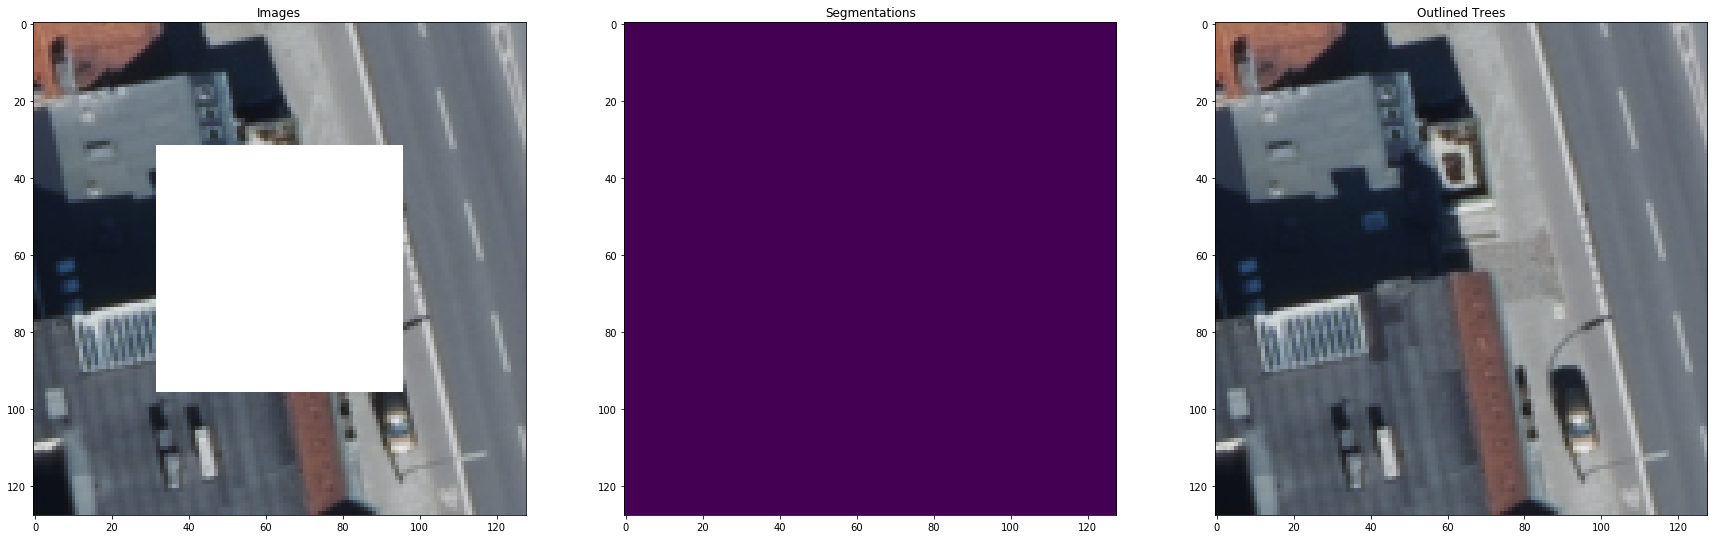

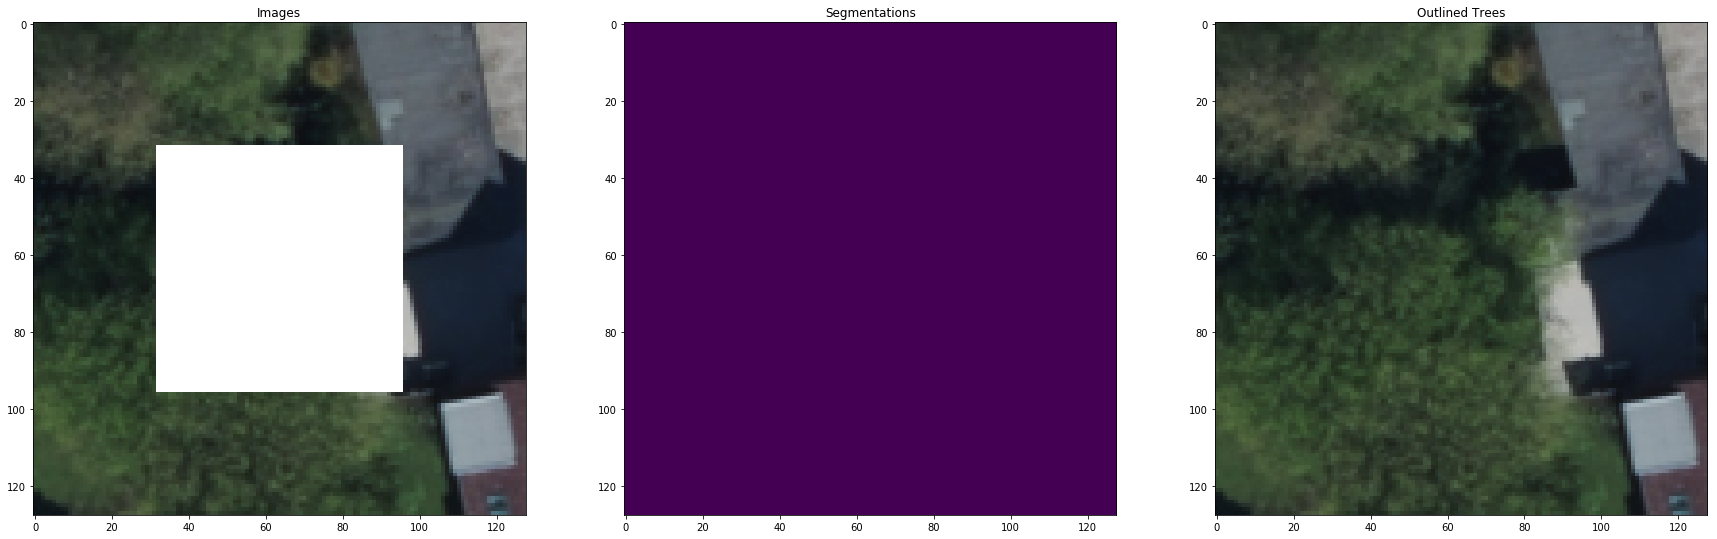

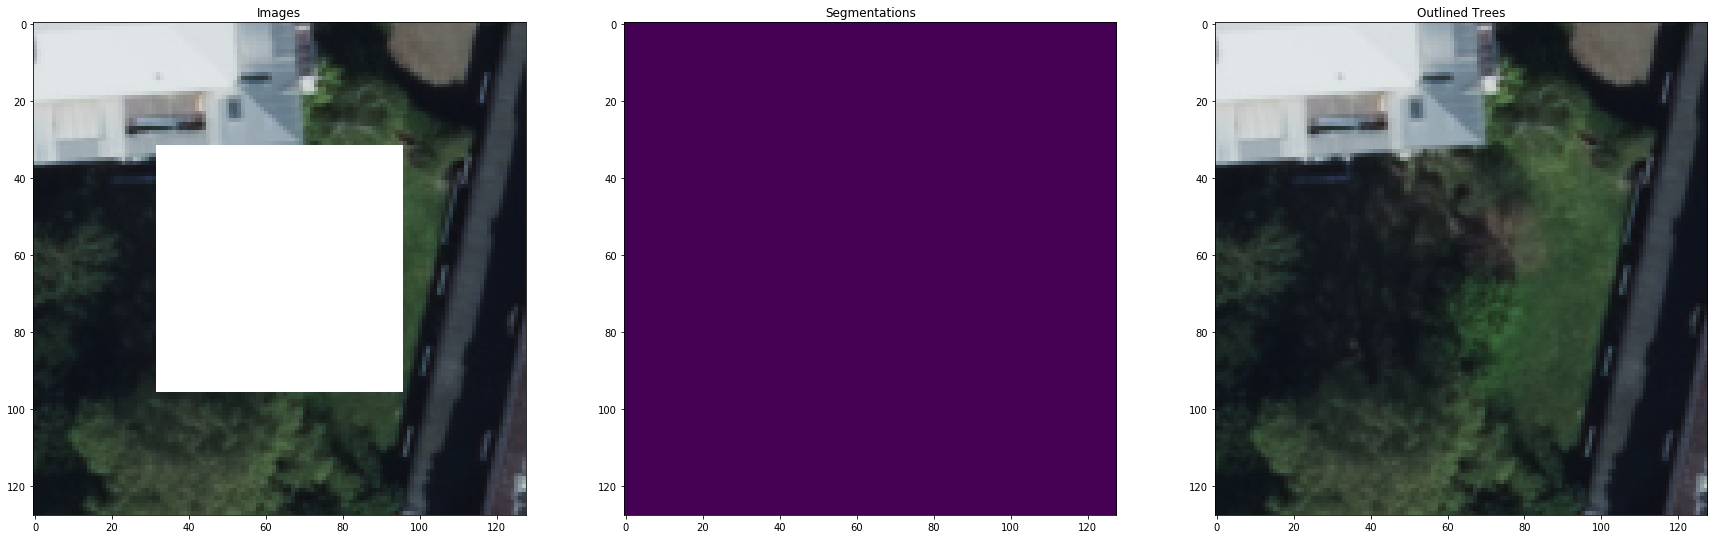

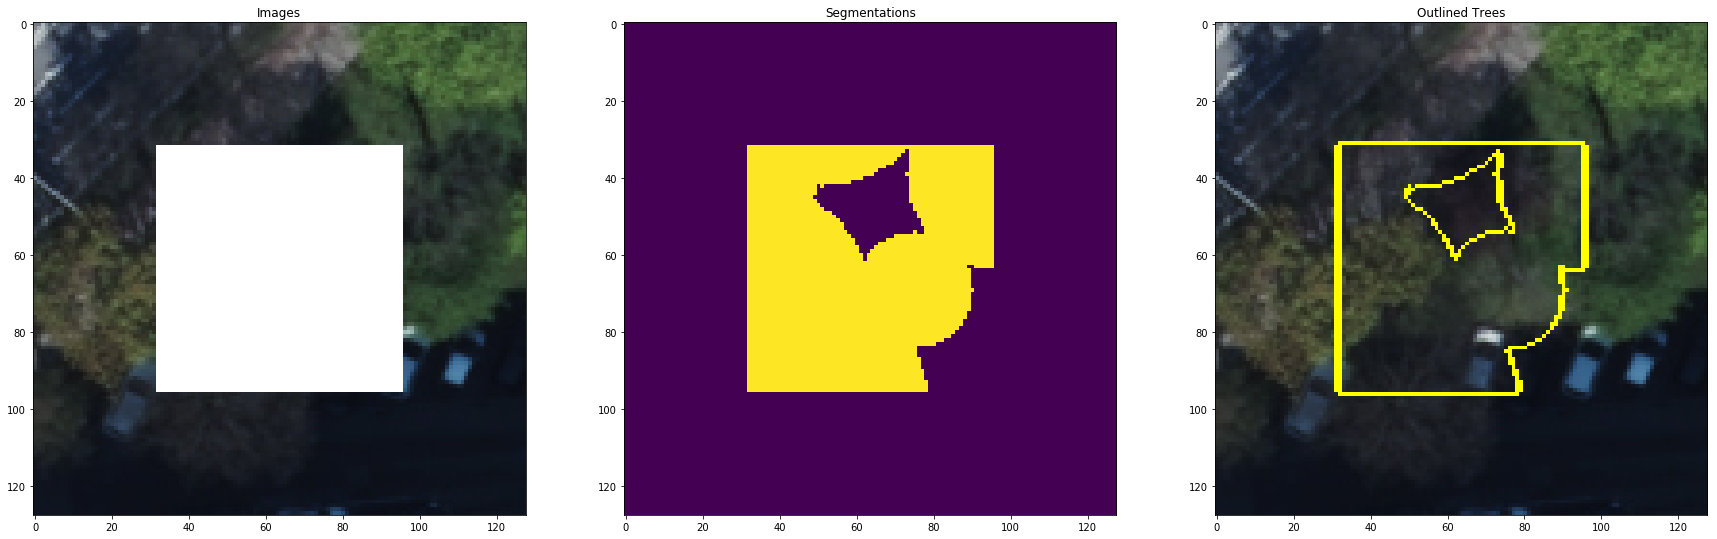

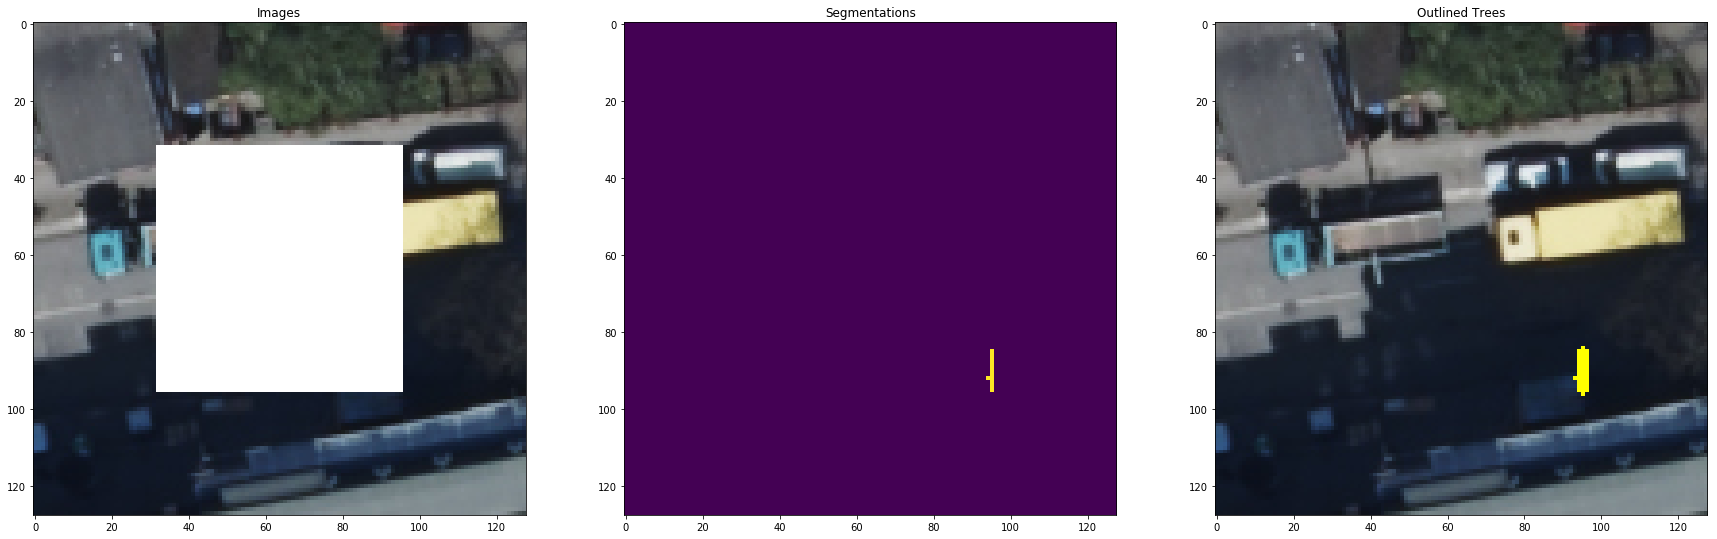

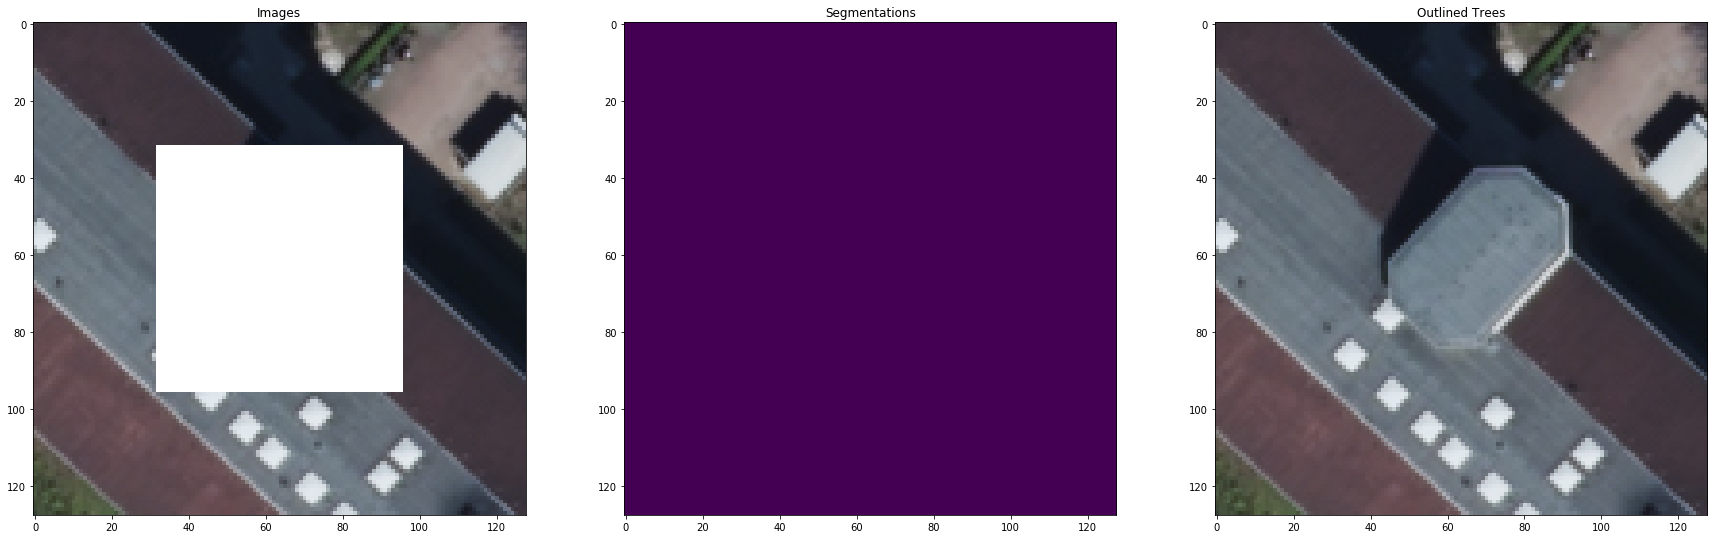

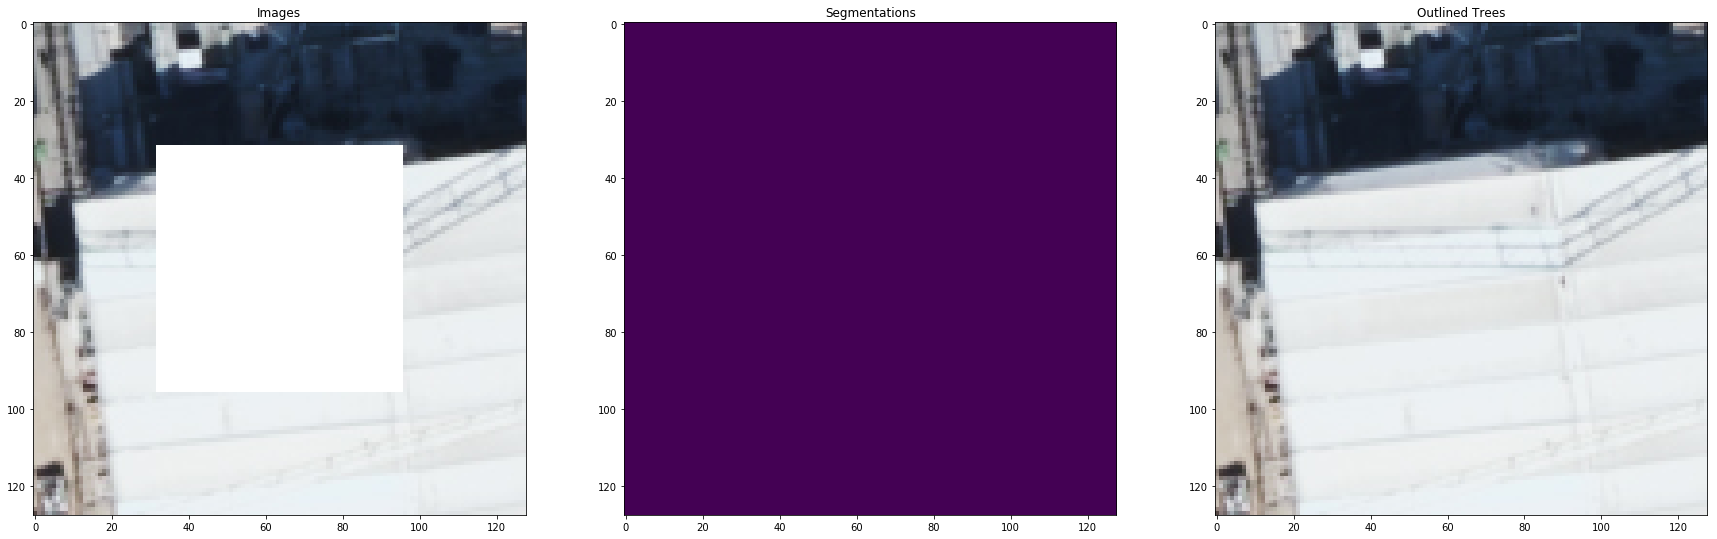

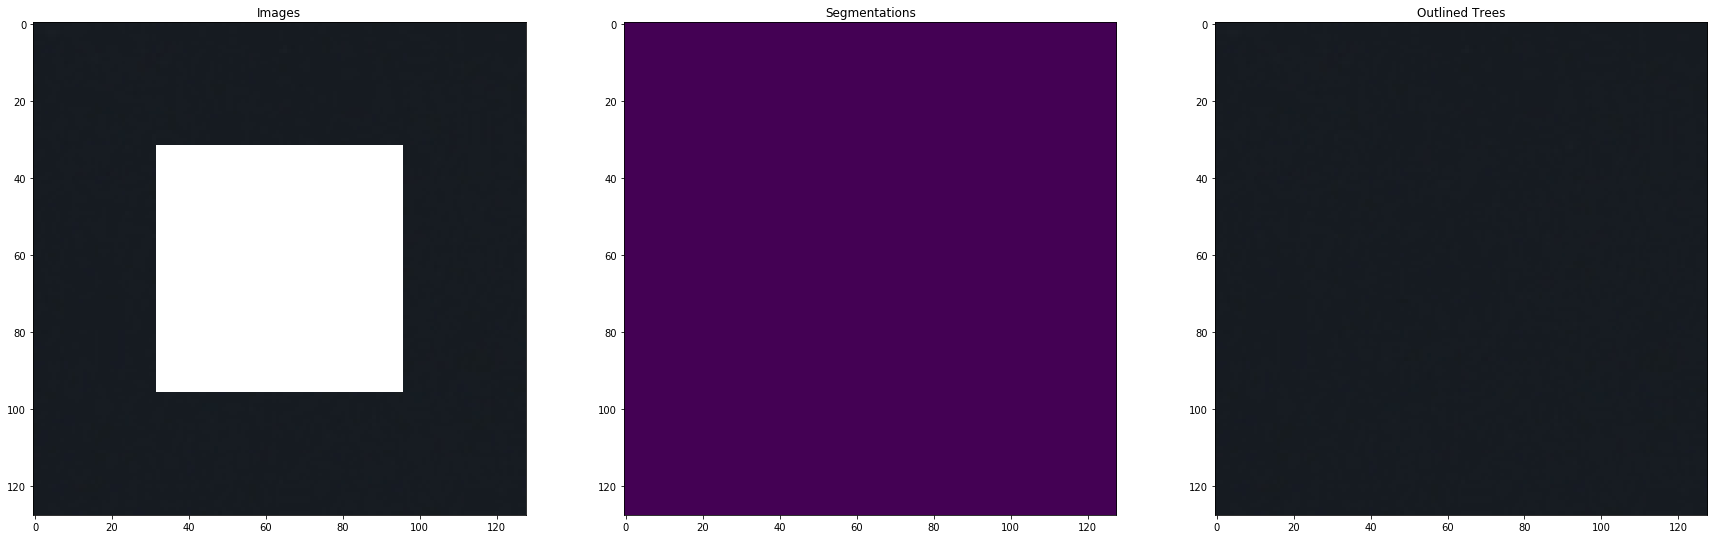

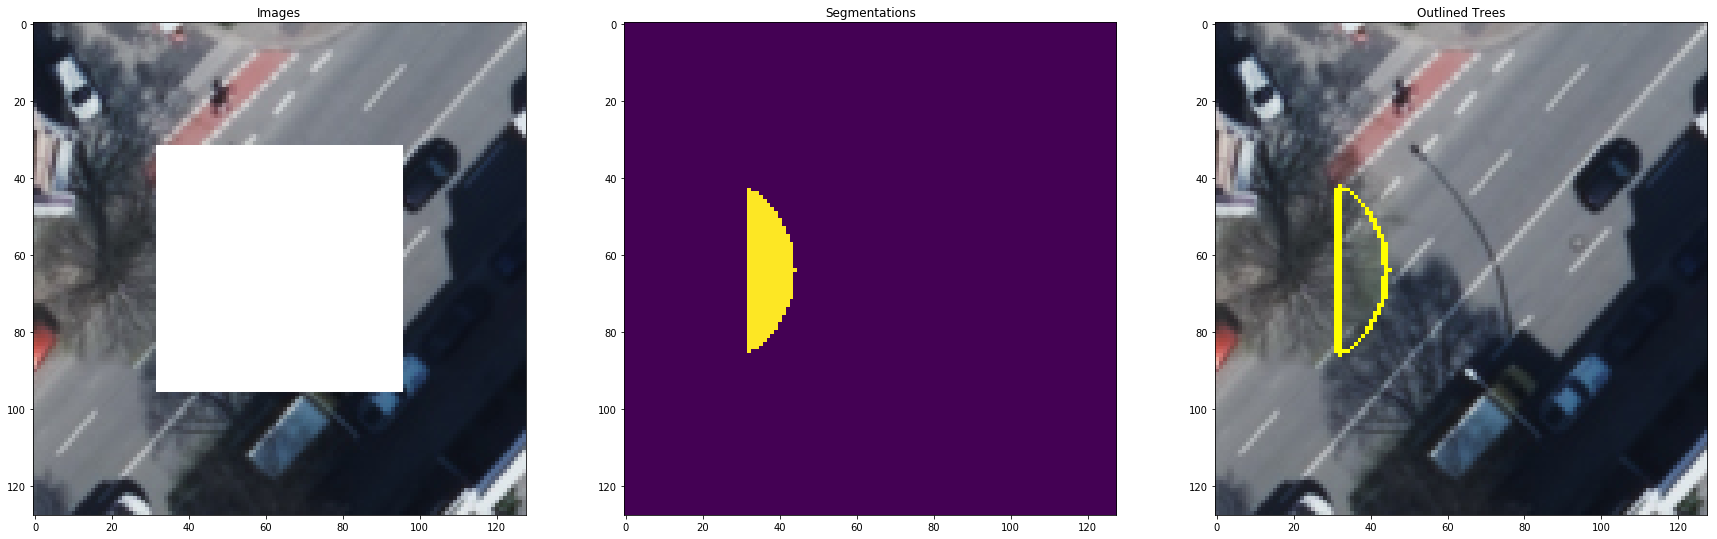

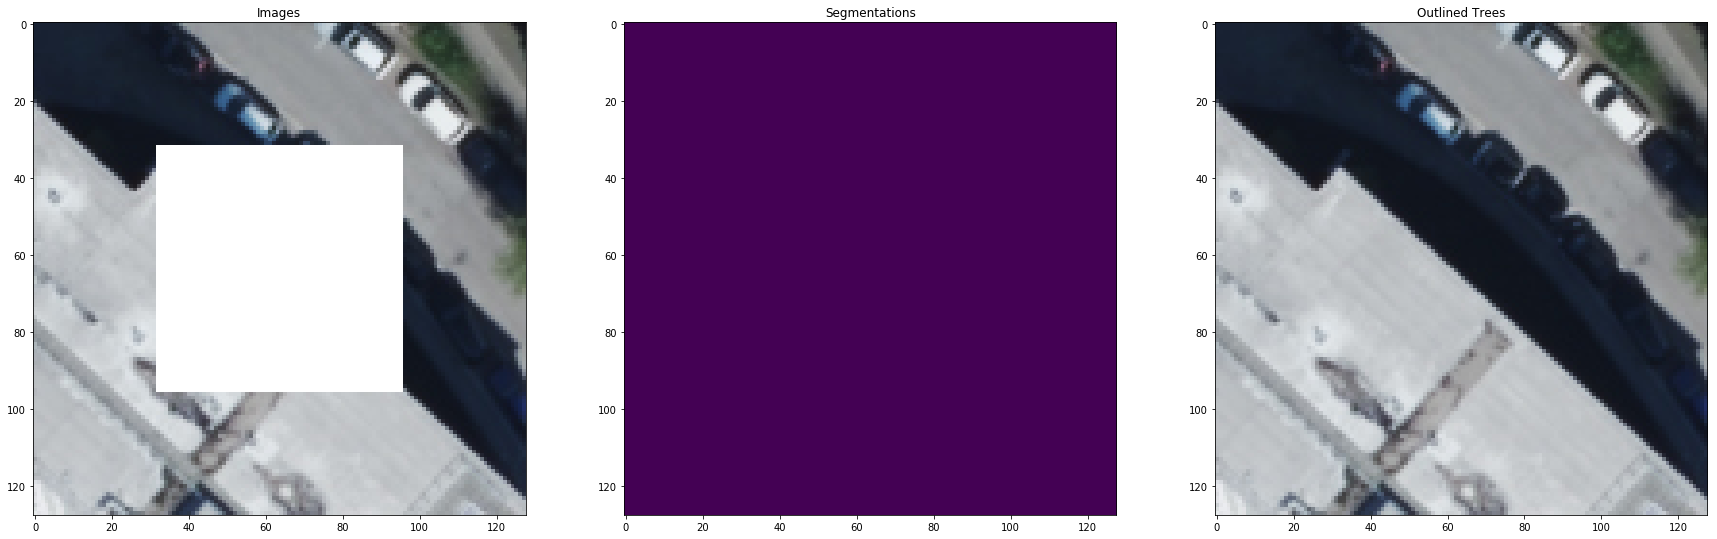

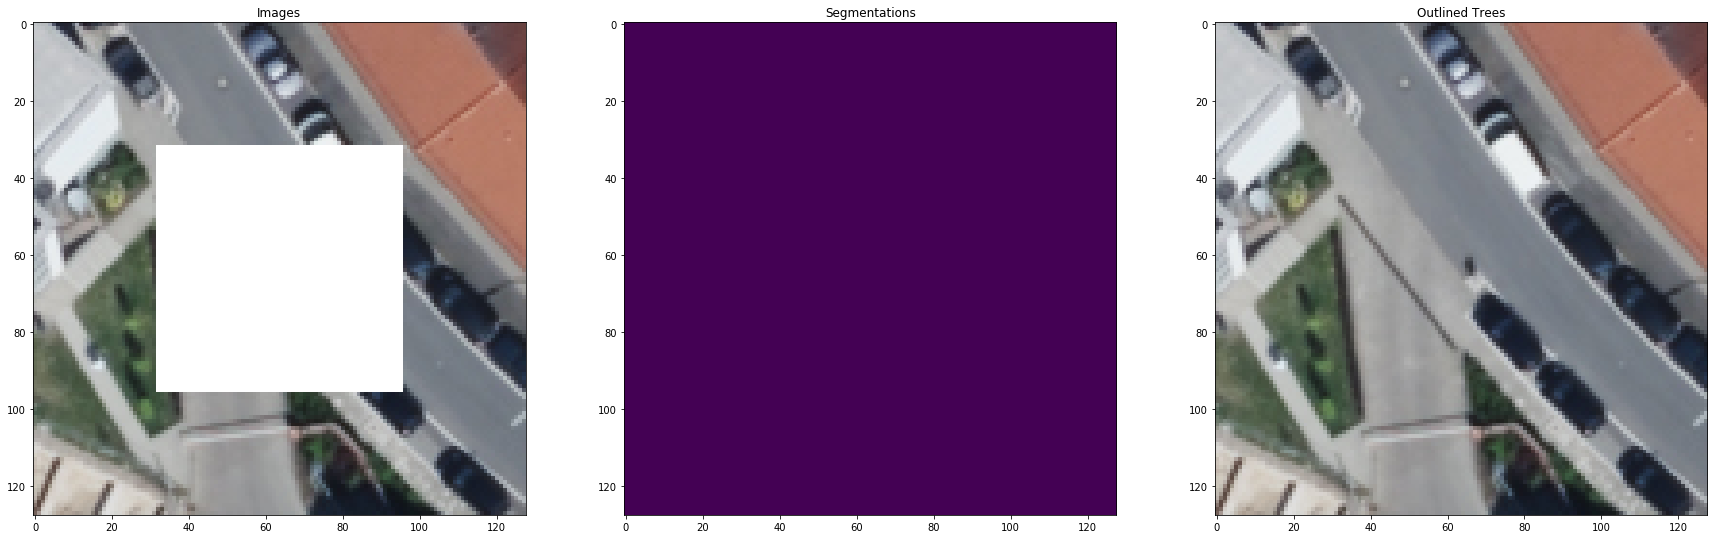

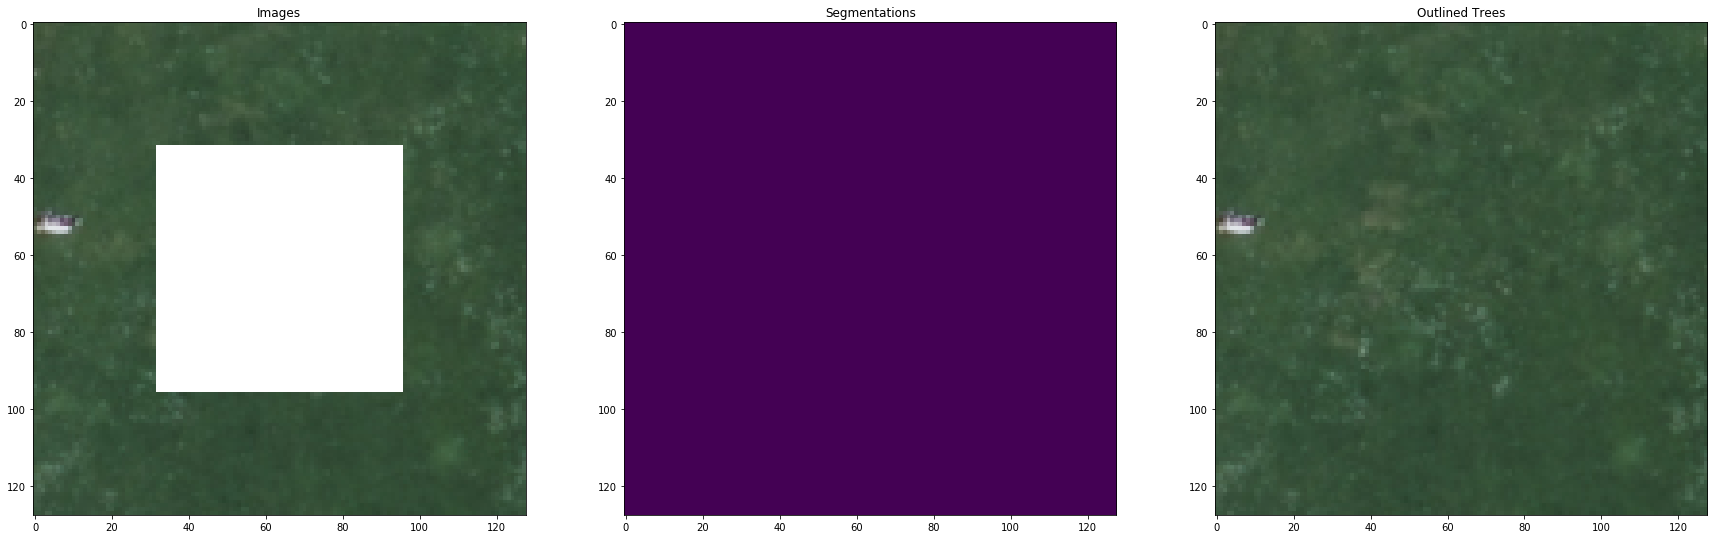

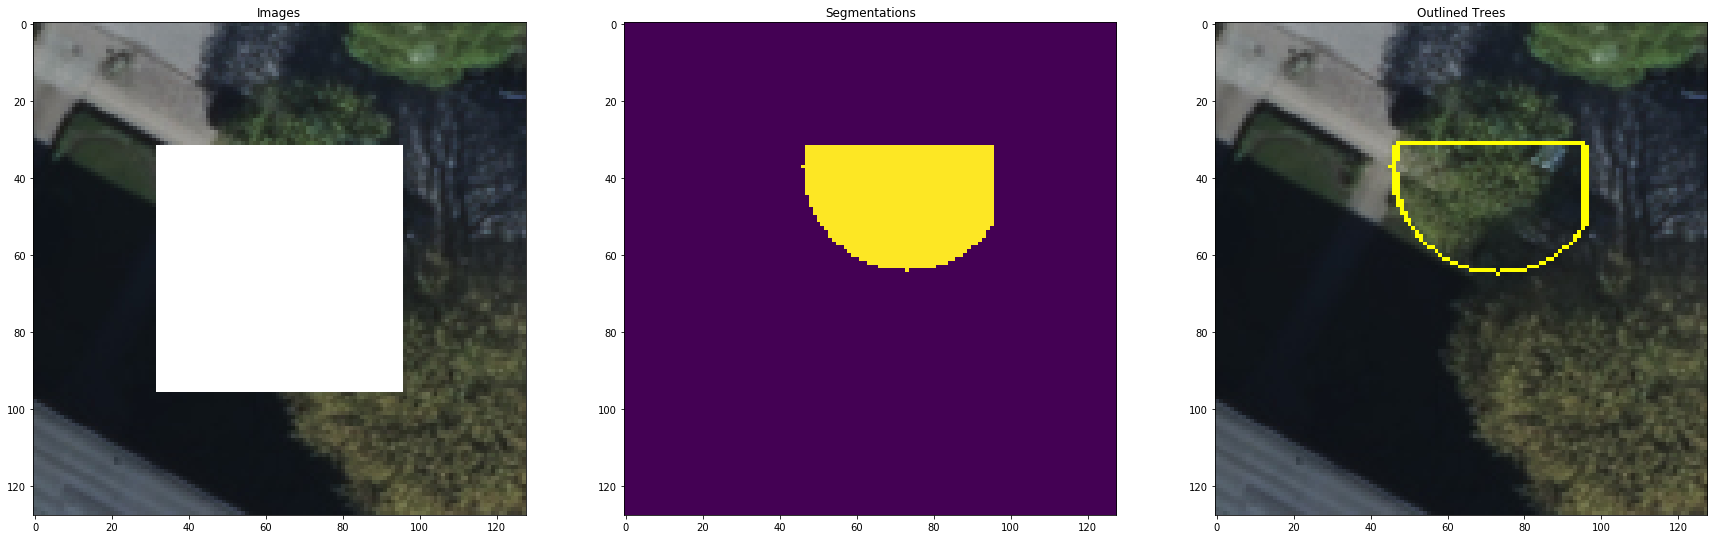

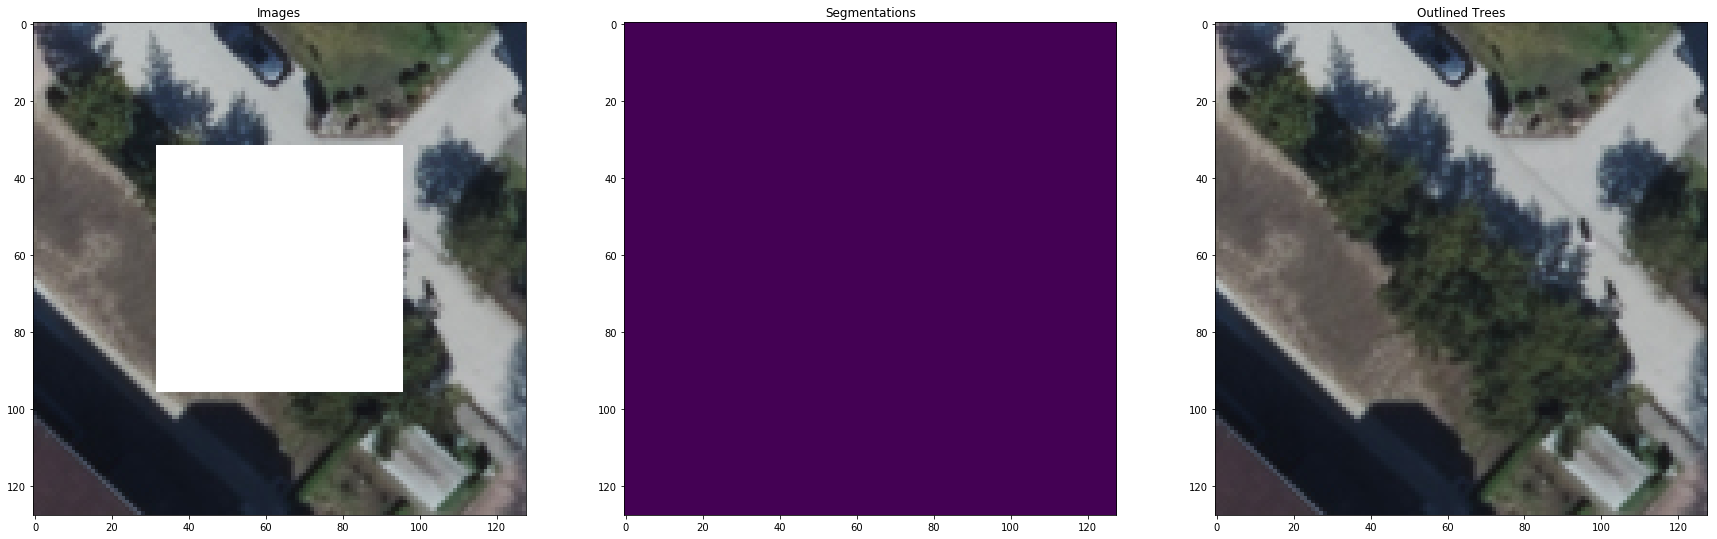

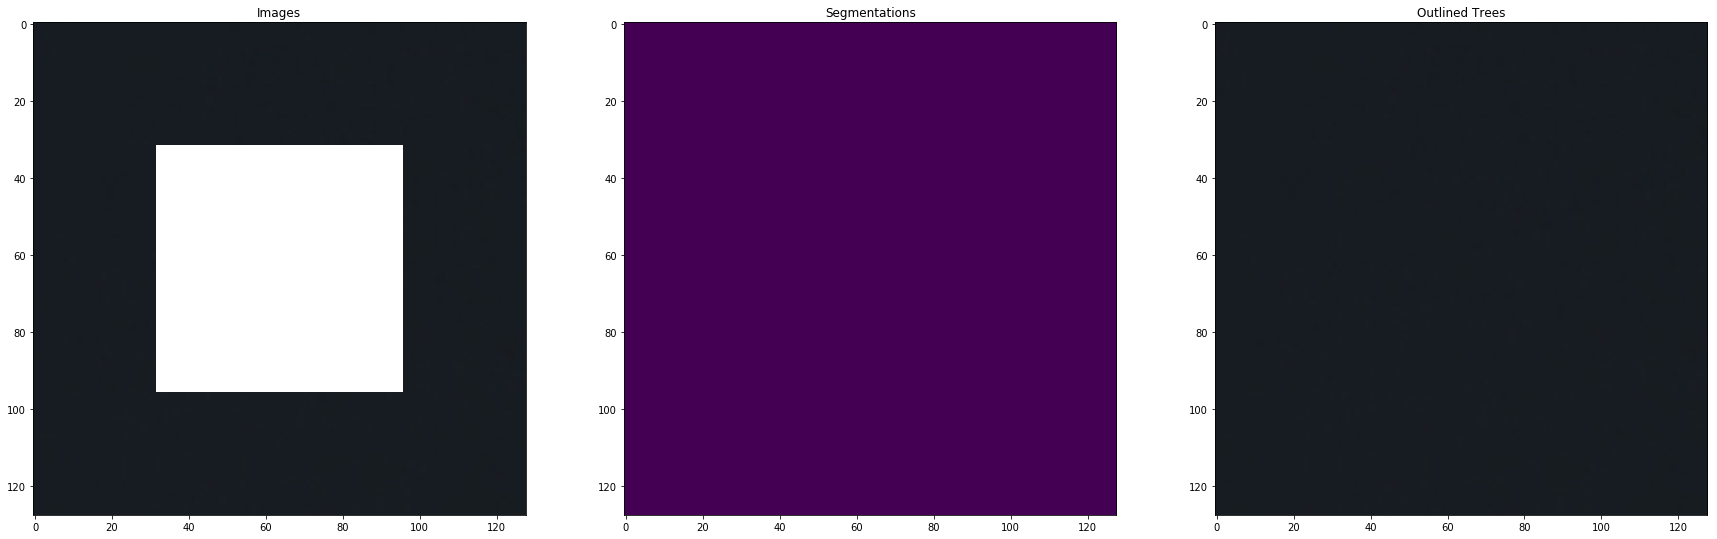

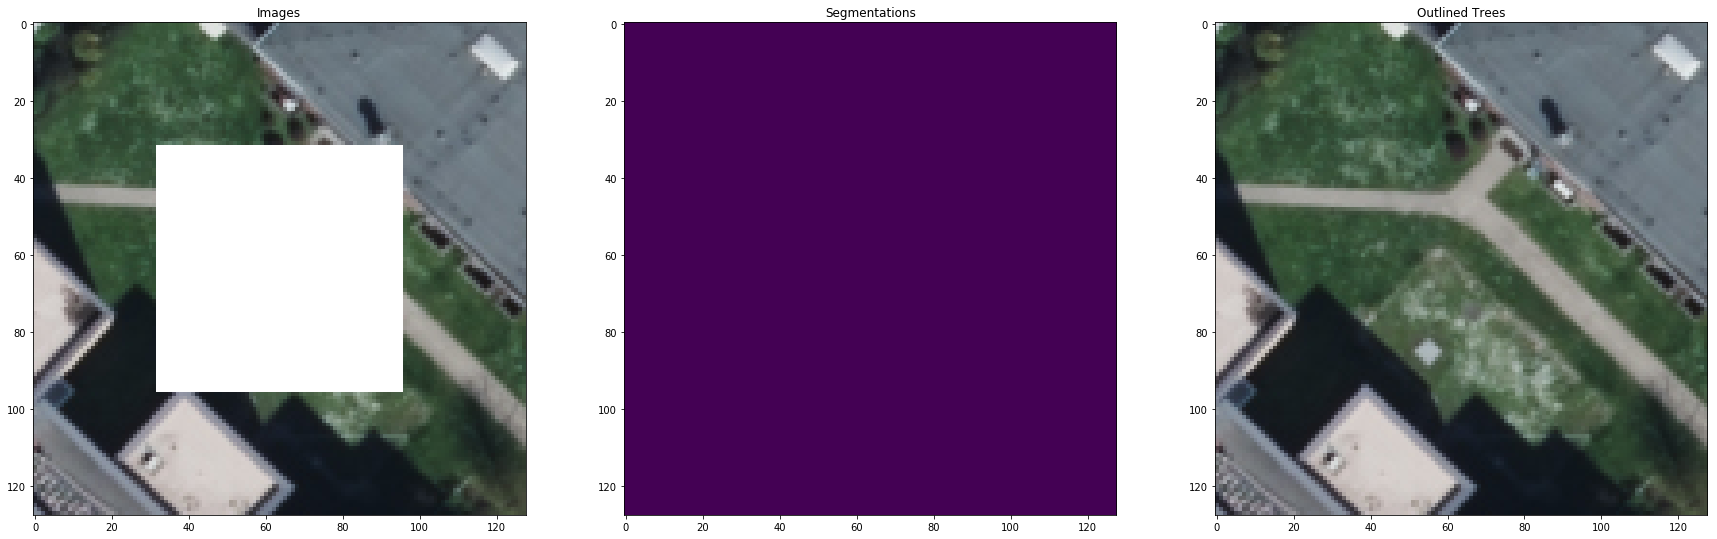

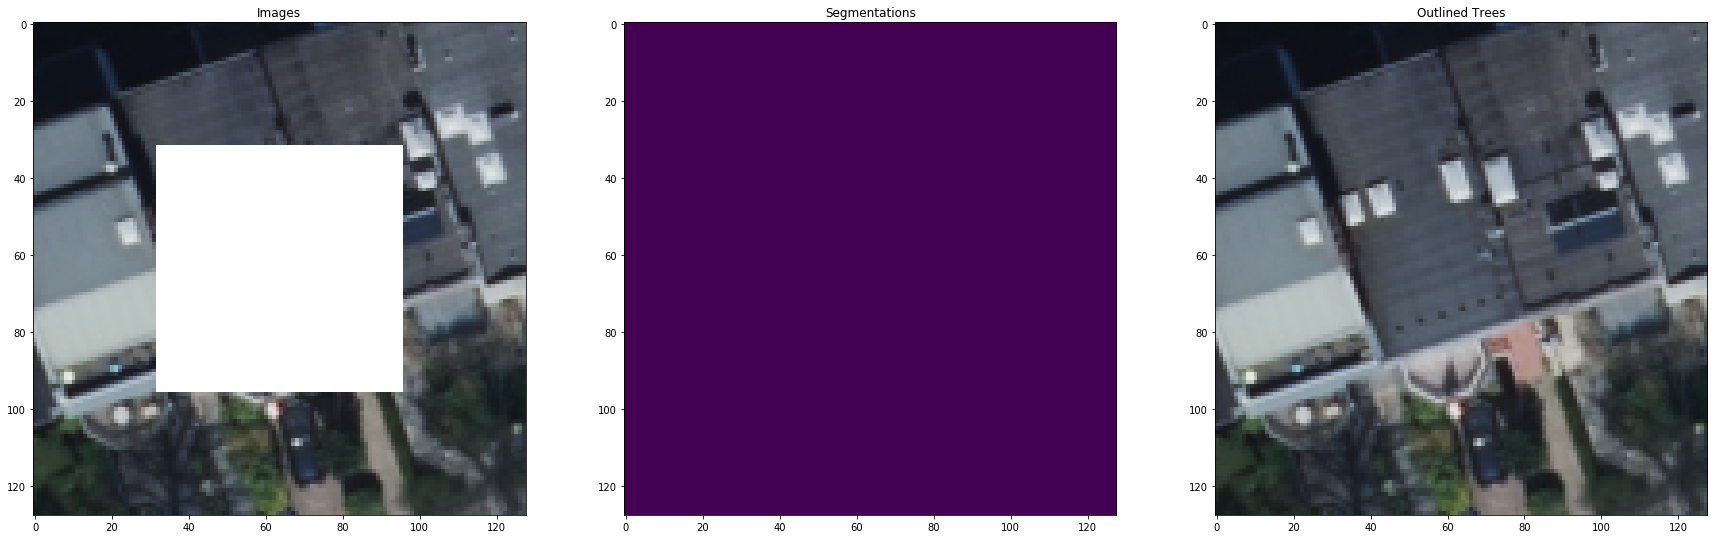

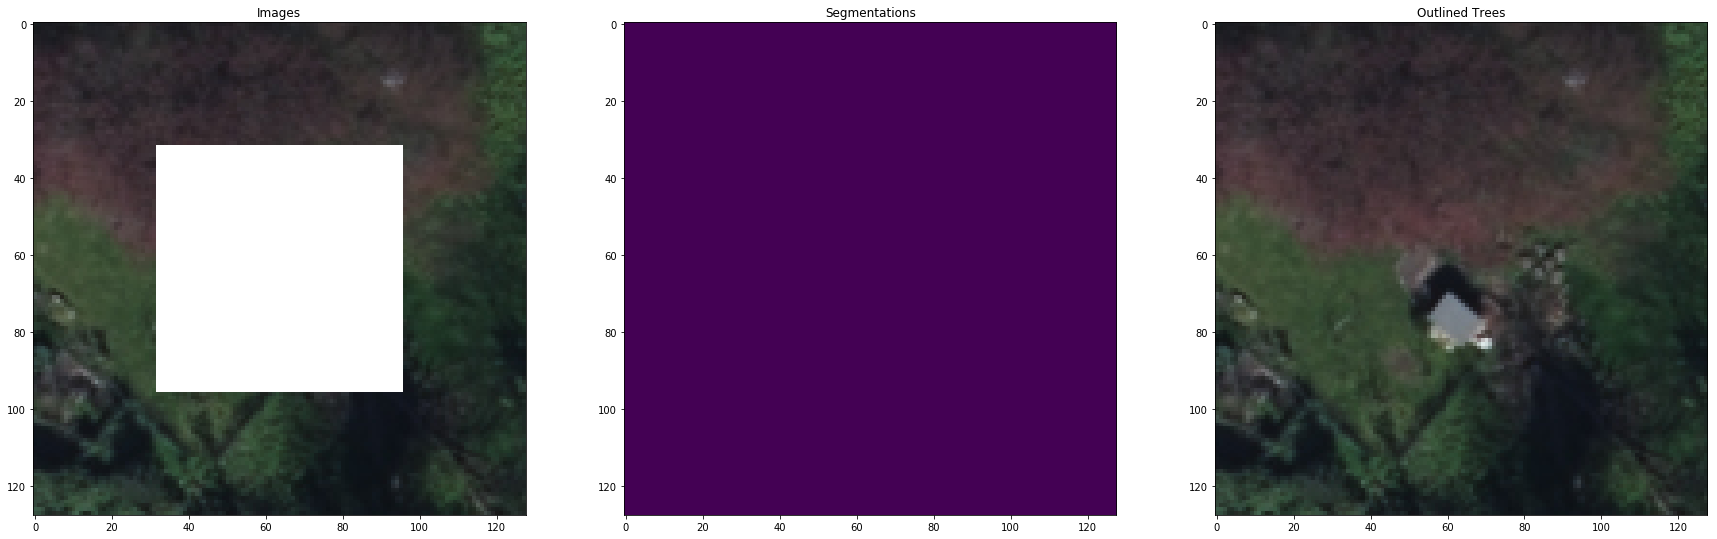

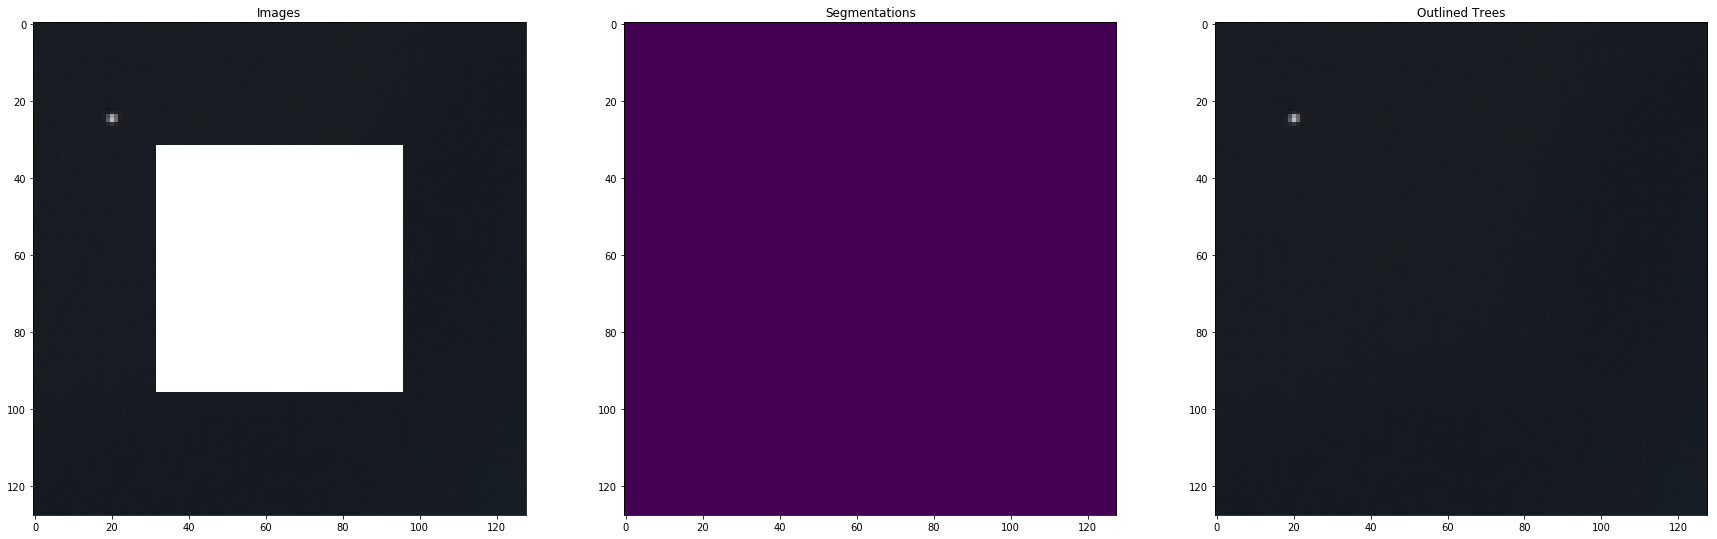

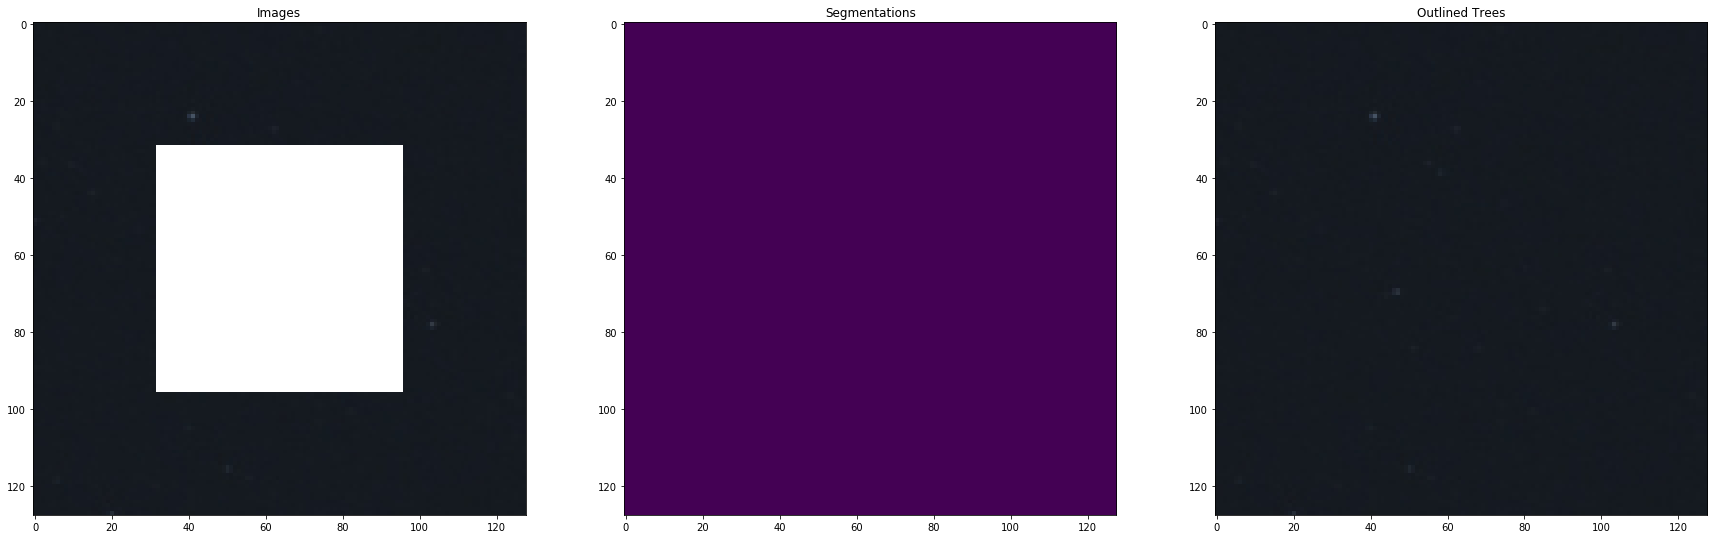

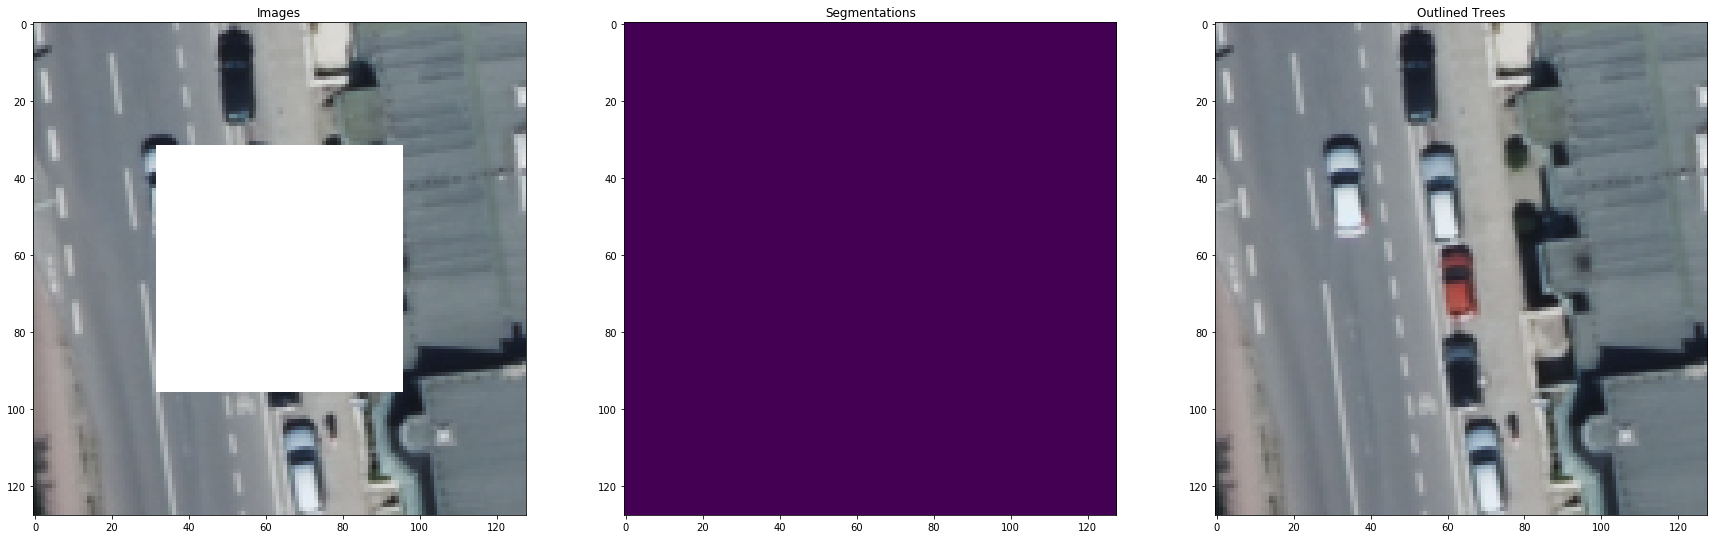

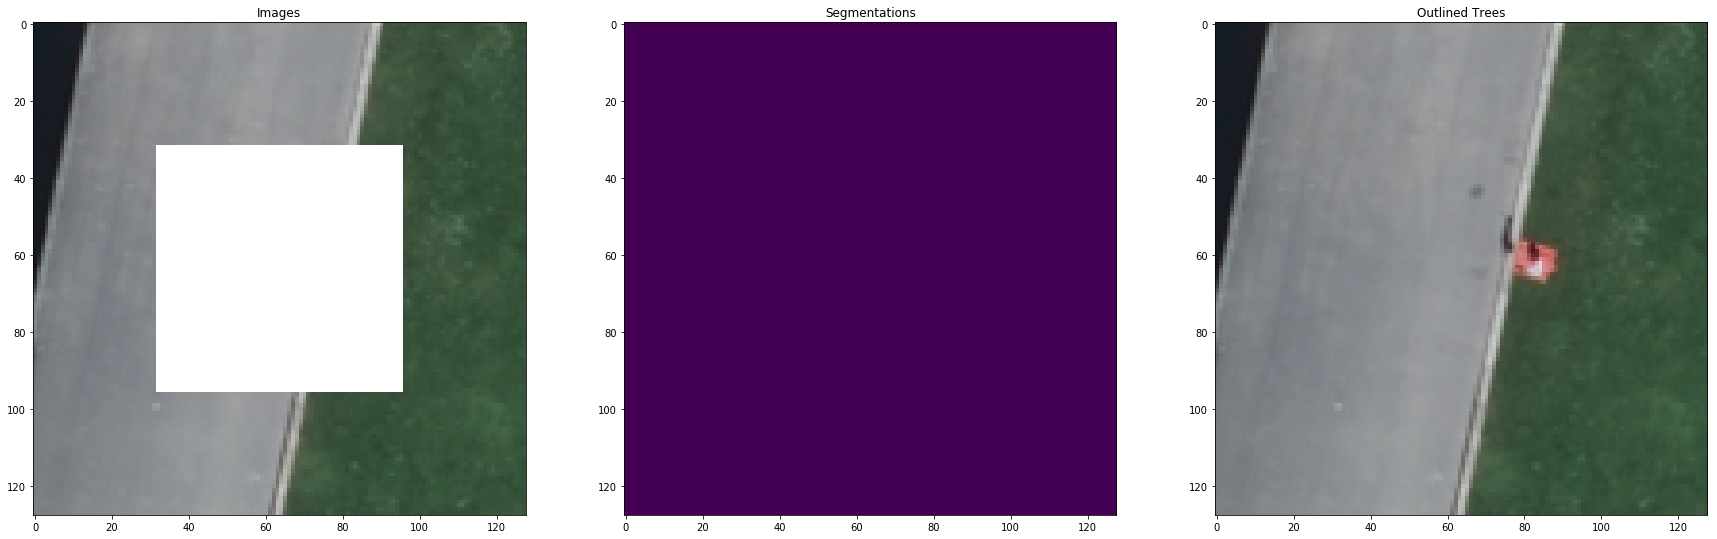

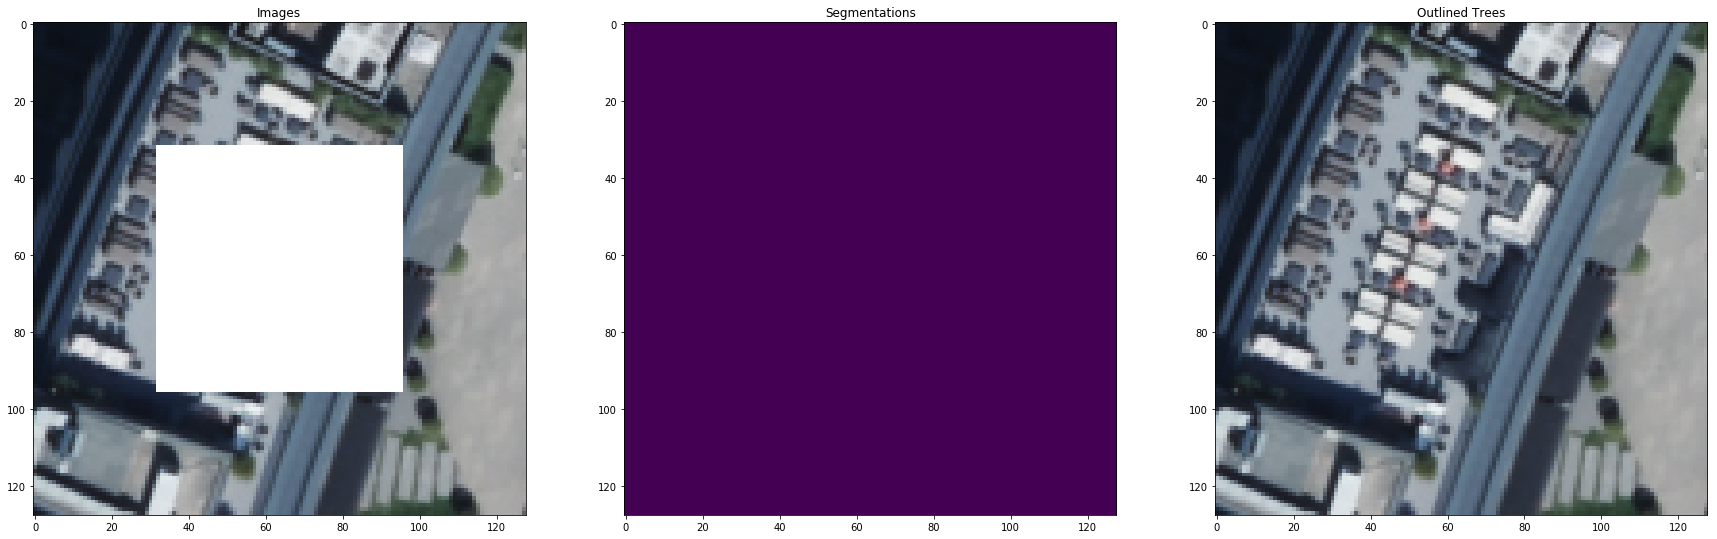

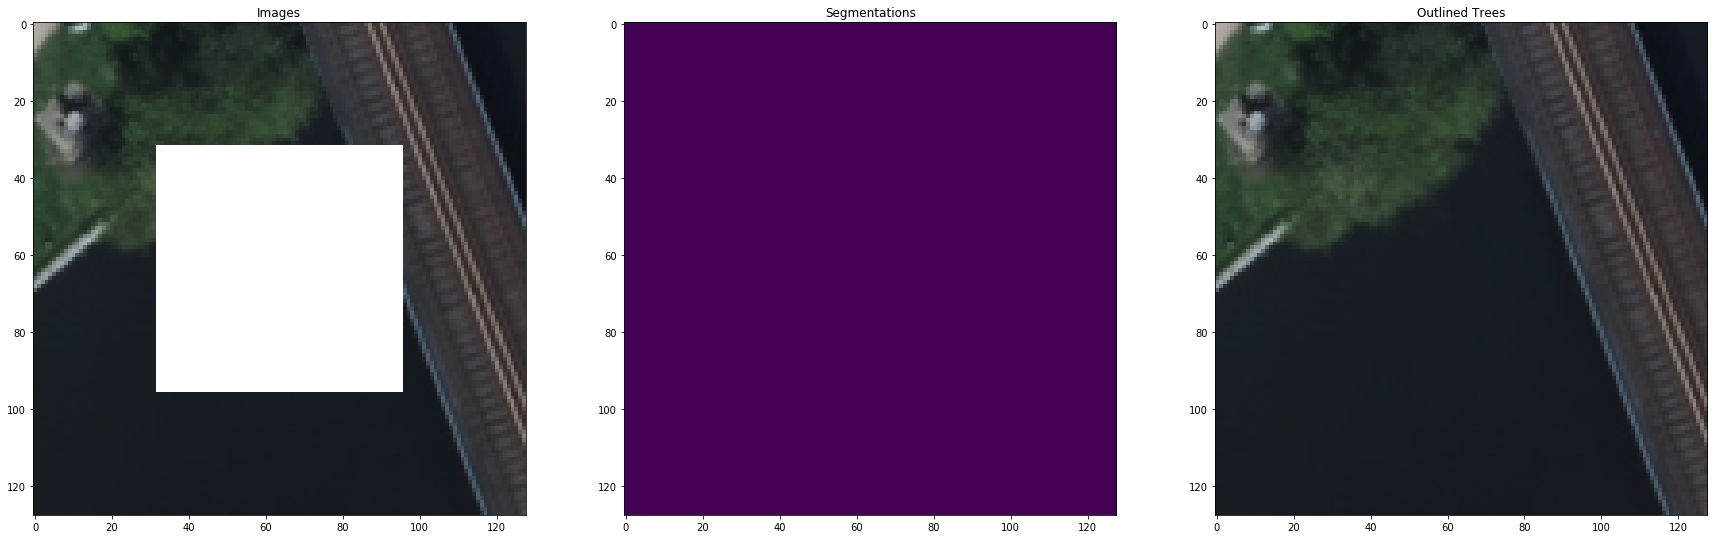

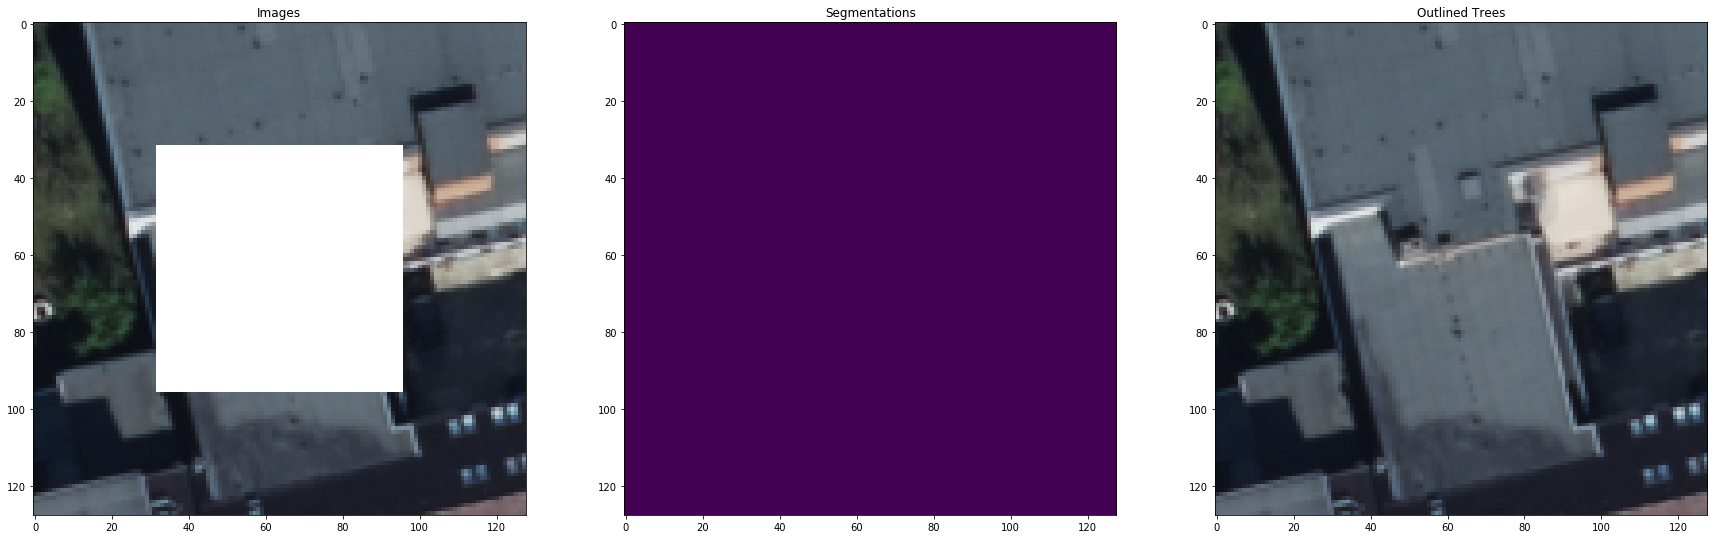

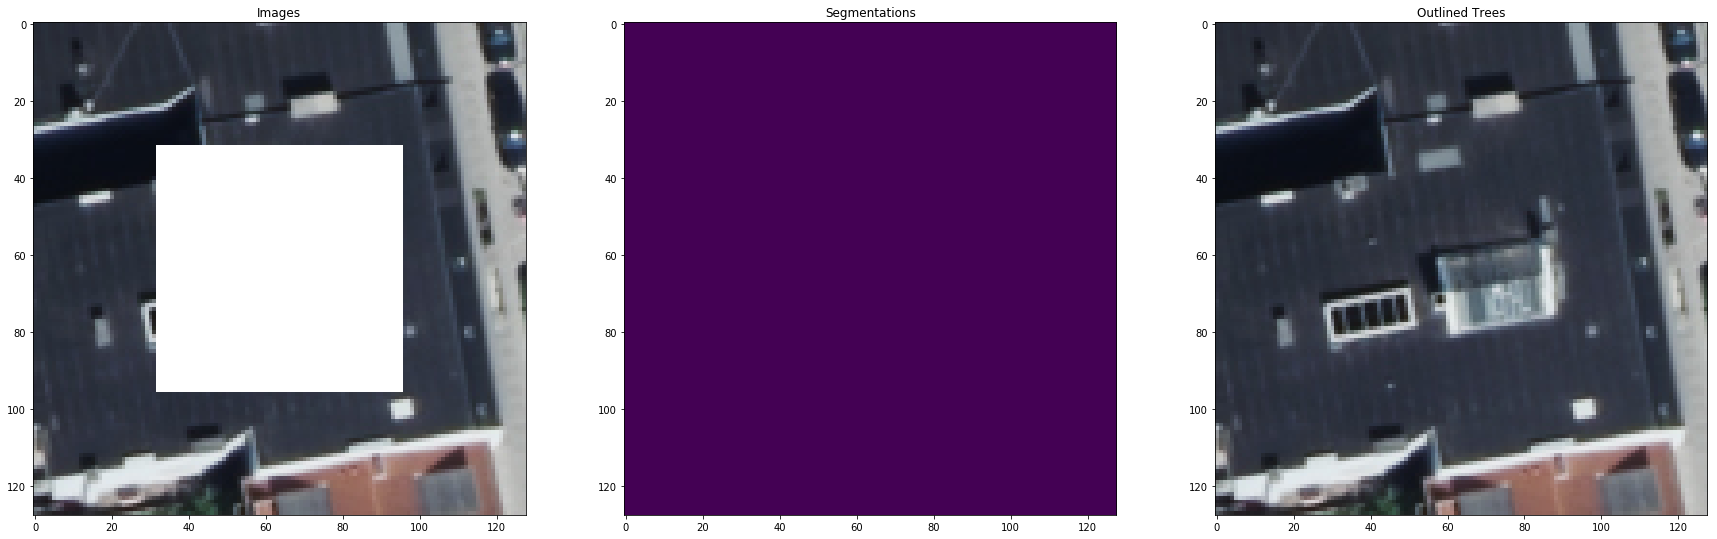

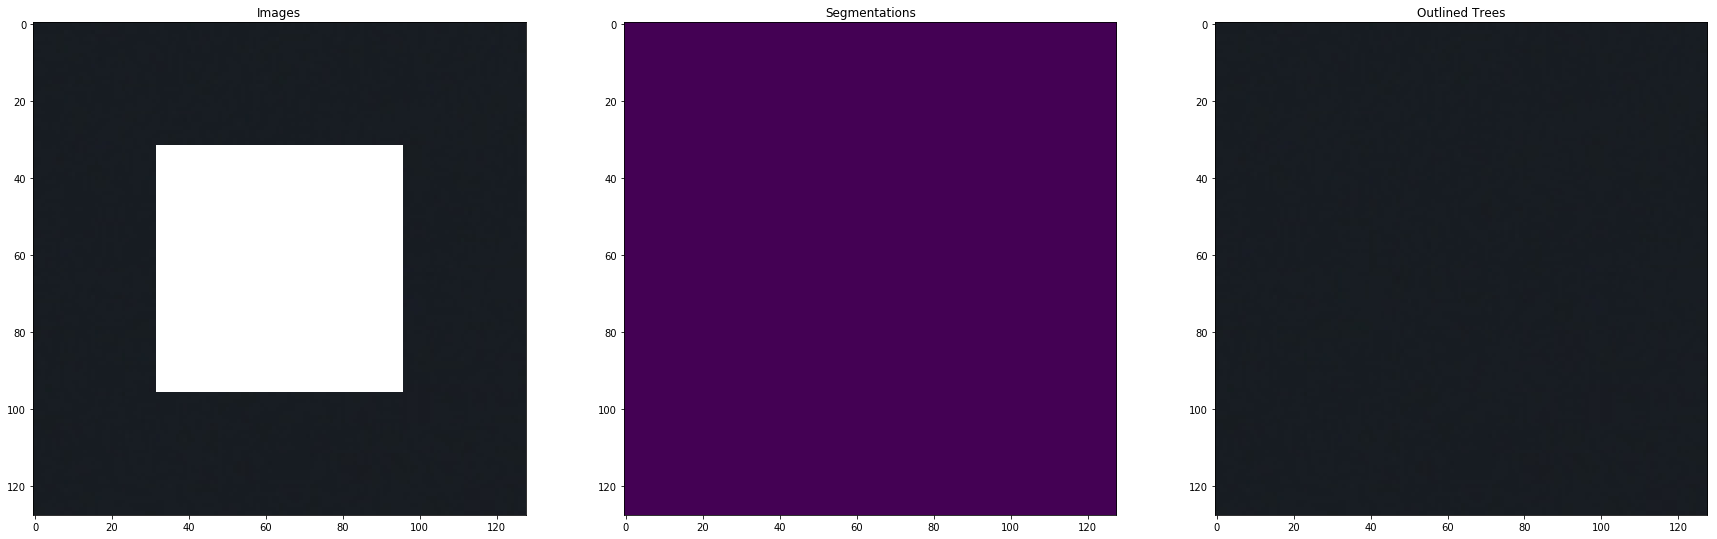

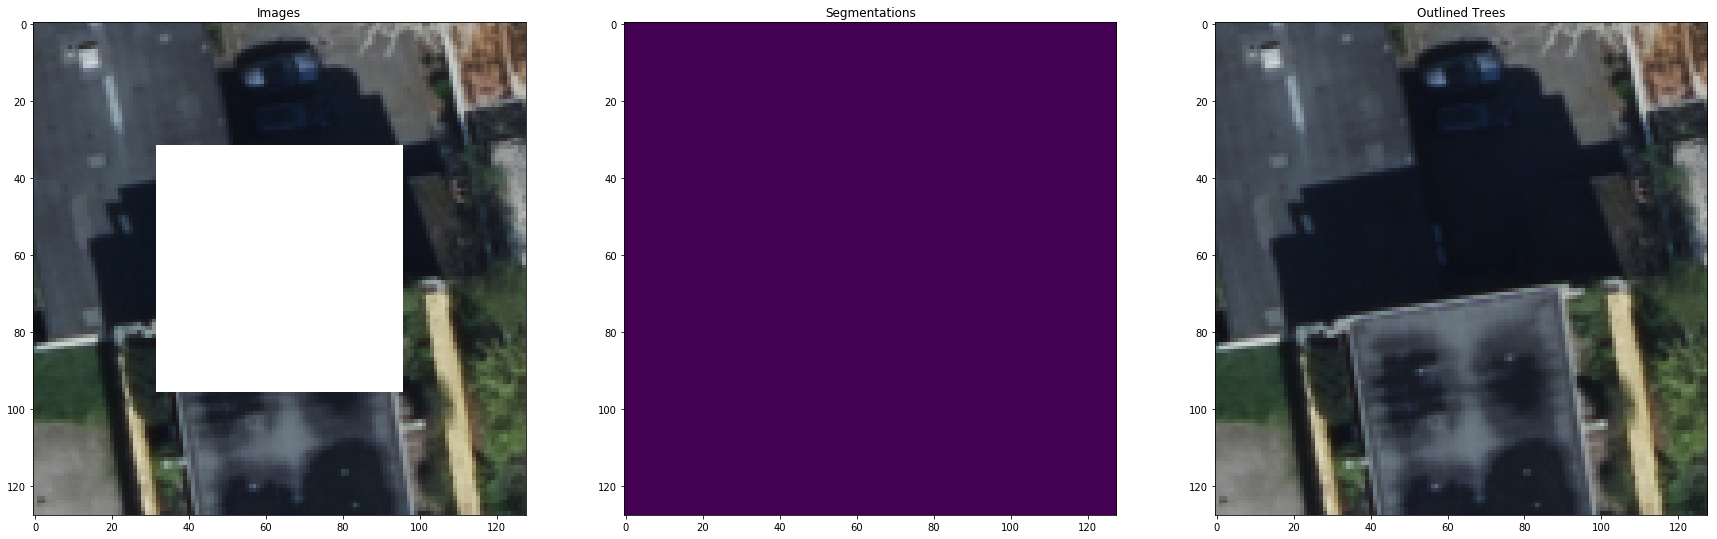

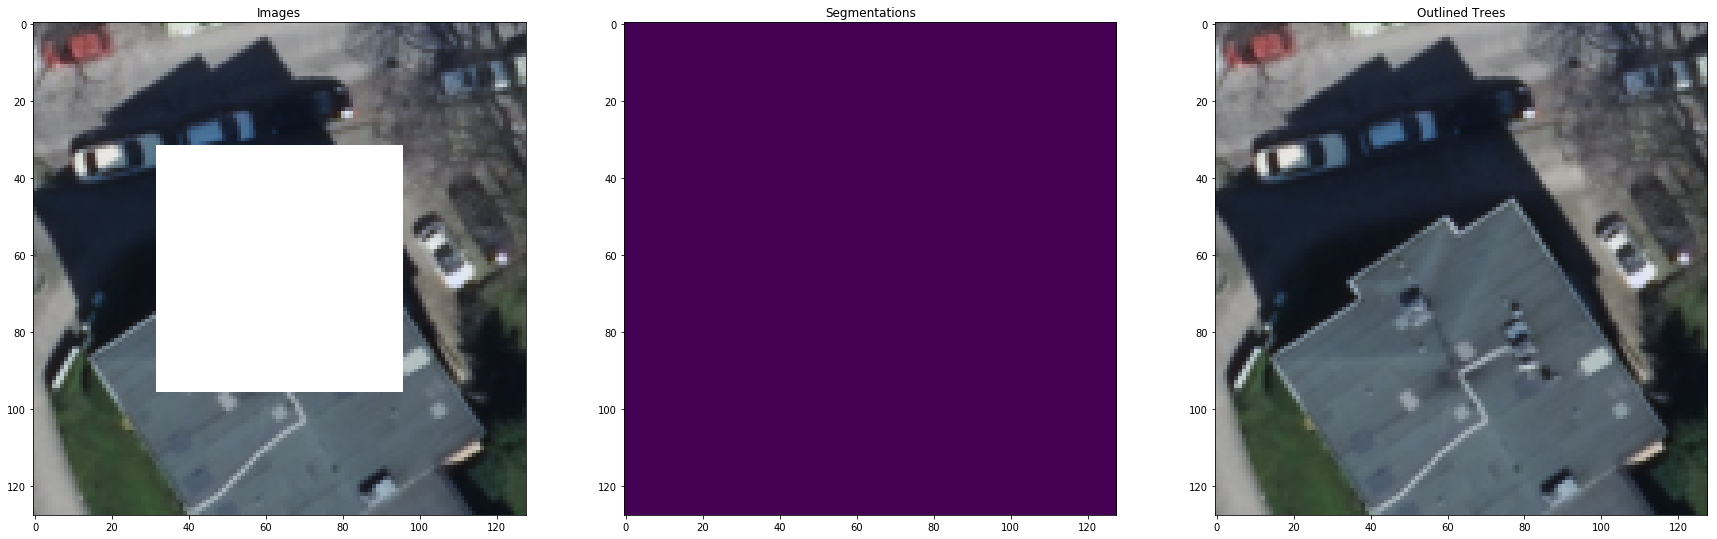

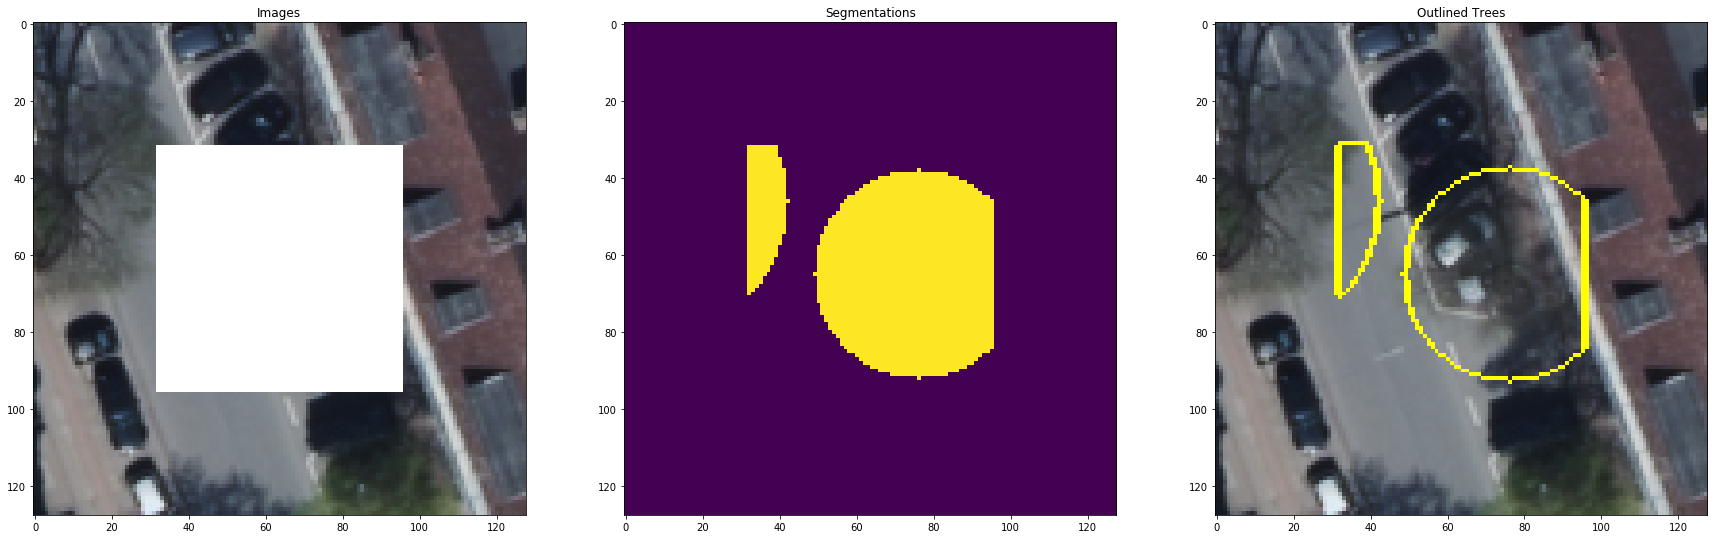

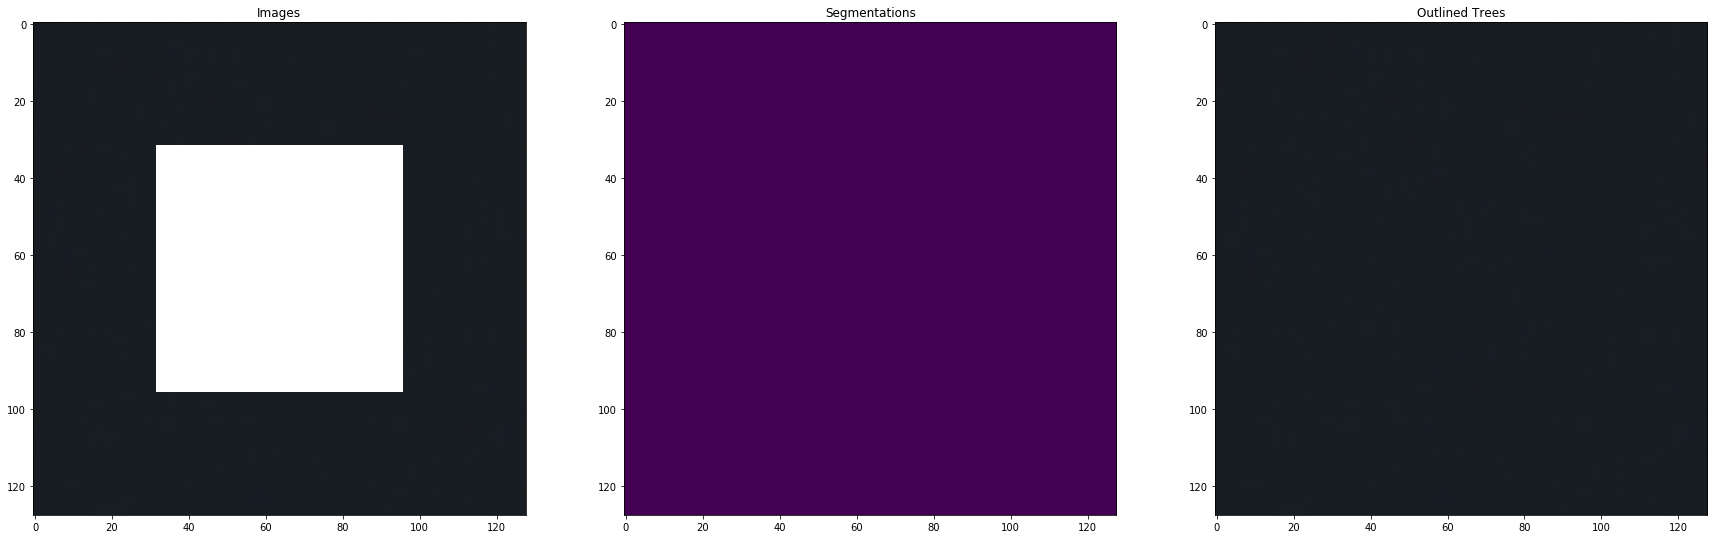

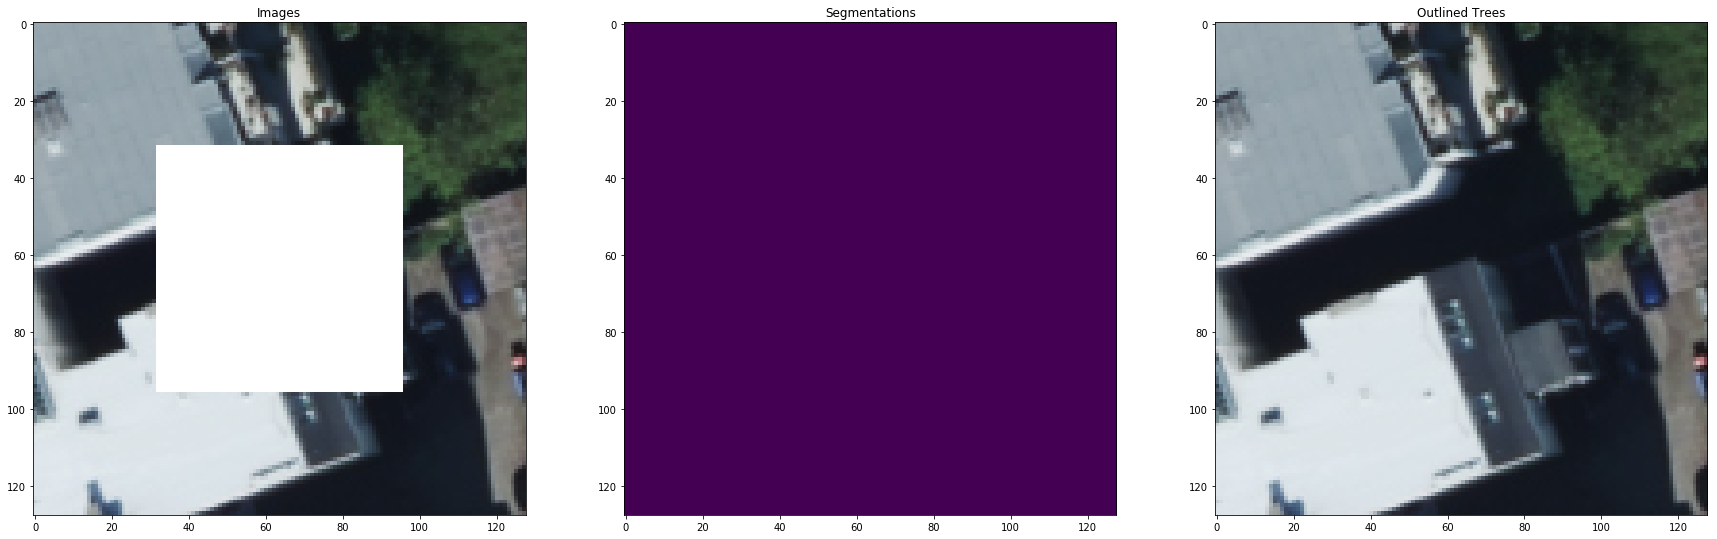

In [11]:
# Print one batch!
x, y = next(aug_gen)
for i in range(x.shape[0]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    xs=x[i]
    ax1.imshow(xs)
    ax1.set_title('Images')
    ys = y[i].squeeze(axis=-1)
    ys[ys > 0] = 1
    ax2.imshow(ys)
    ax2.set_title('Segmentations')
    ax3.imshow(mark_boundaries(xs[:,:,0:3], ys.astype(int)))
    ax3.set_title('Outlined Trees')
    fig.show()

In [15]:
step_count = MAX_TRAIN_STEPS
loss_history = [model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=valid,
                             validation_steps=20,
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0266 - dice_coef: 0.0684 - binary_accuracy: 0.9950 - true_positive_rate: 0.6429 - val_loss: 0.0287 - val_dice_coef: 0.0615 - val_binary_accuracy: 0.9926 - val_true_positive_rate: nan

Epoch 00001: saving model to weights/UNet/20181121-1220/seg_model_weights.best.hdf5
Epoch 2/10
100/100 [==============================] - 15s 149ms/step - loss: 0.0178 - dice_coef: 0.0865 - binary_accuracy: 0.9964 - true_positive_rate: 0.8171 - val_loss: 0.0399 - val_dice_coef: 0.0576 - val_binary_accuracy: 0.9894 - val_true_positive_rate: 0.2065

Epoch 00002: saving model to weights/UNet/20181121-1220/seg_model_weights.best.hdf5
Epoch 3/10
100/100 [==============================] - 15s 149ms/step - loss: 0.0139 - dice_coef: 0.0960 - binary_accuracy: 0.9968 - true_positive_rate: 0.8472 - val_loss: 0.0195 - val_dice_coef: 0.0704 - val_binary_accuracy: 0.9949 - val_true_positive_rate: 0.4083

Epoch 00003: saving model to weights/

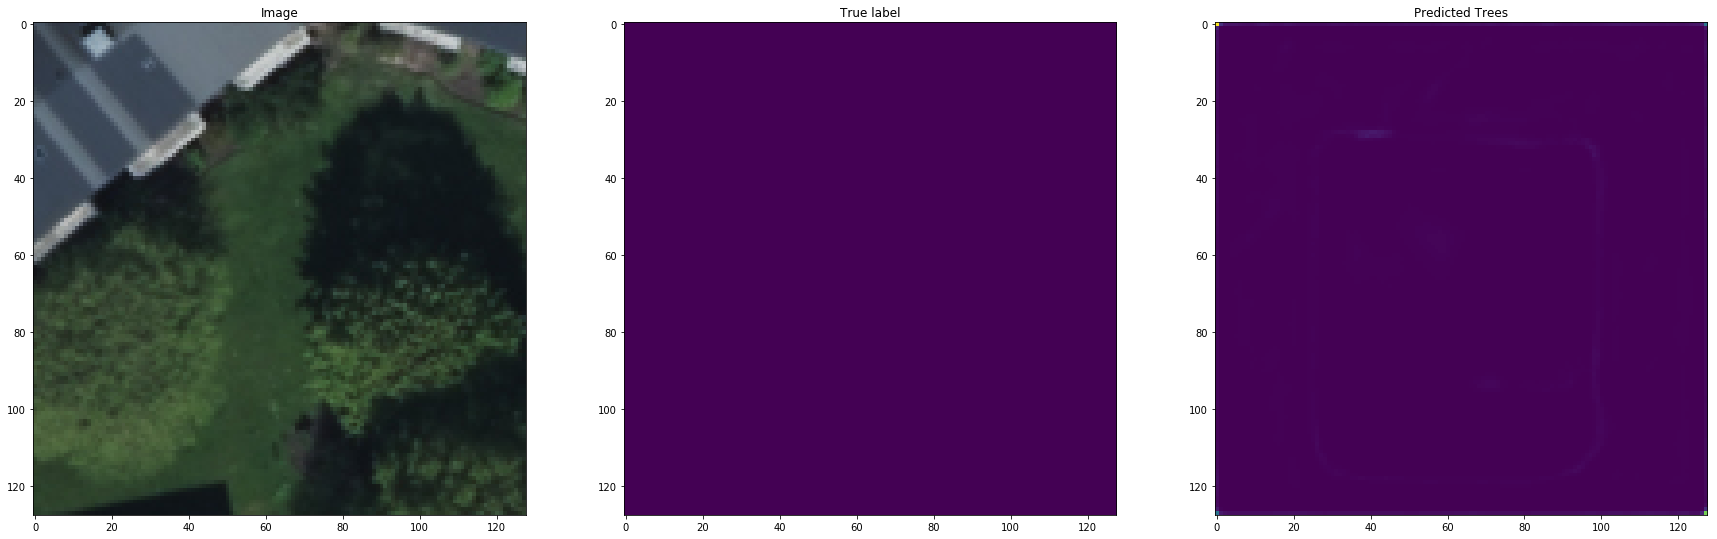

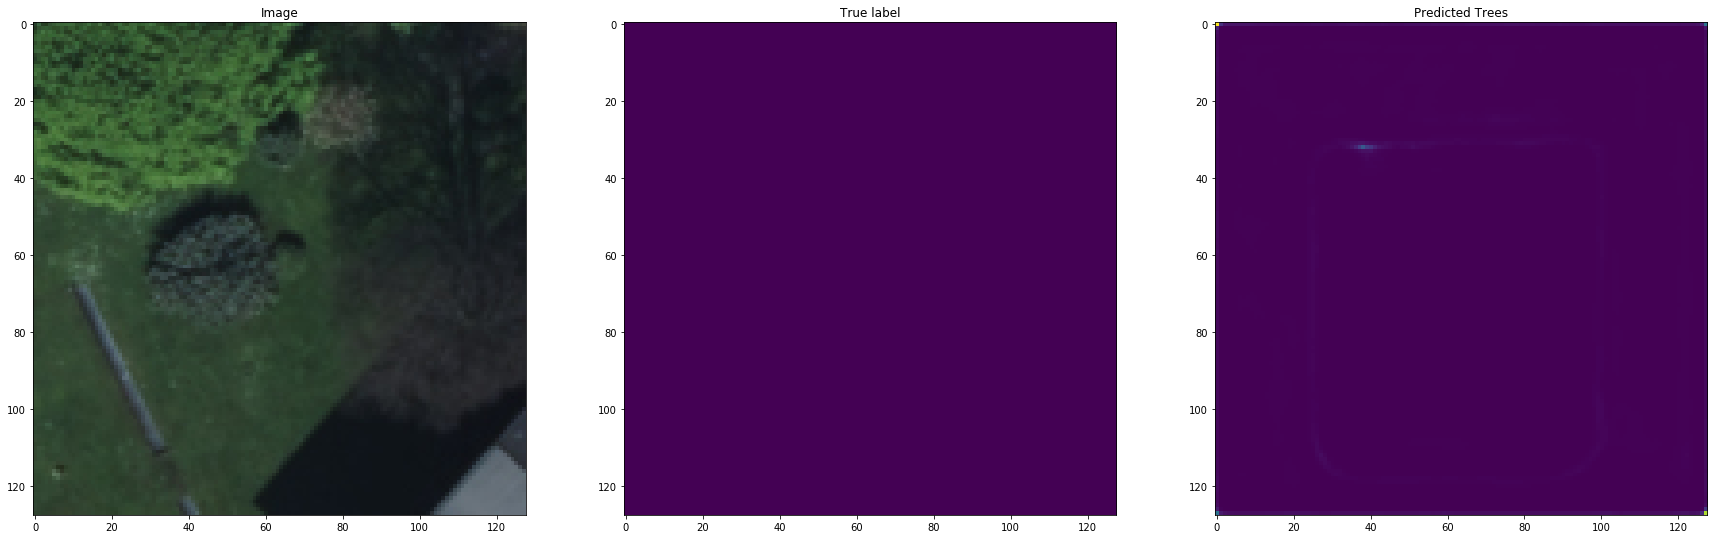

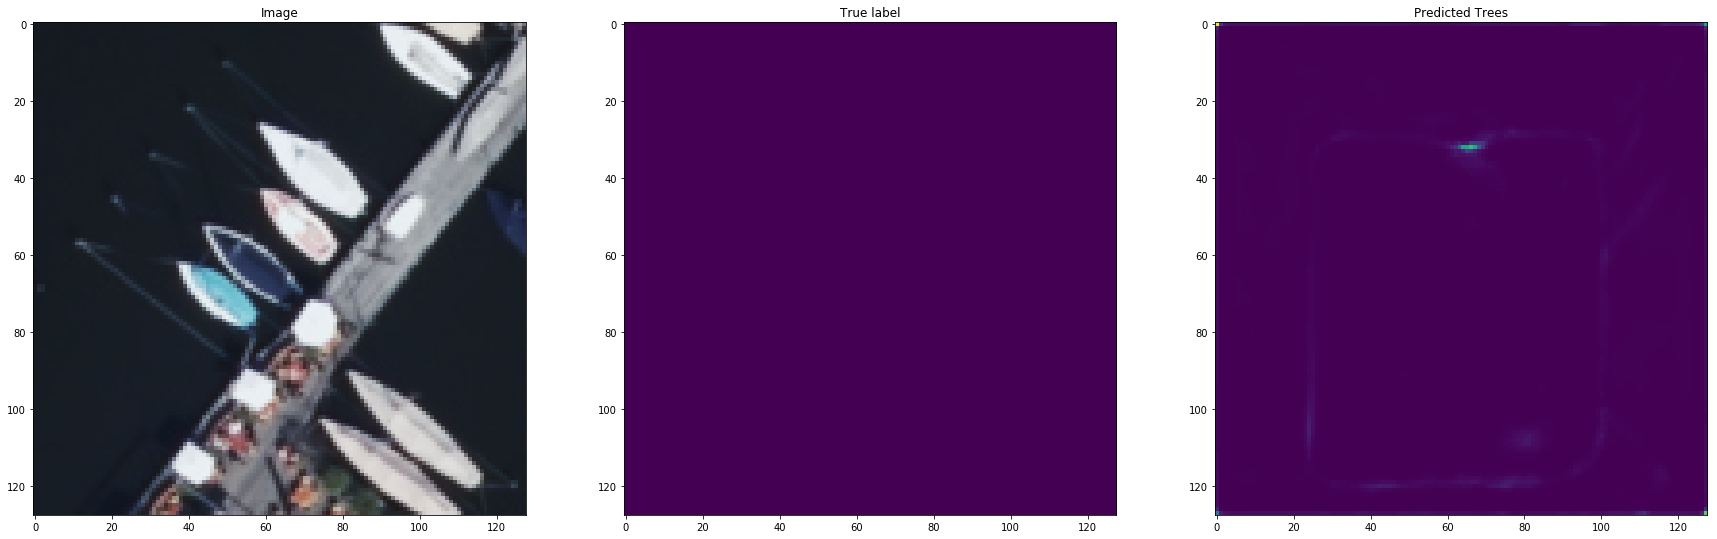

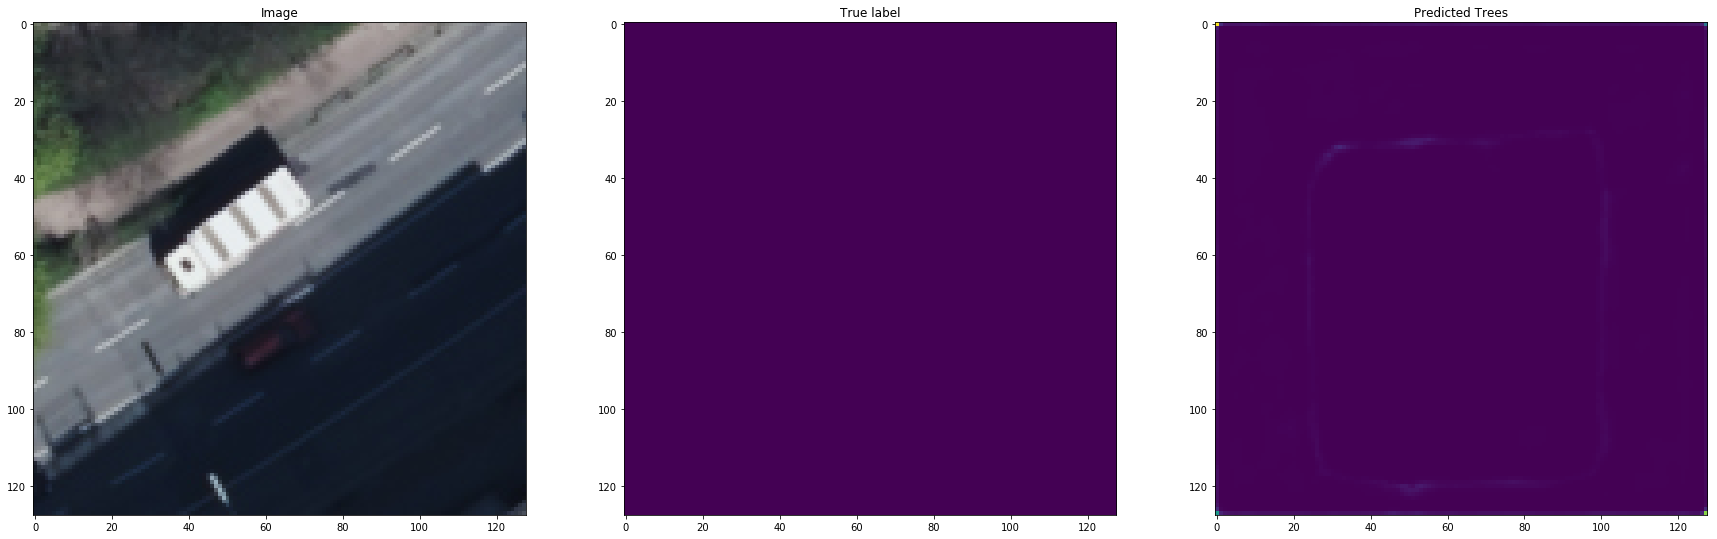

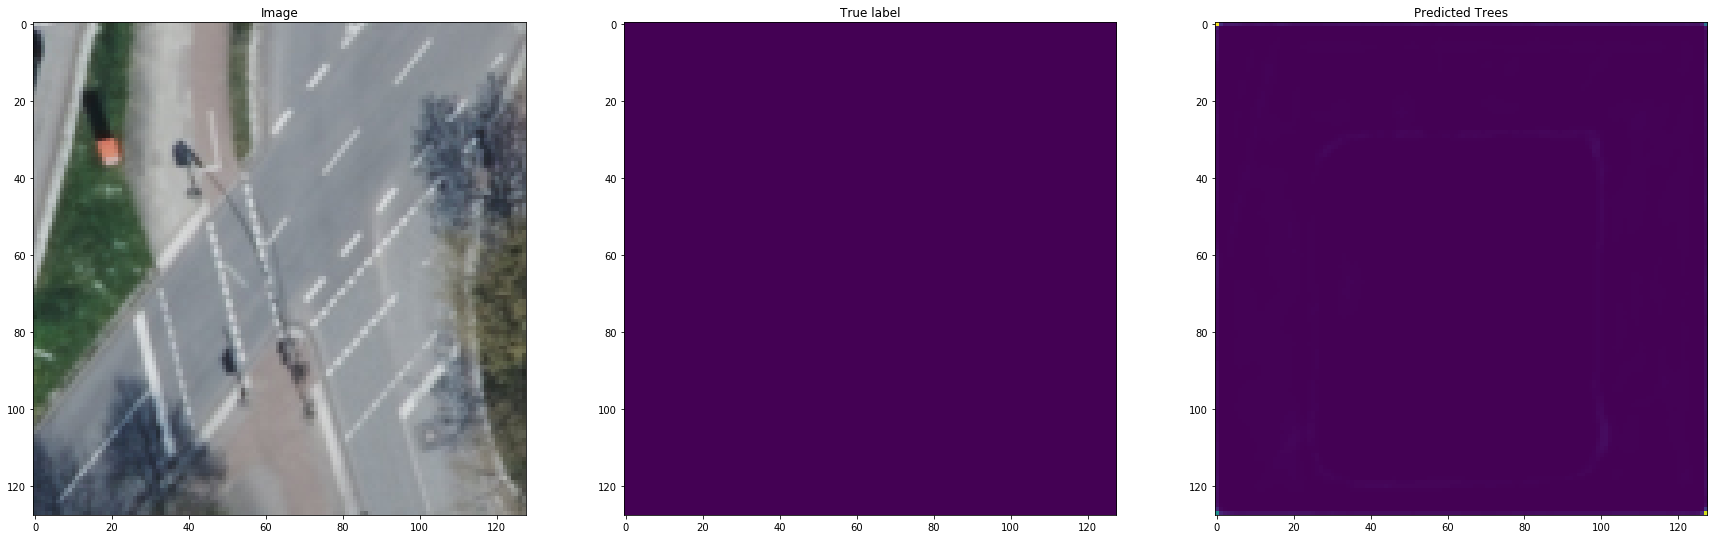

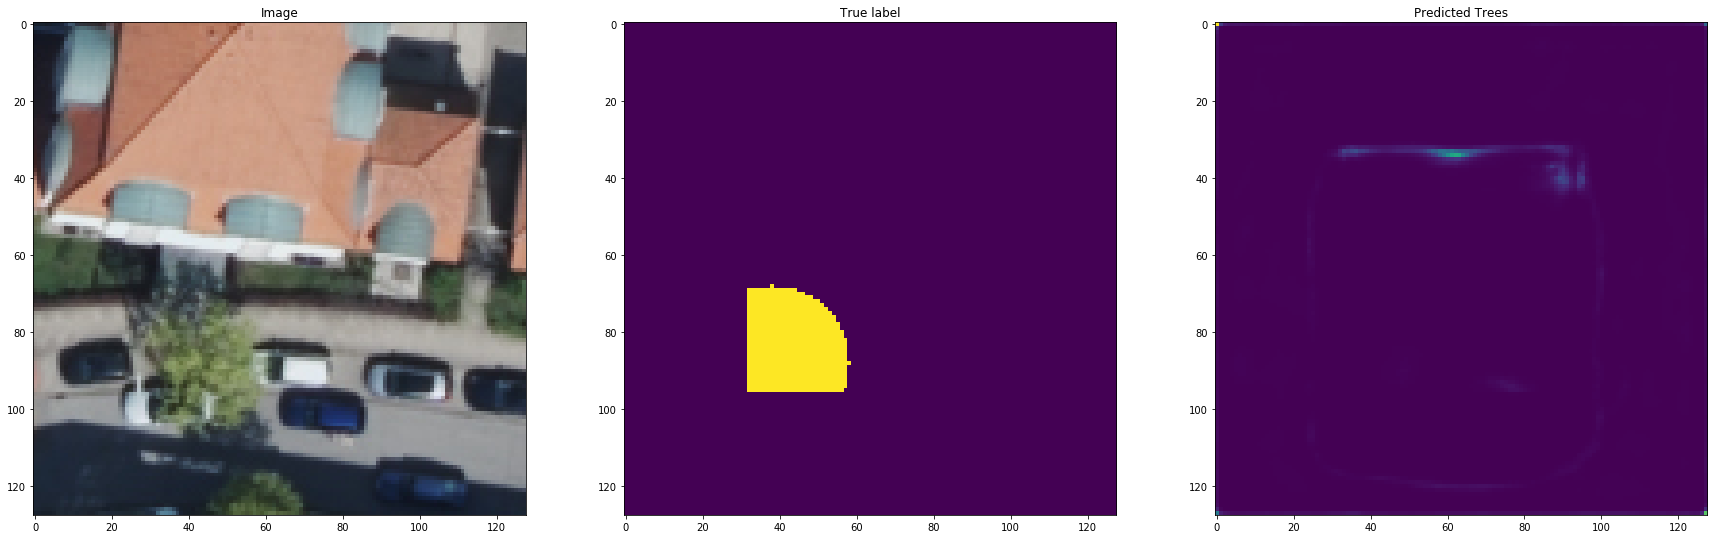

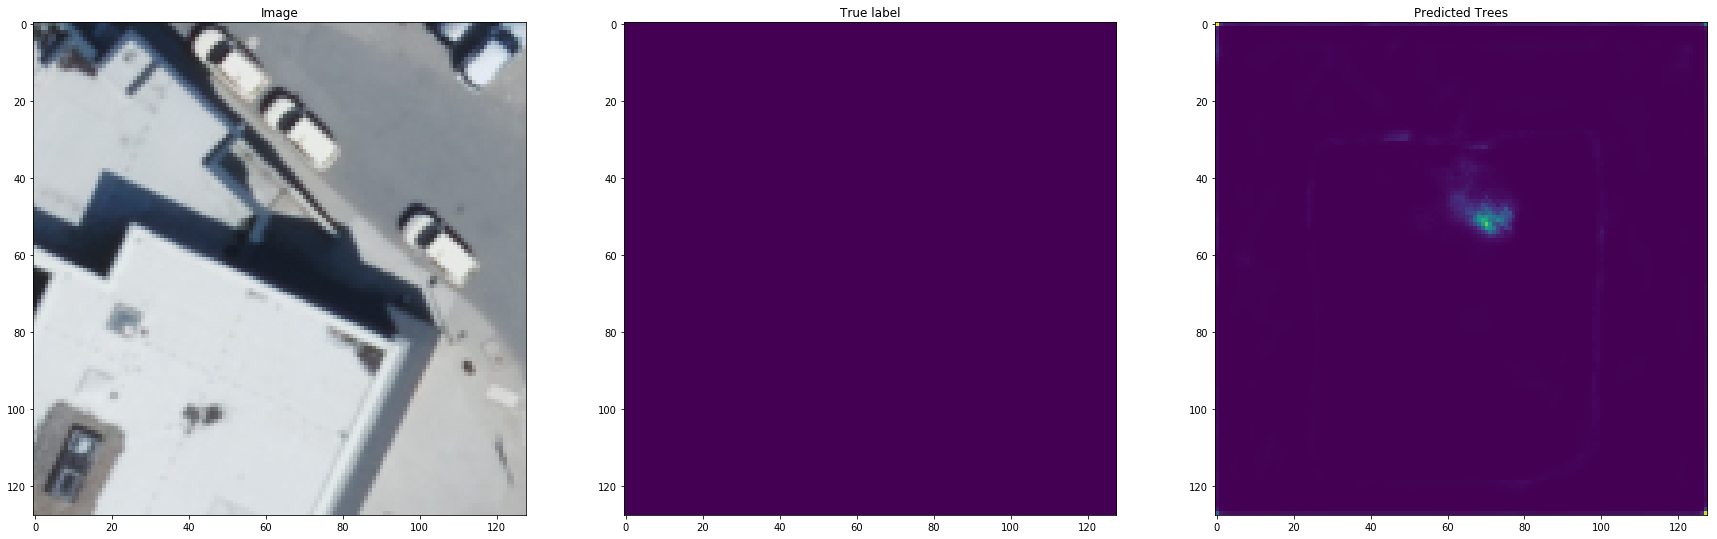

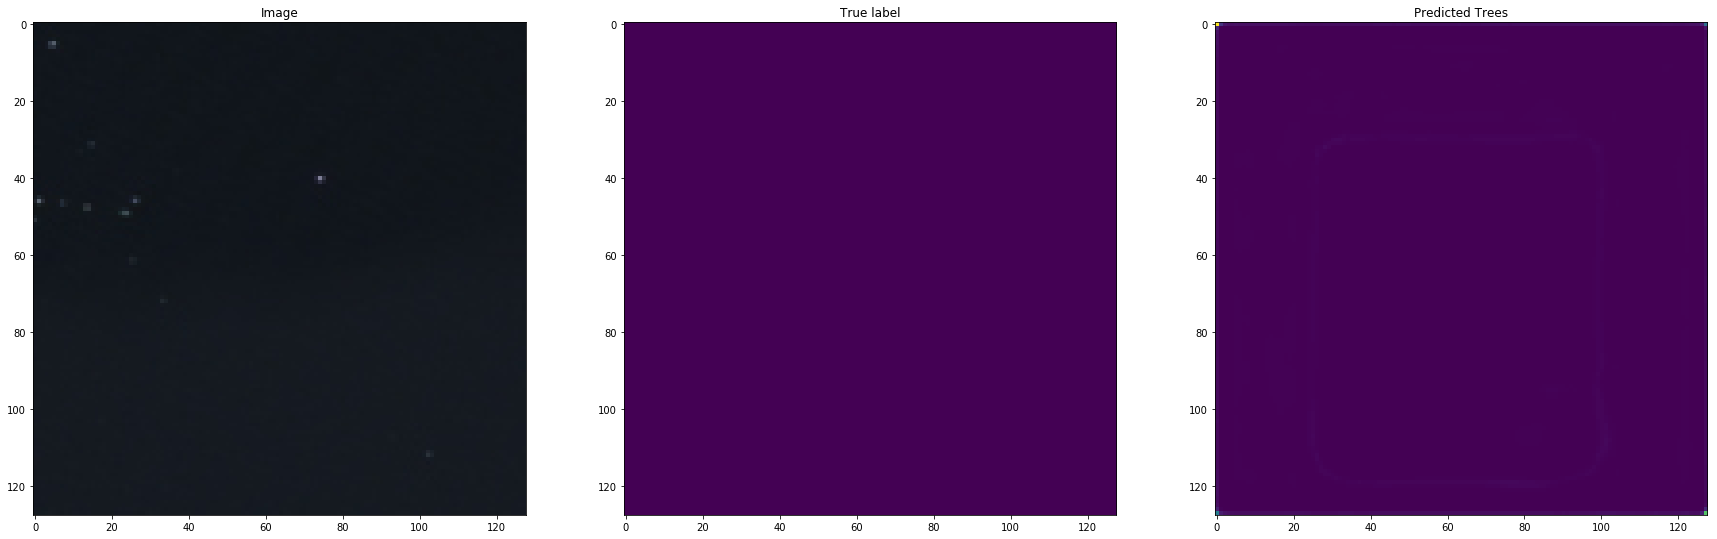

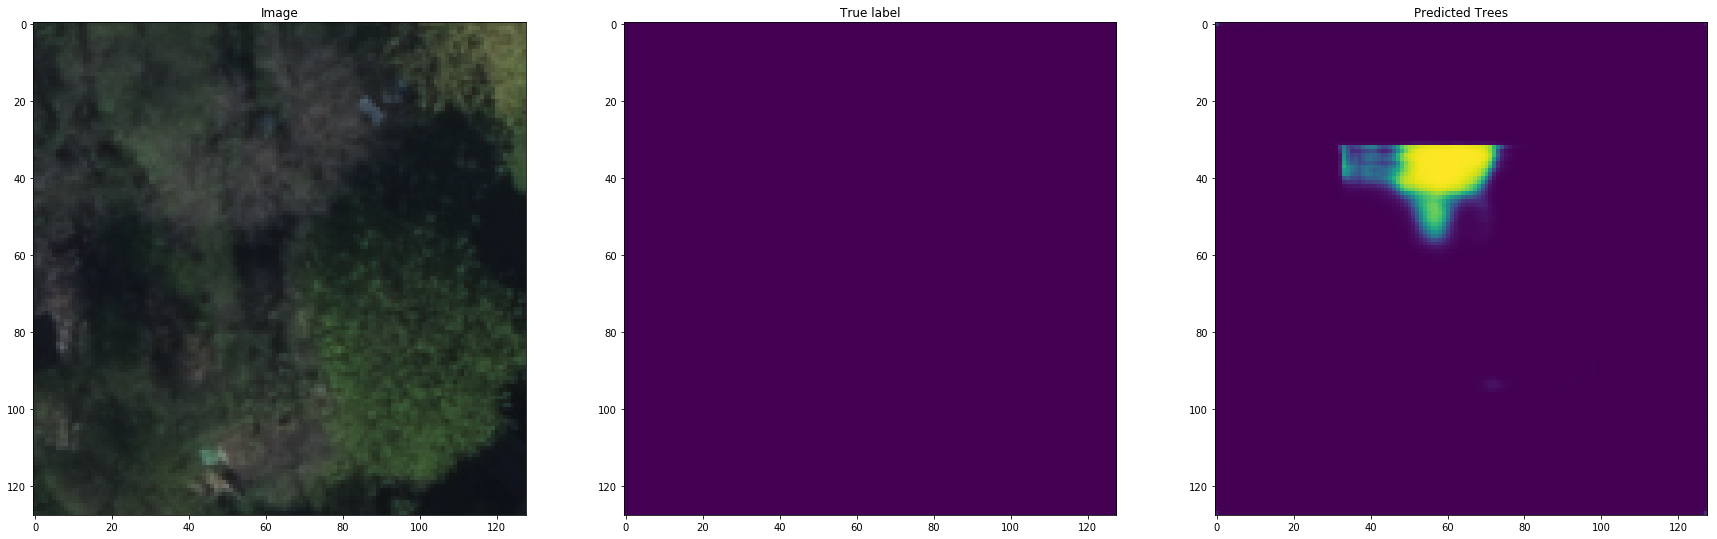

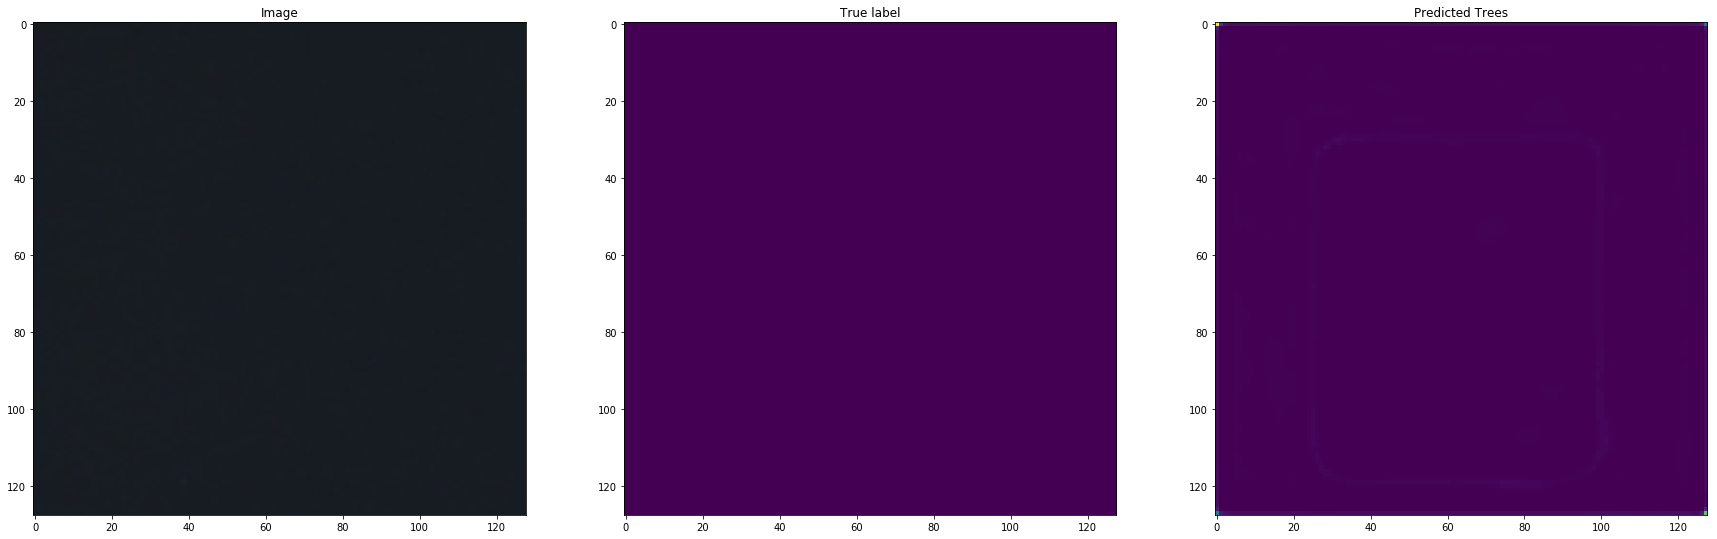

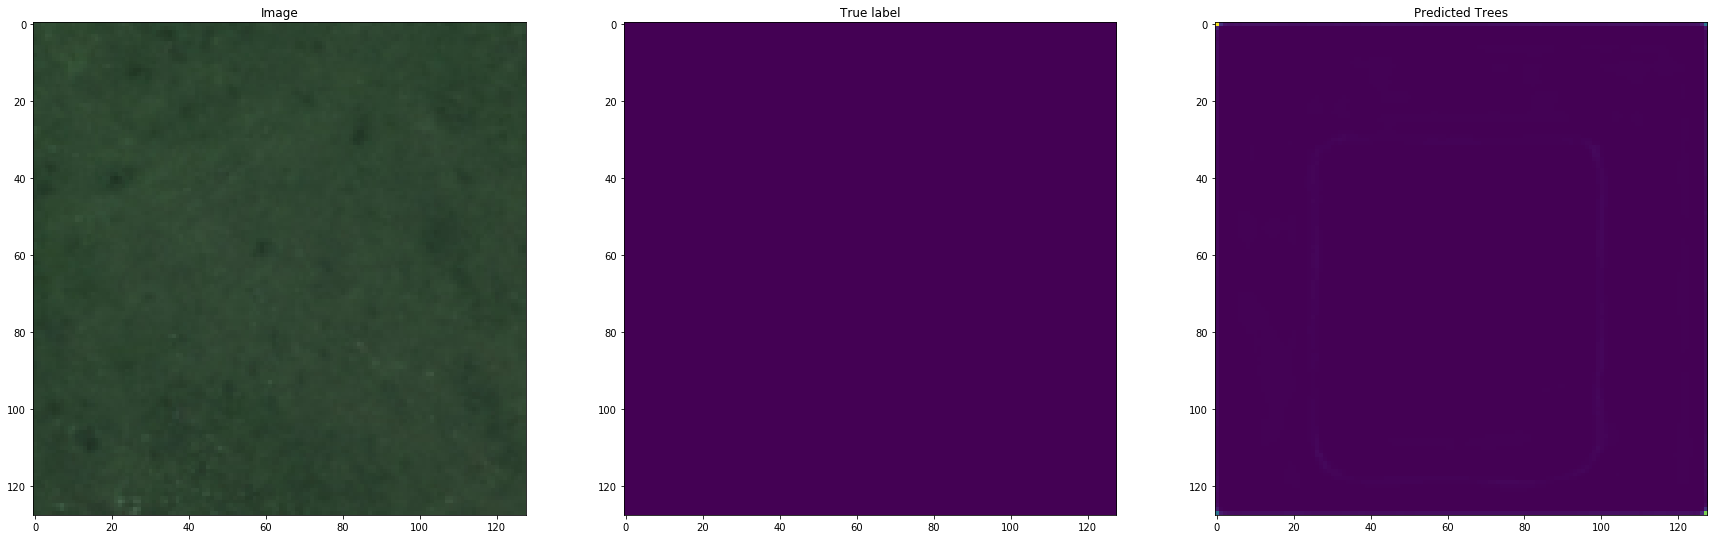

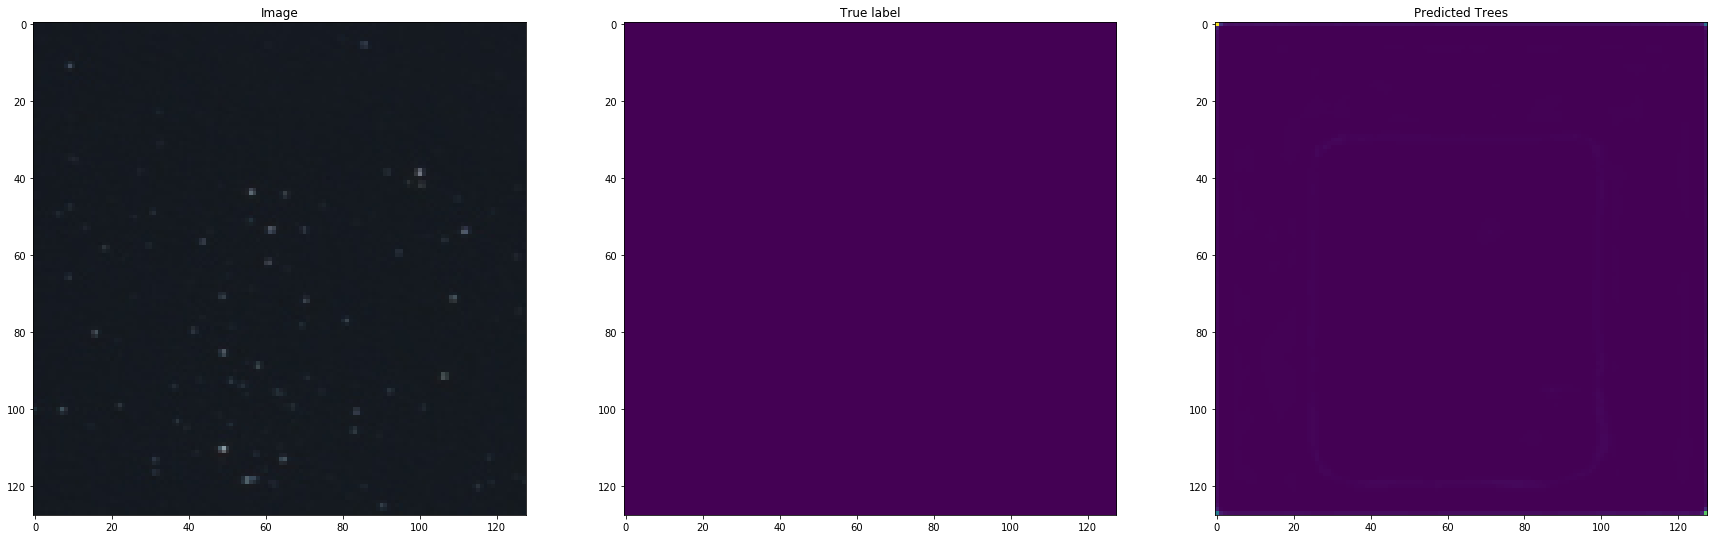

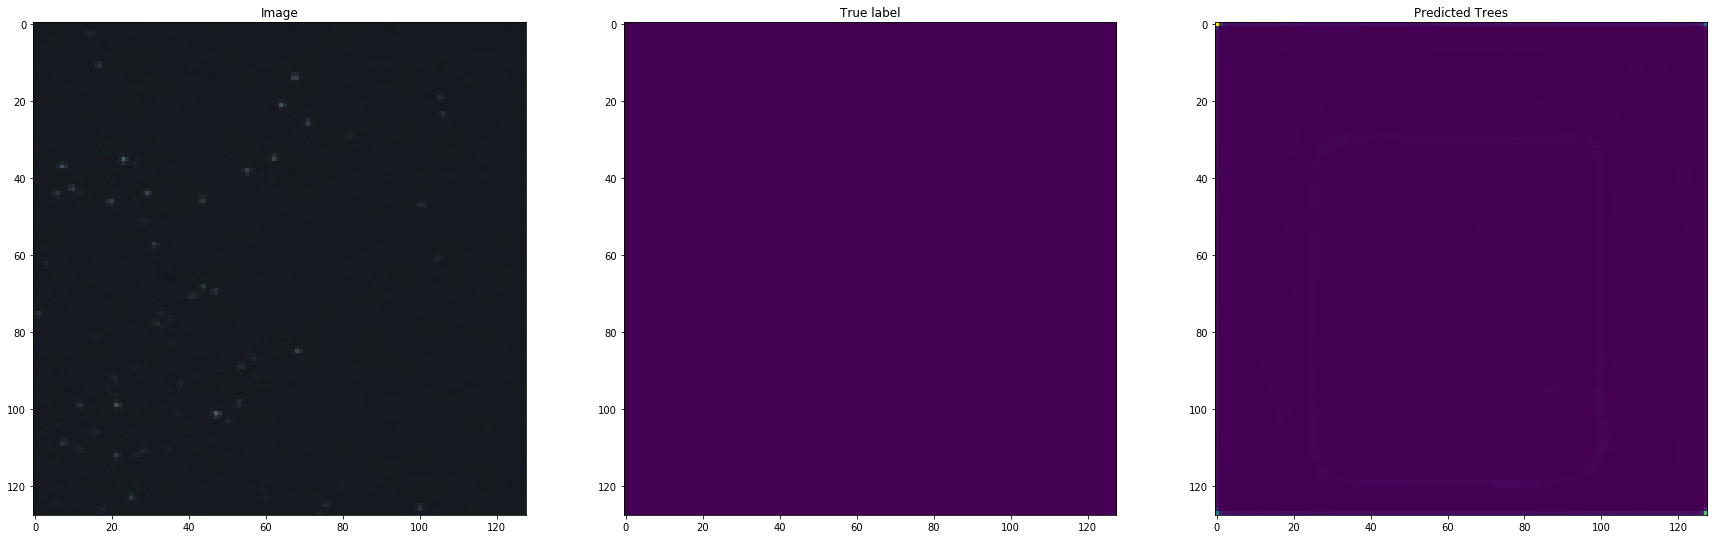

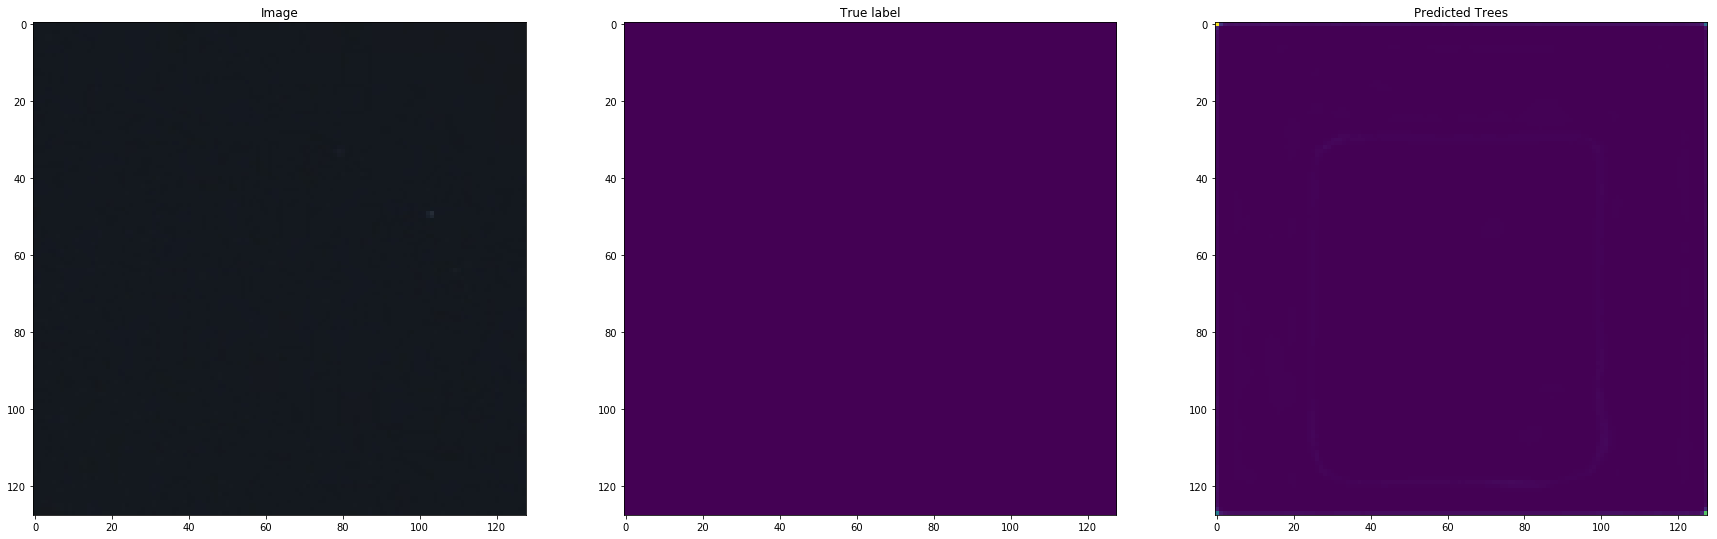

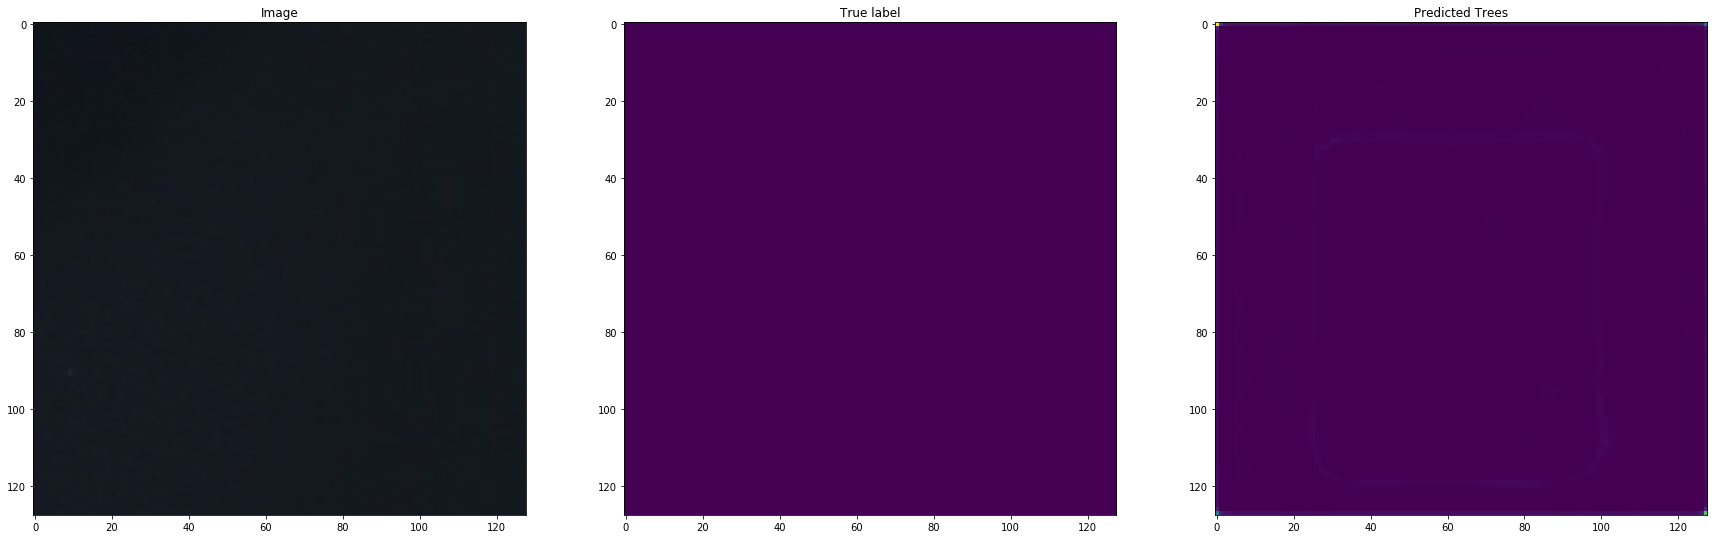

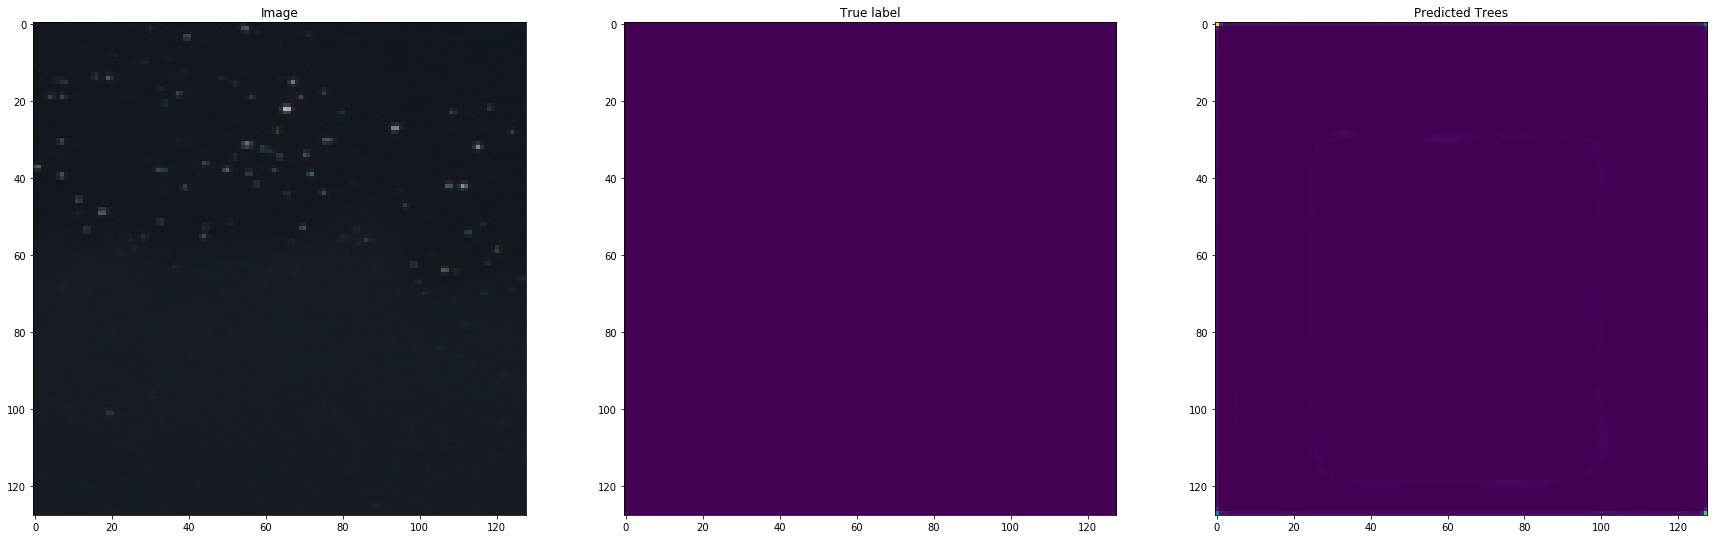

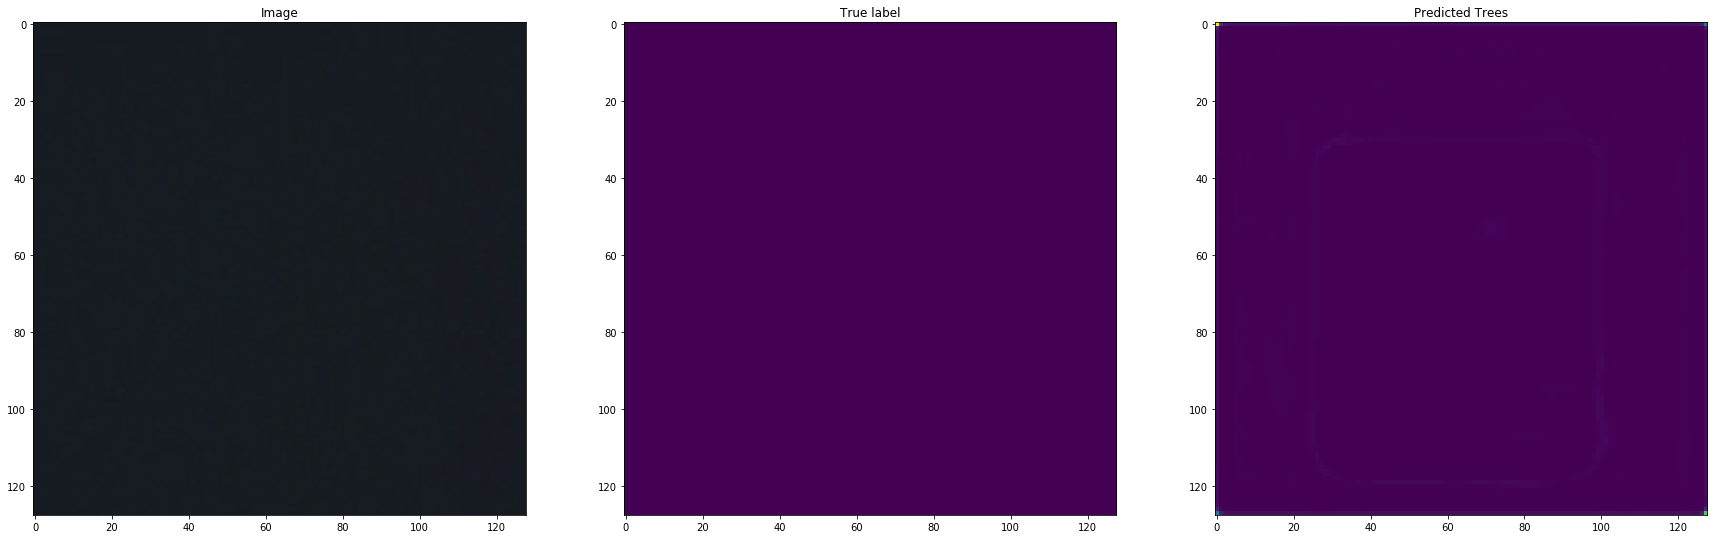

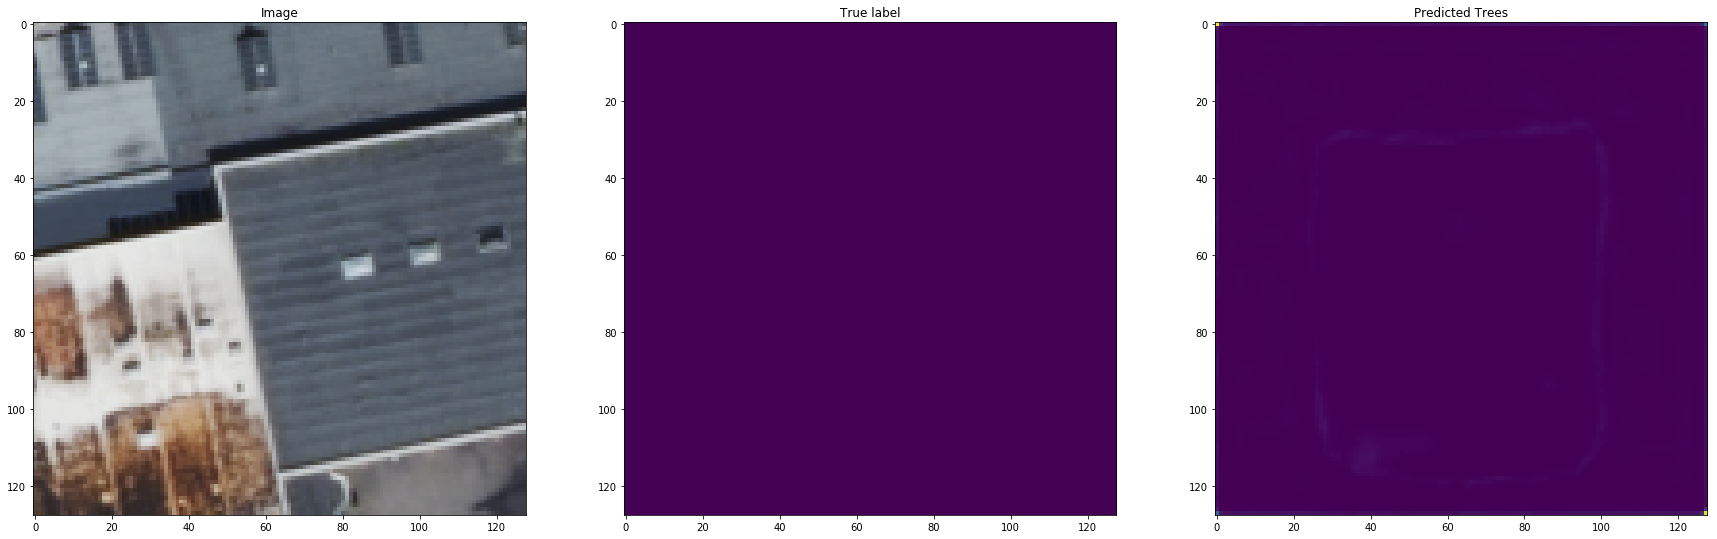

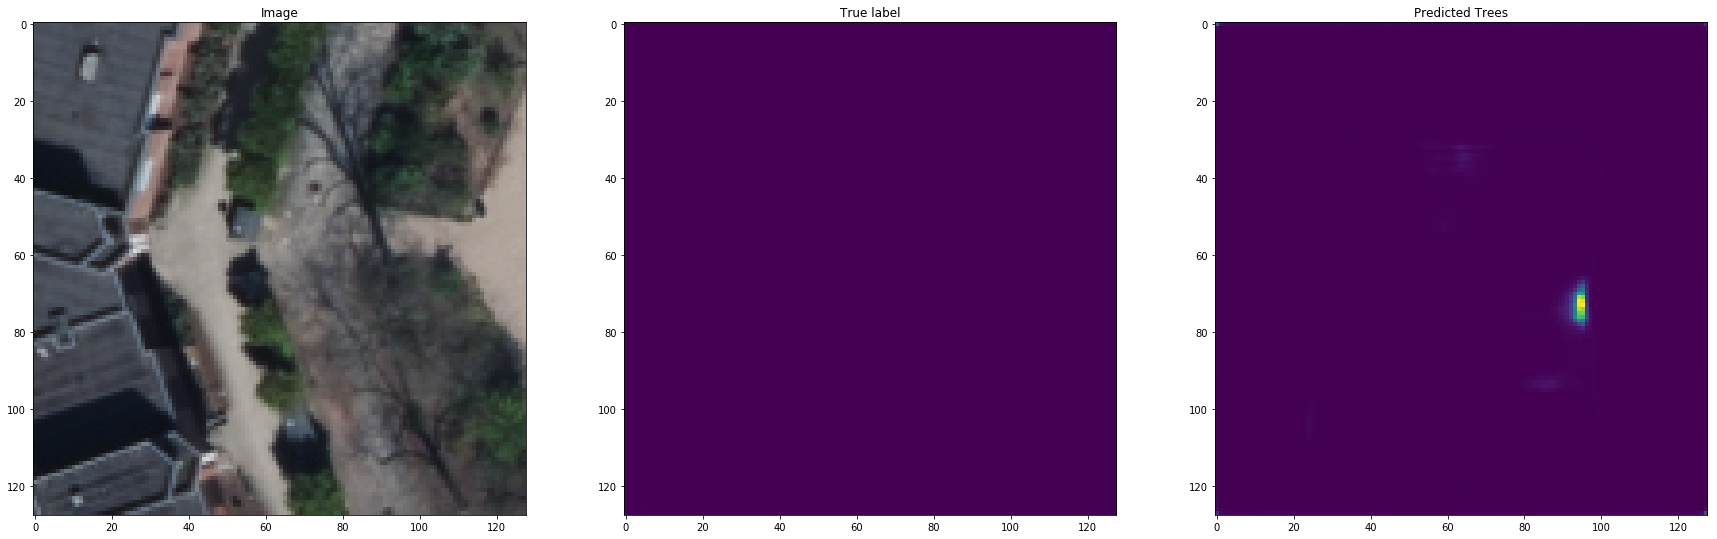

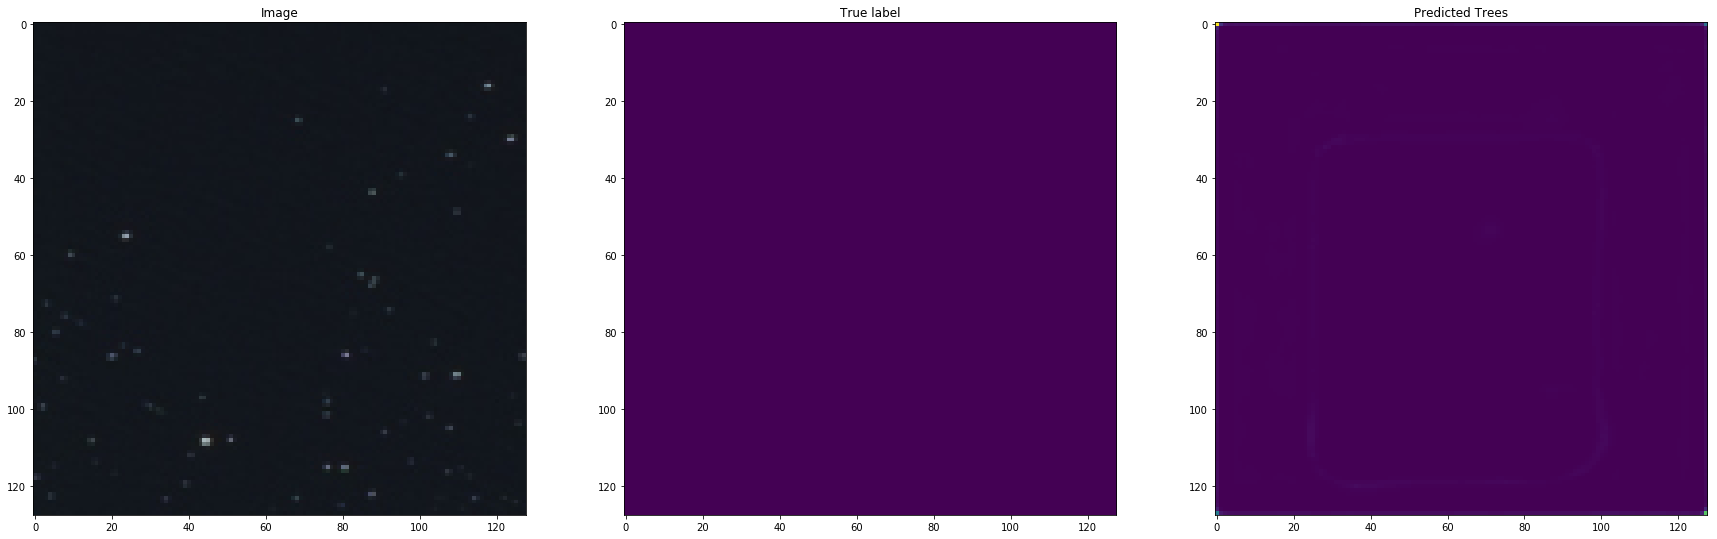

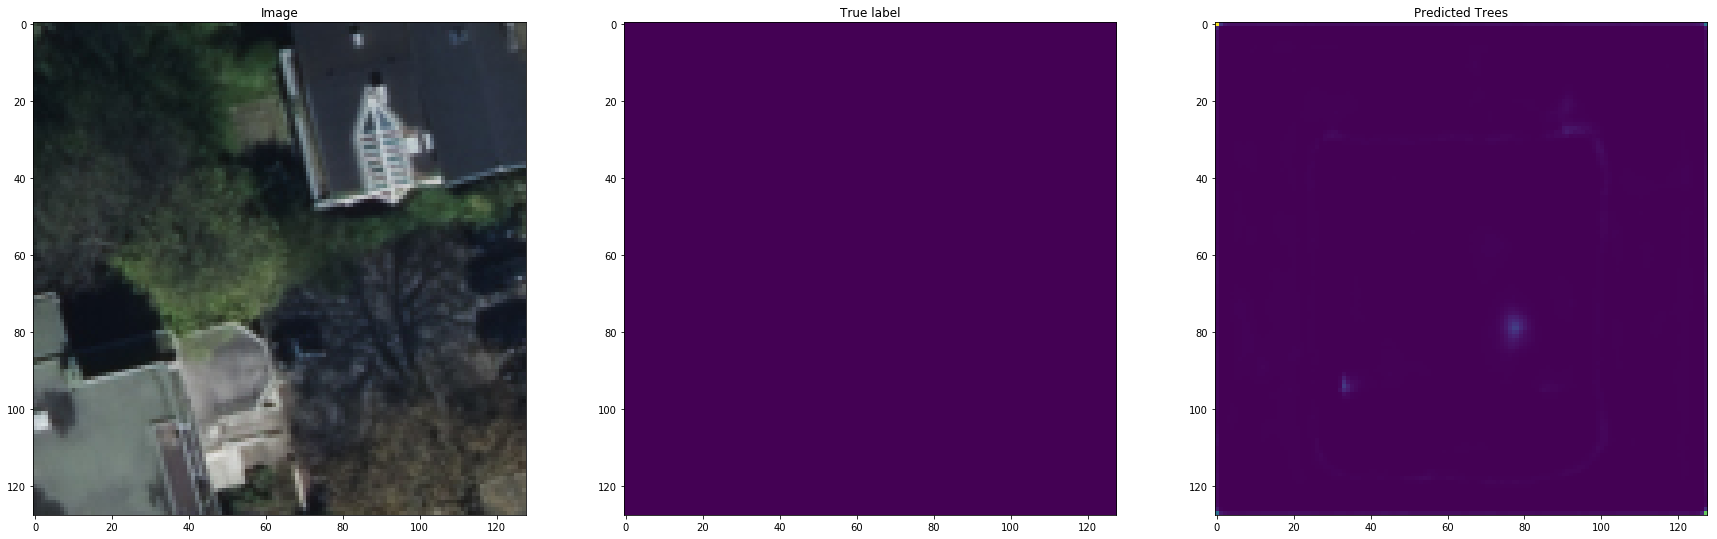

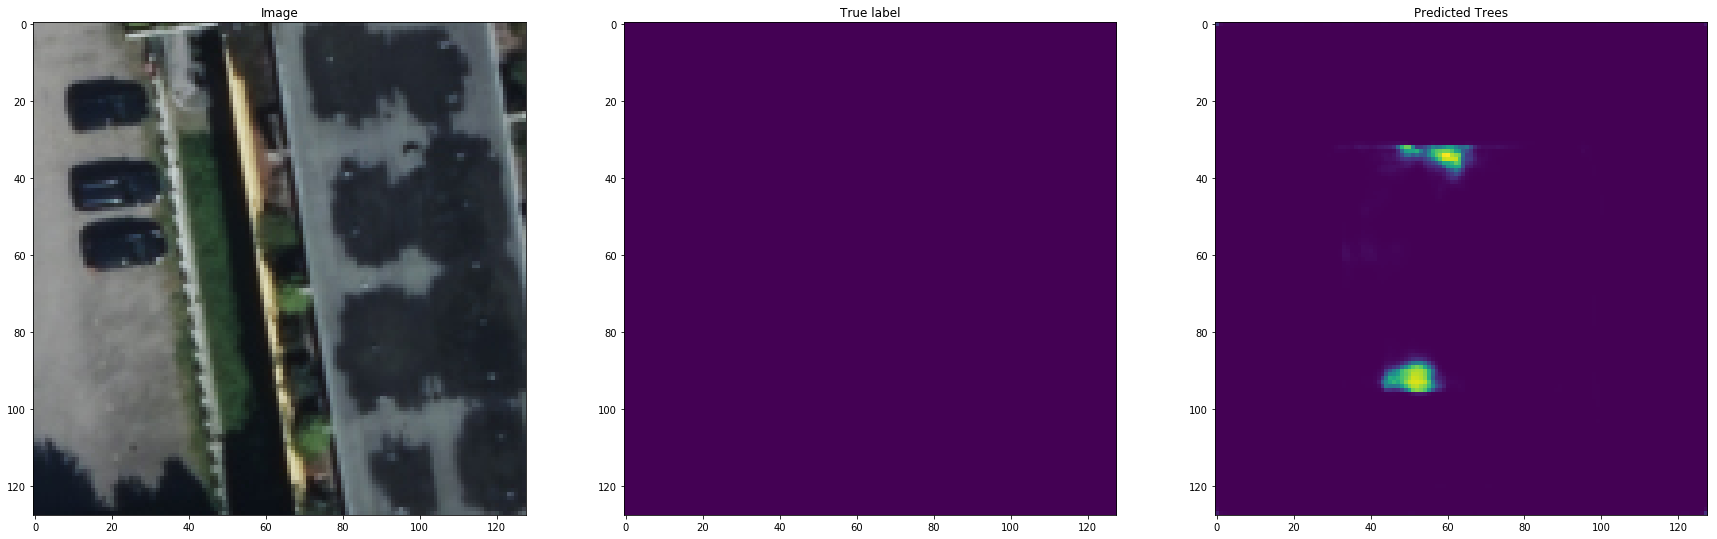

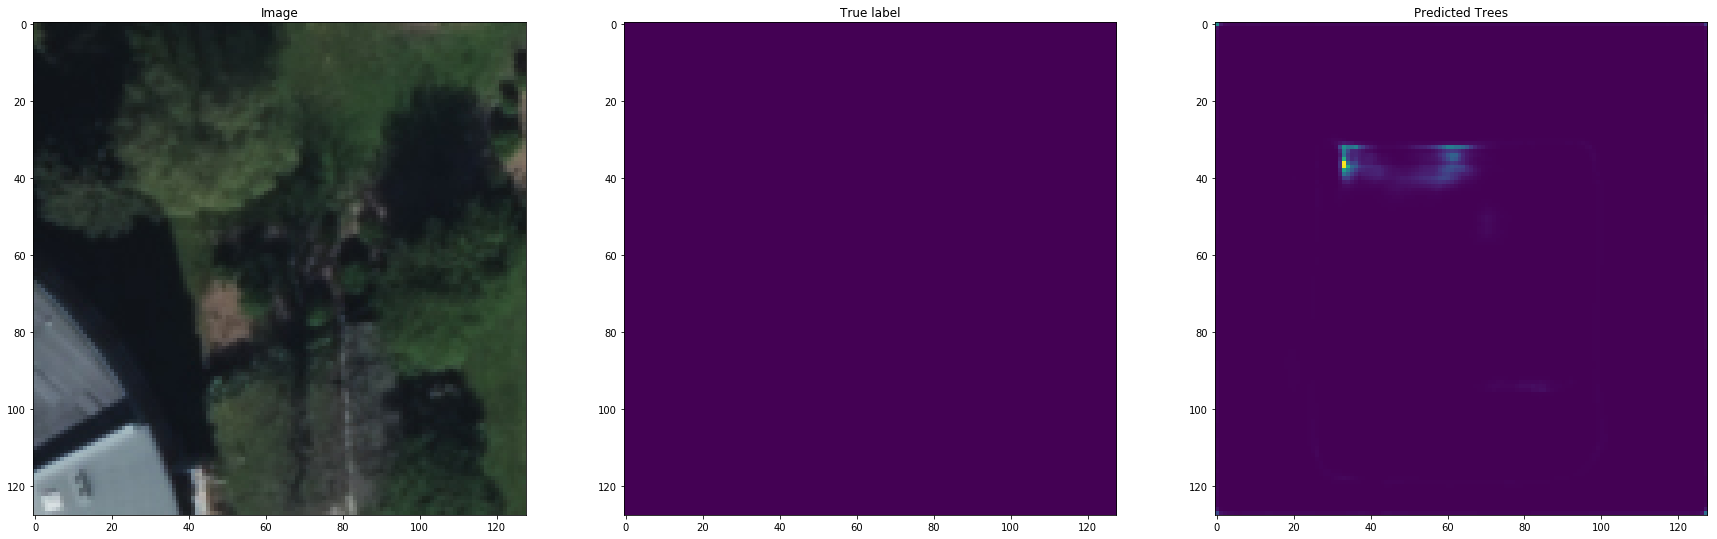

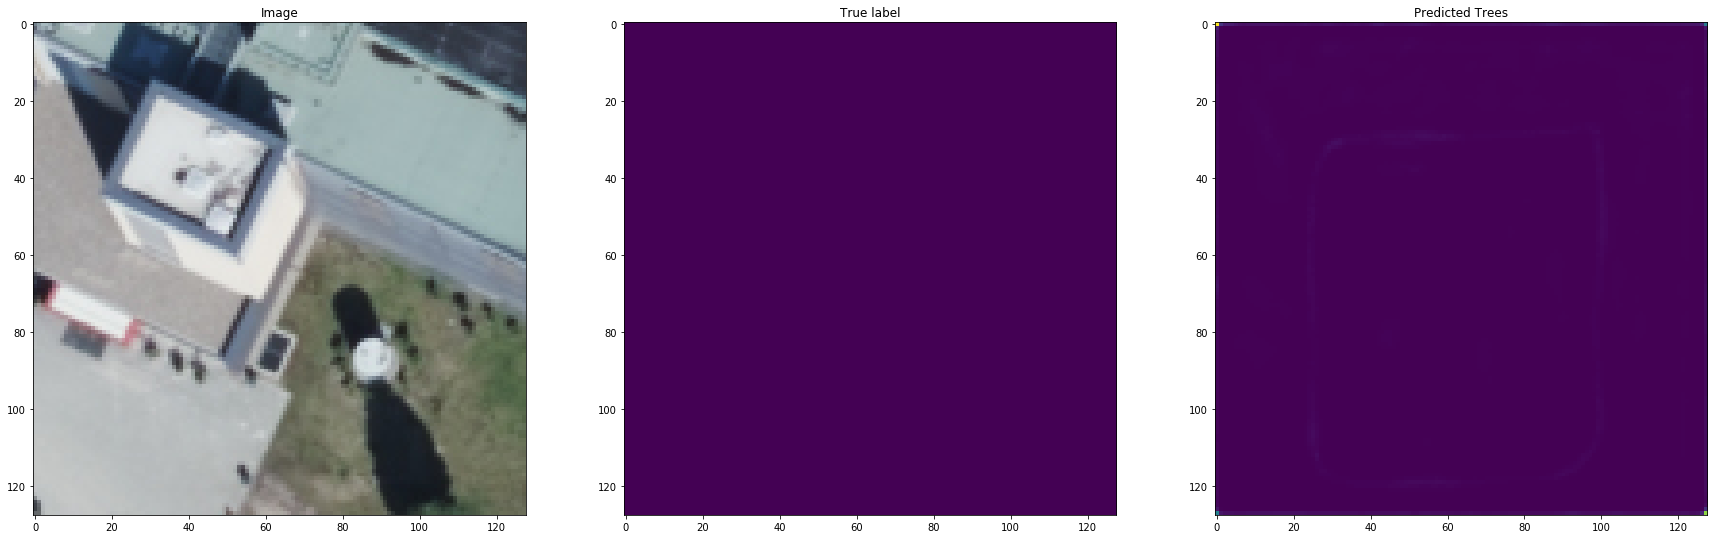

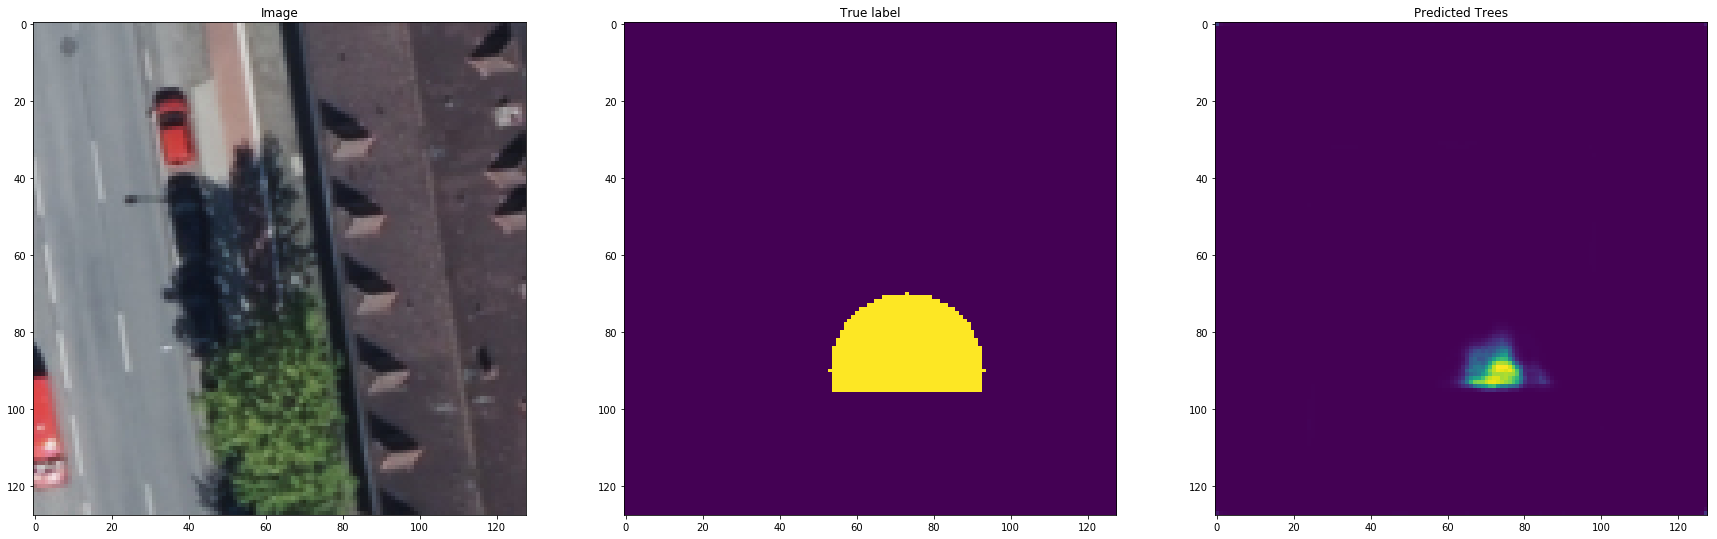

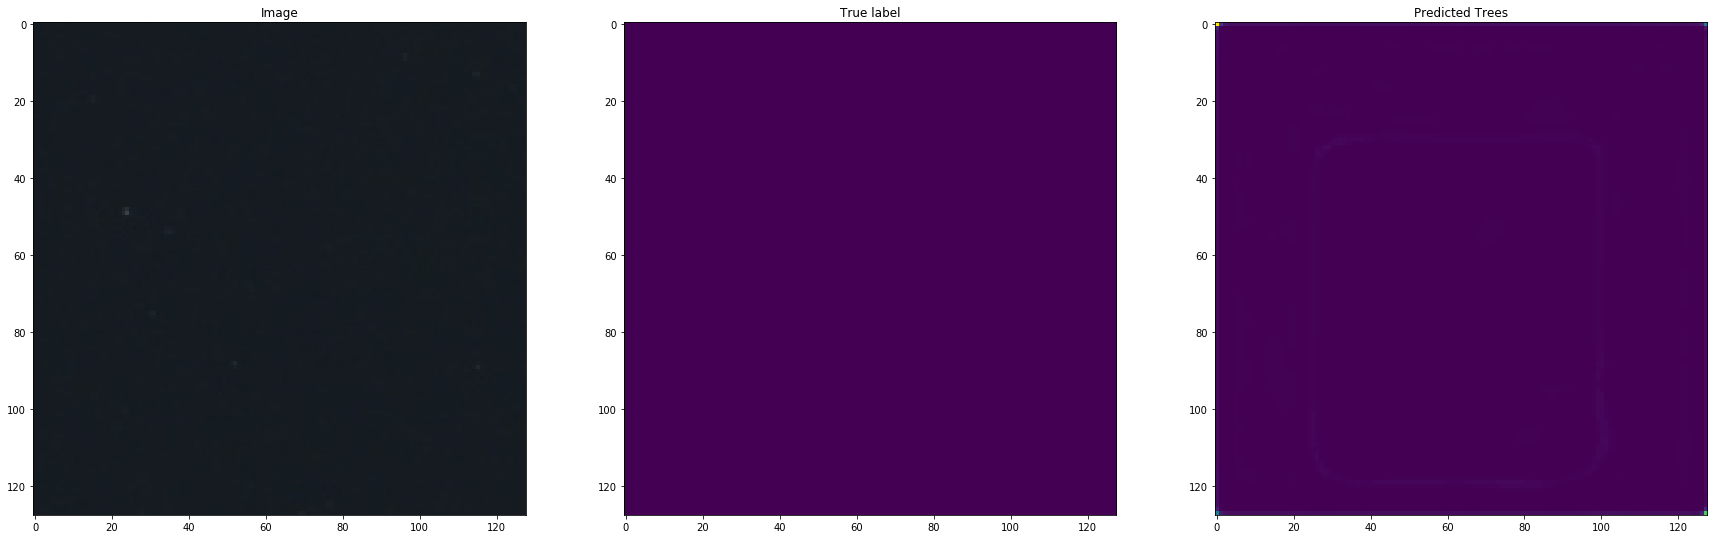

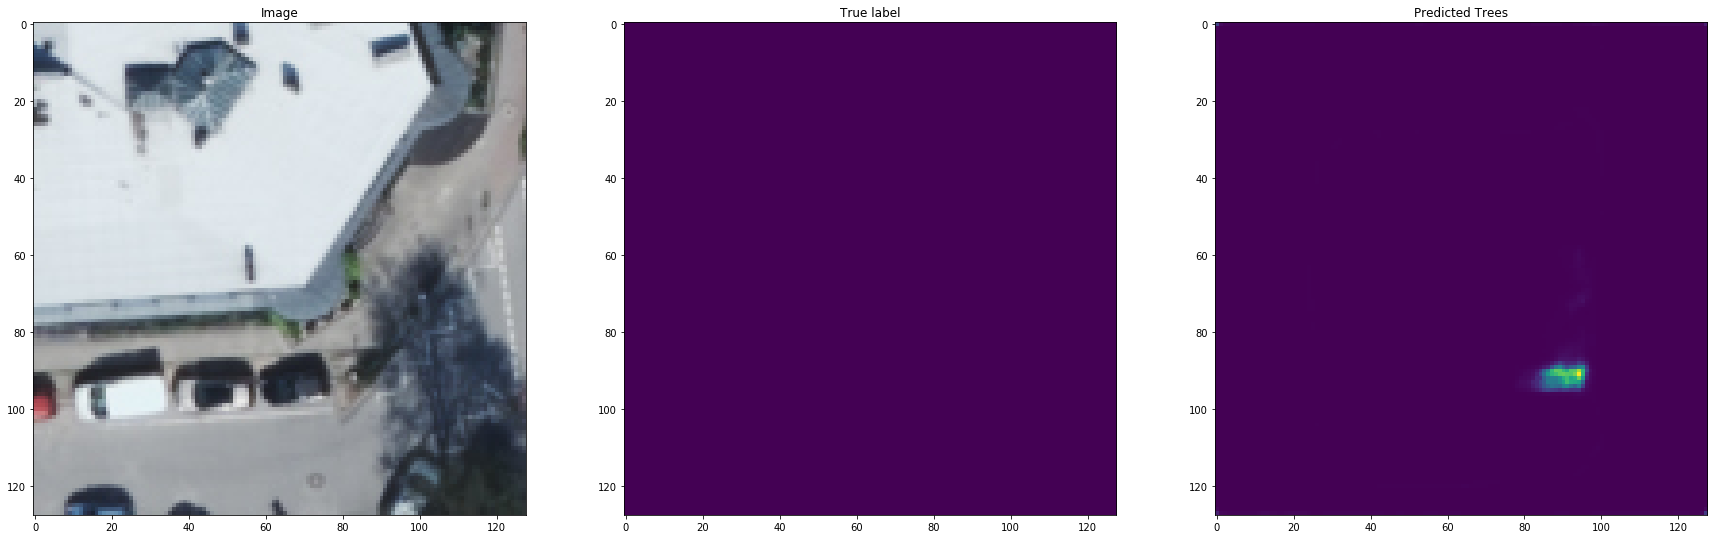

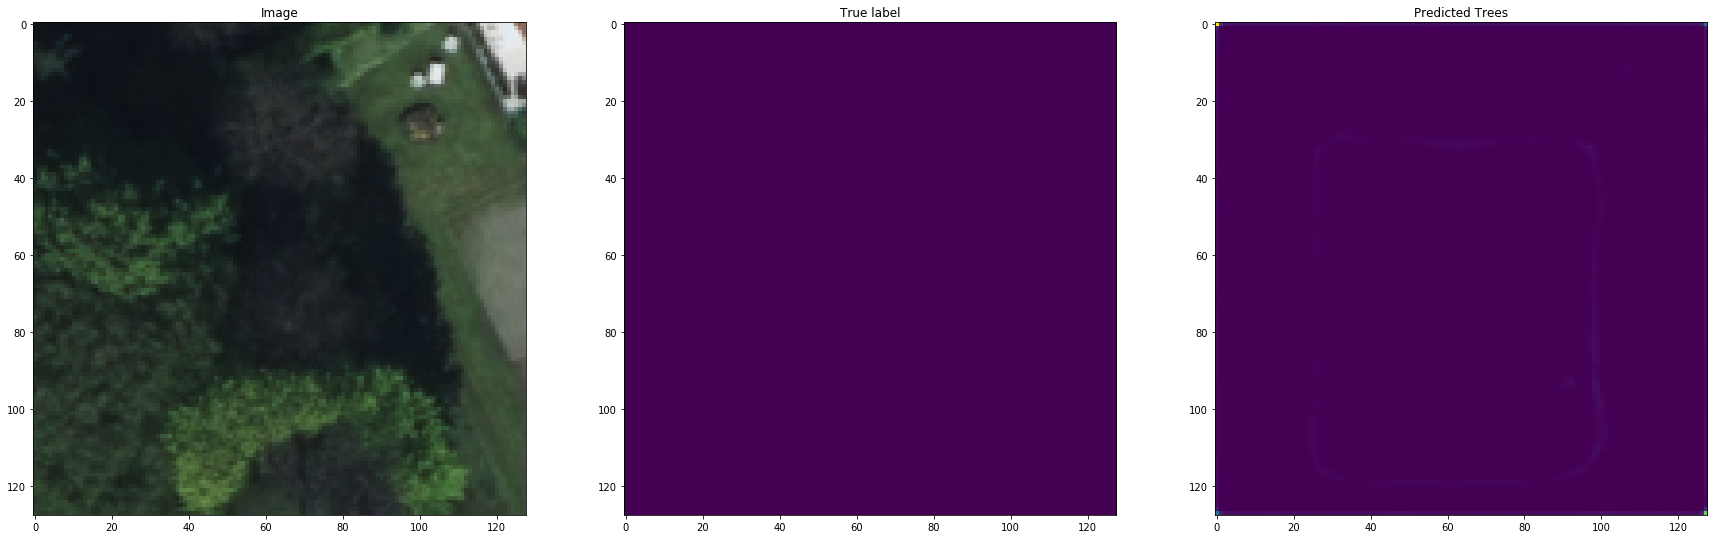

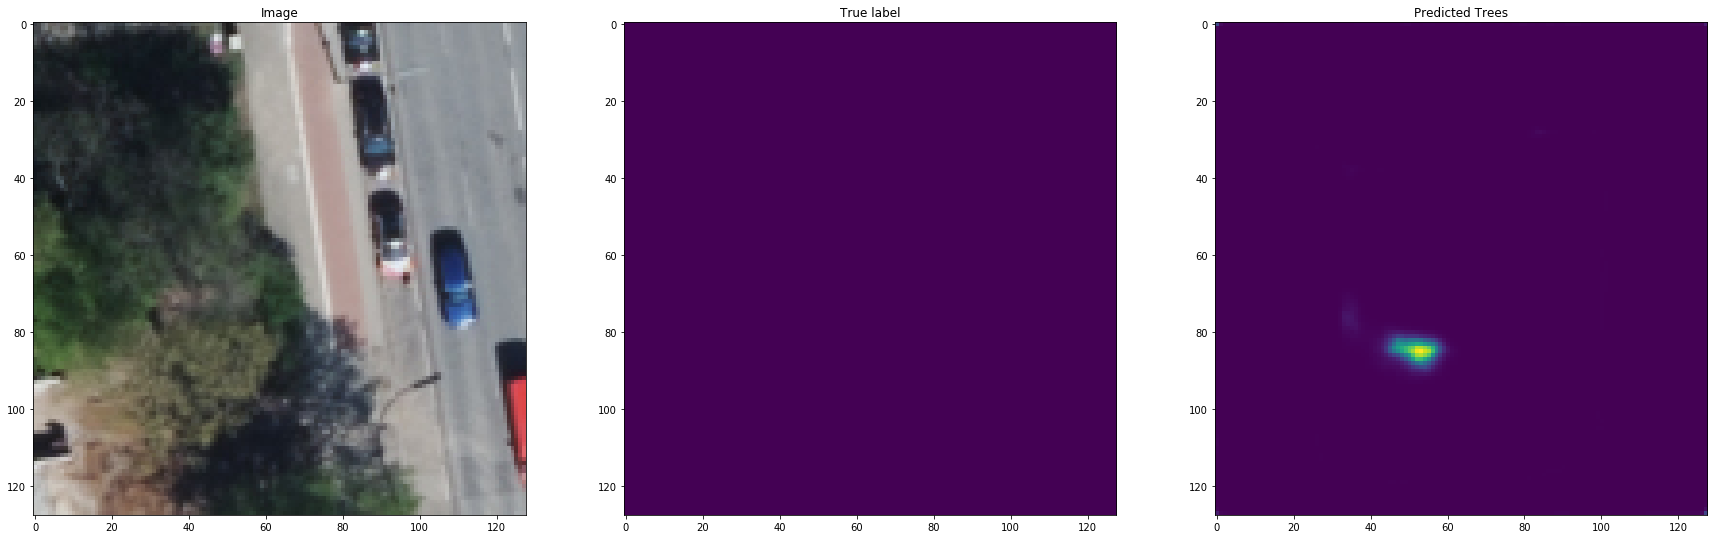

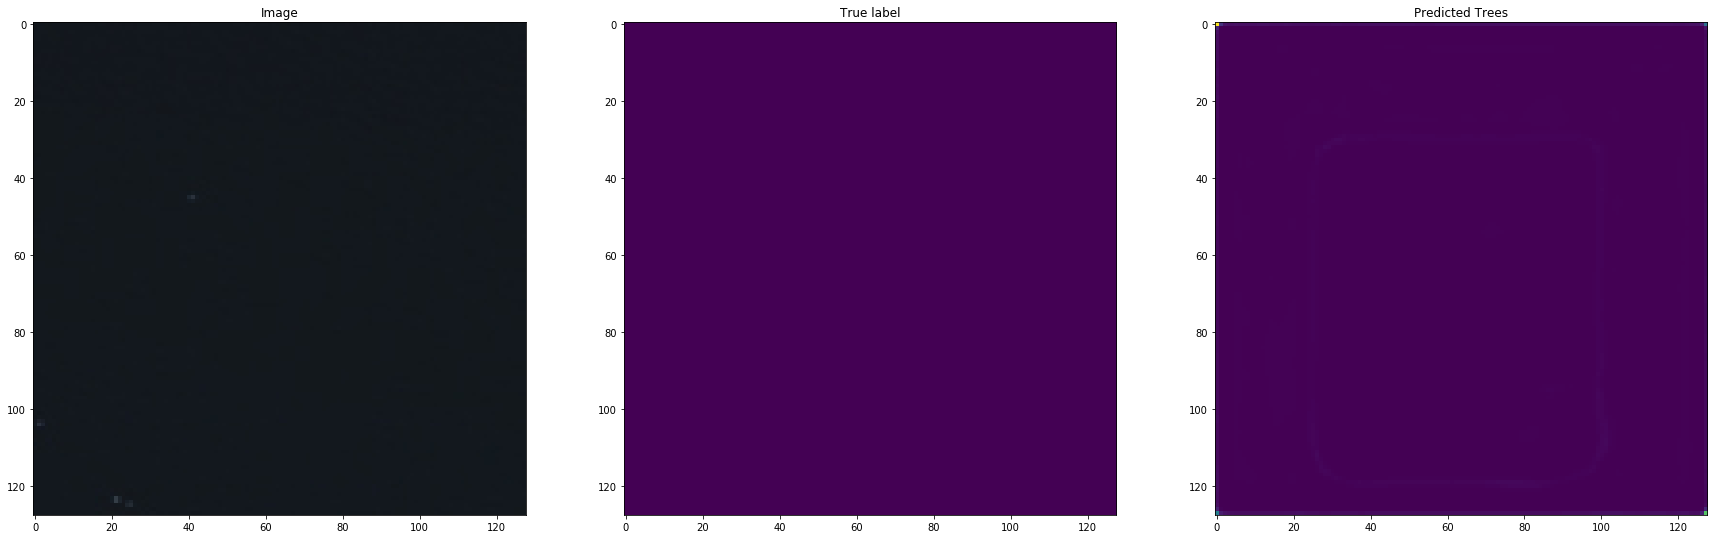

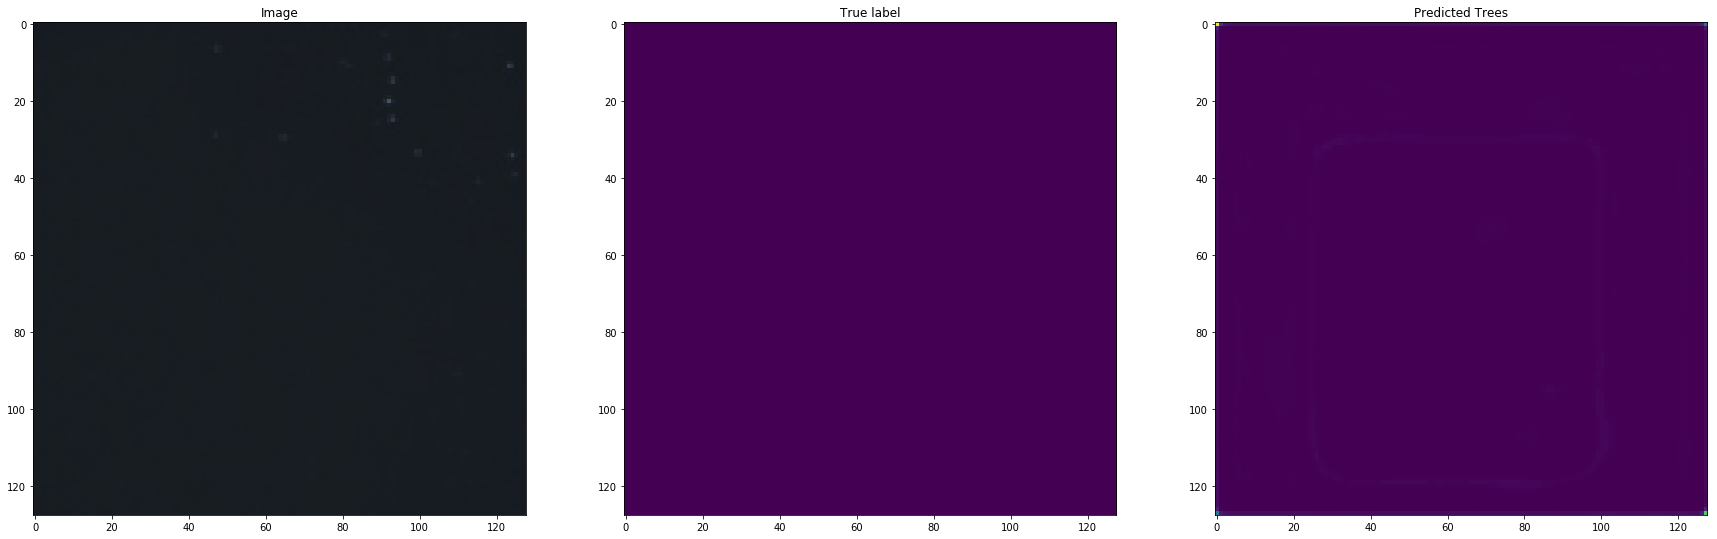

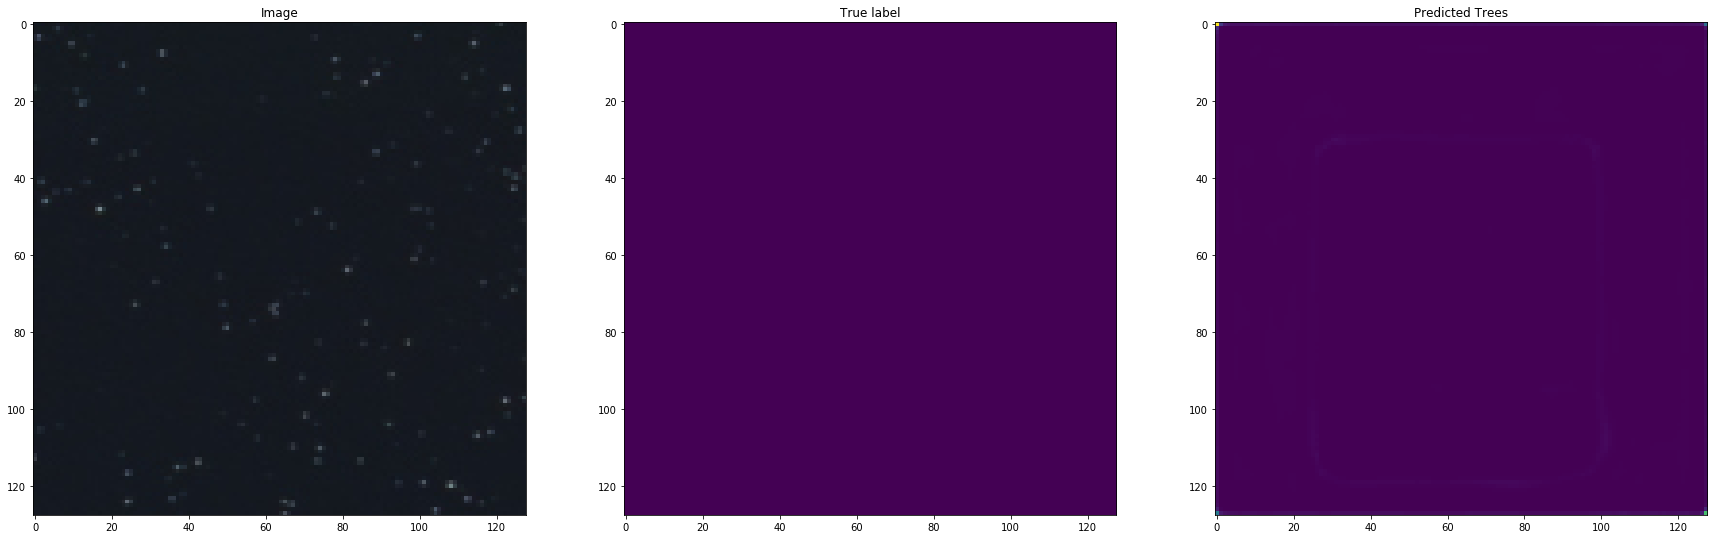

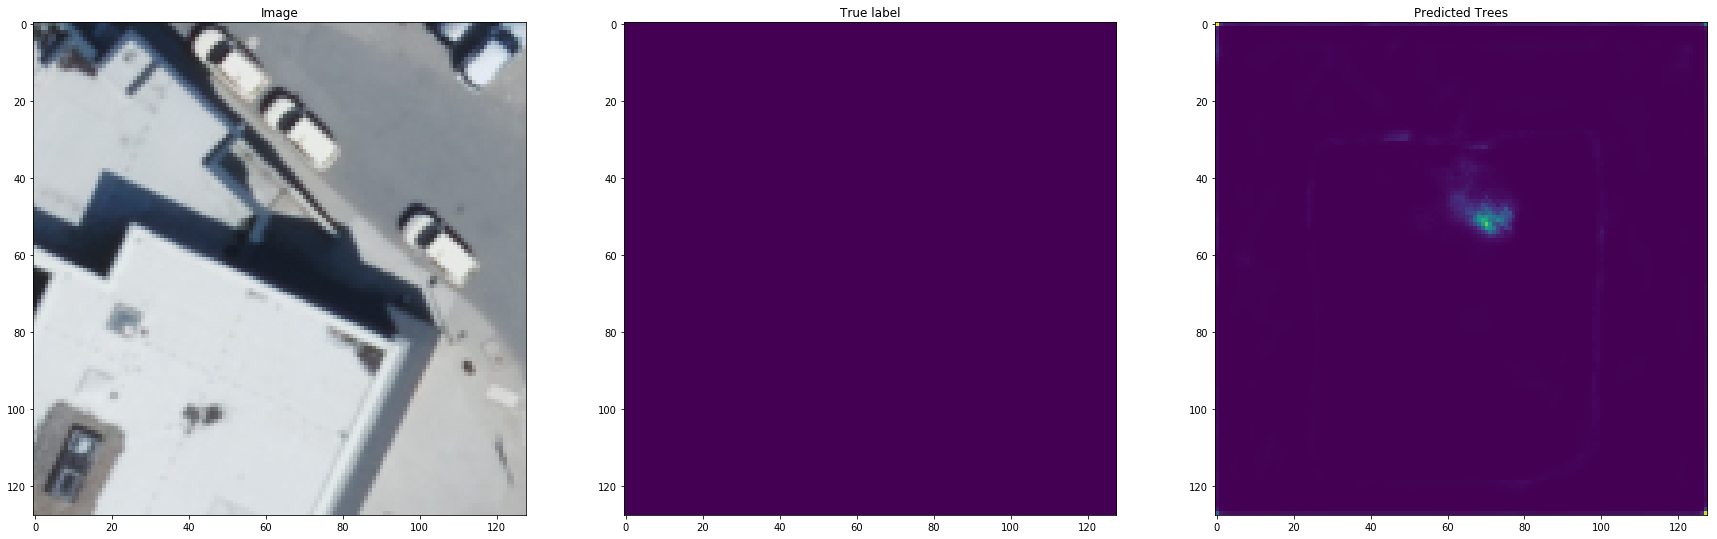

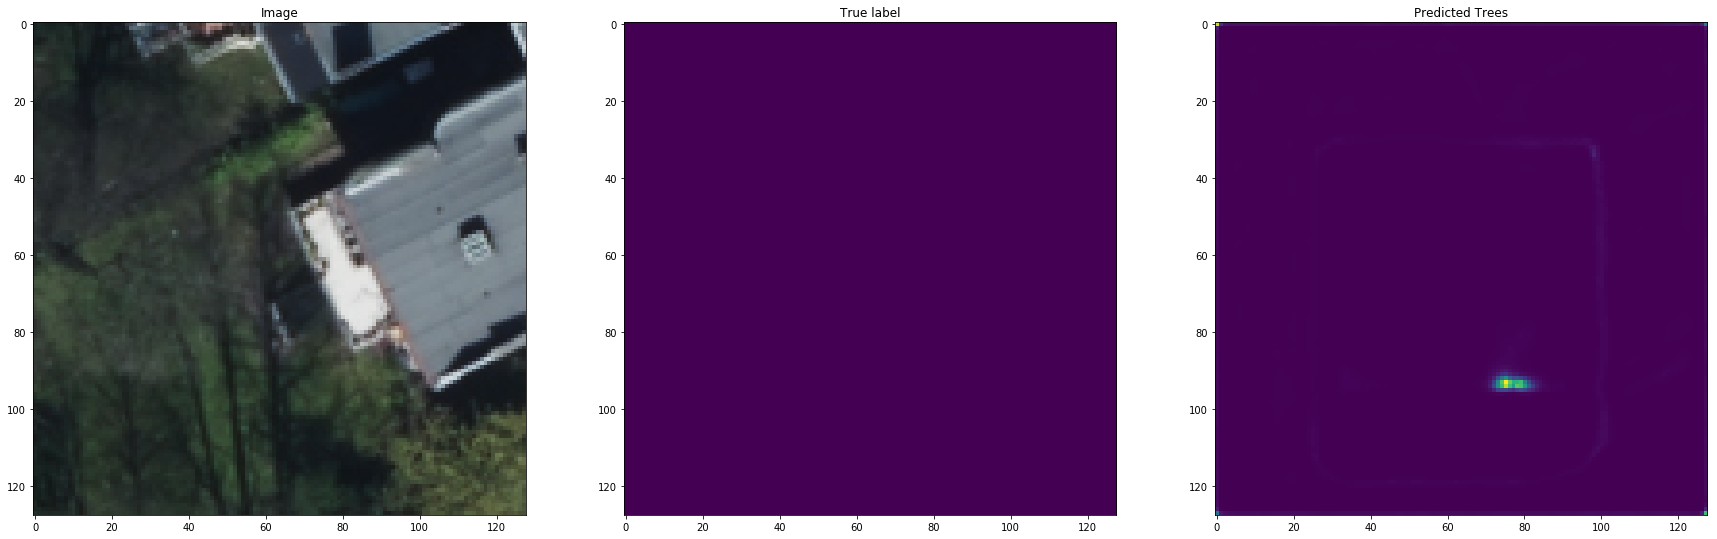

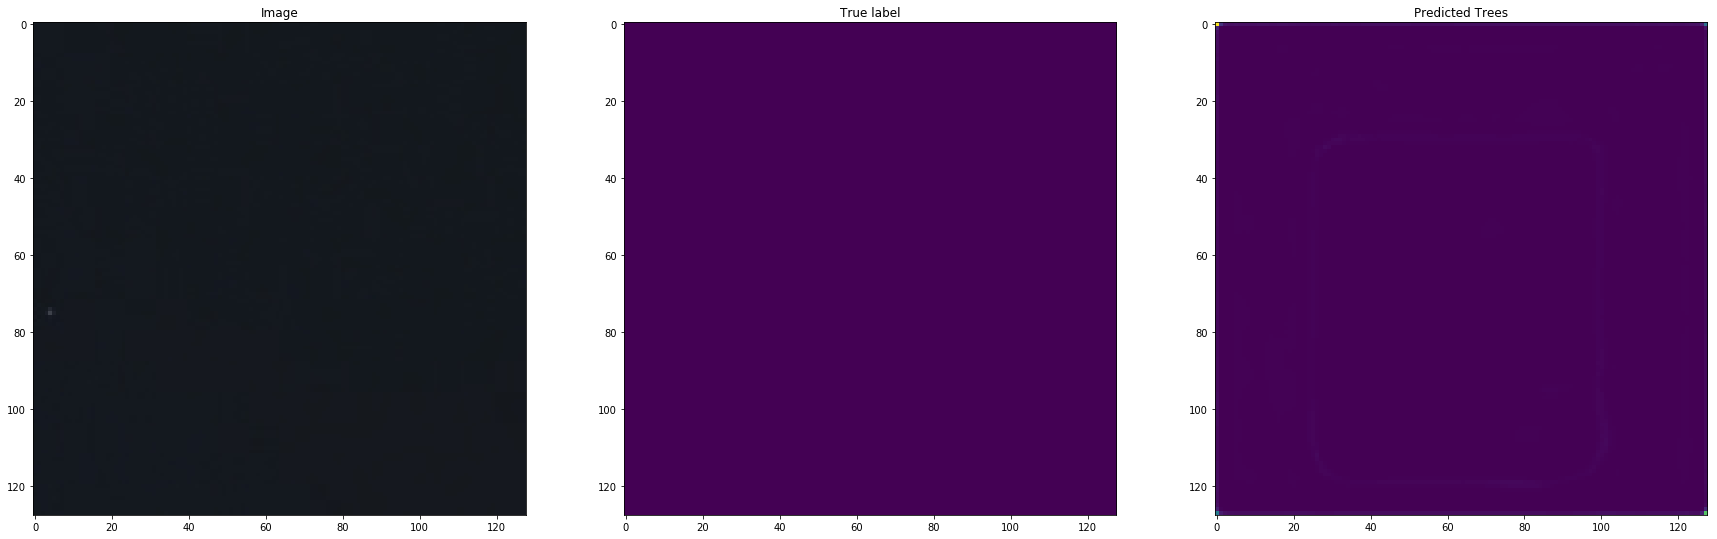

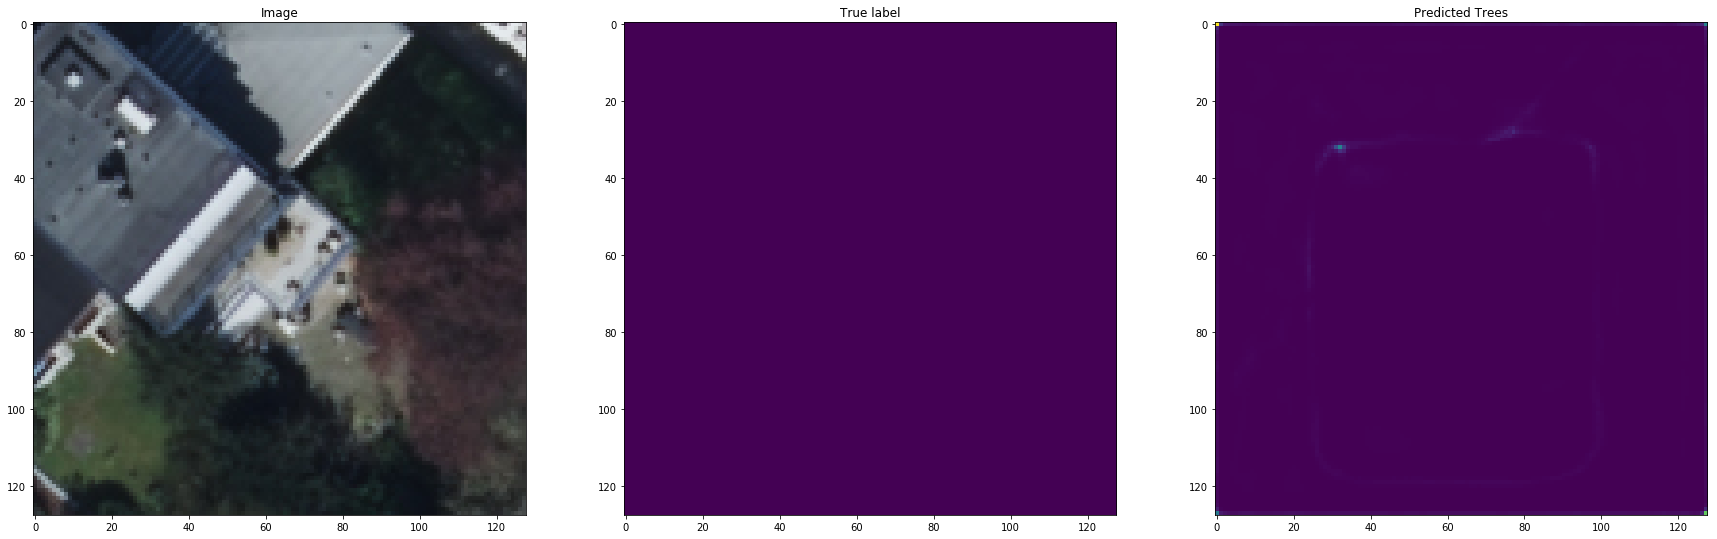

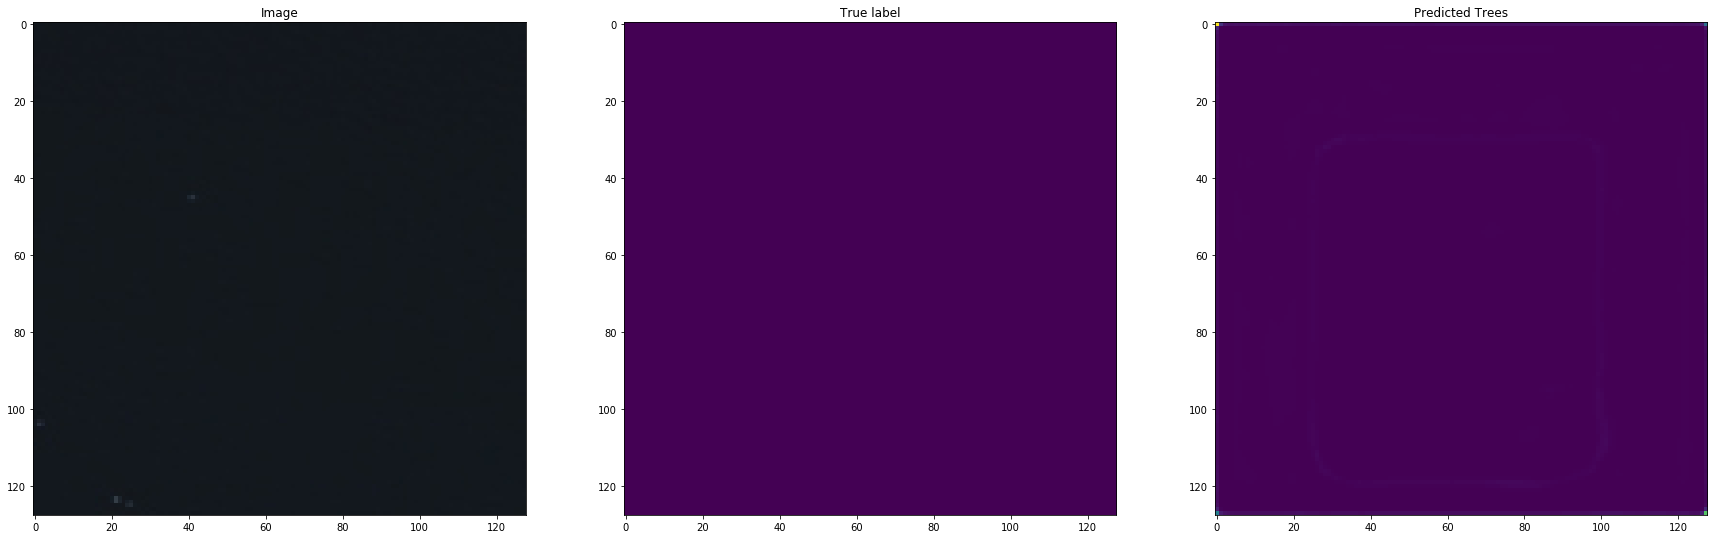

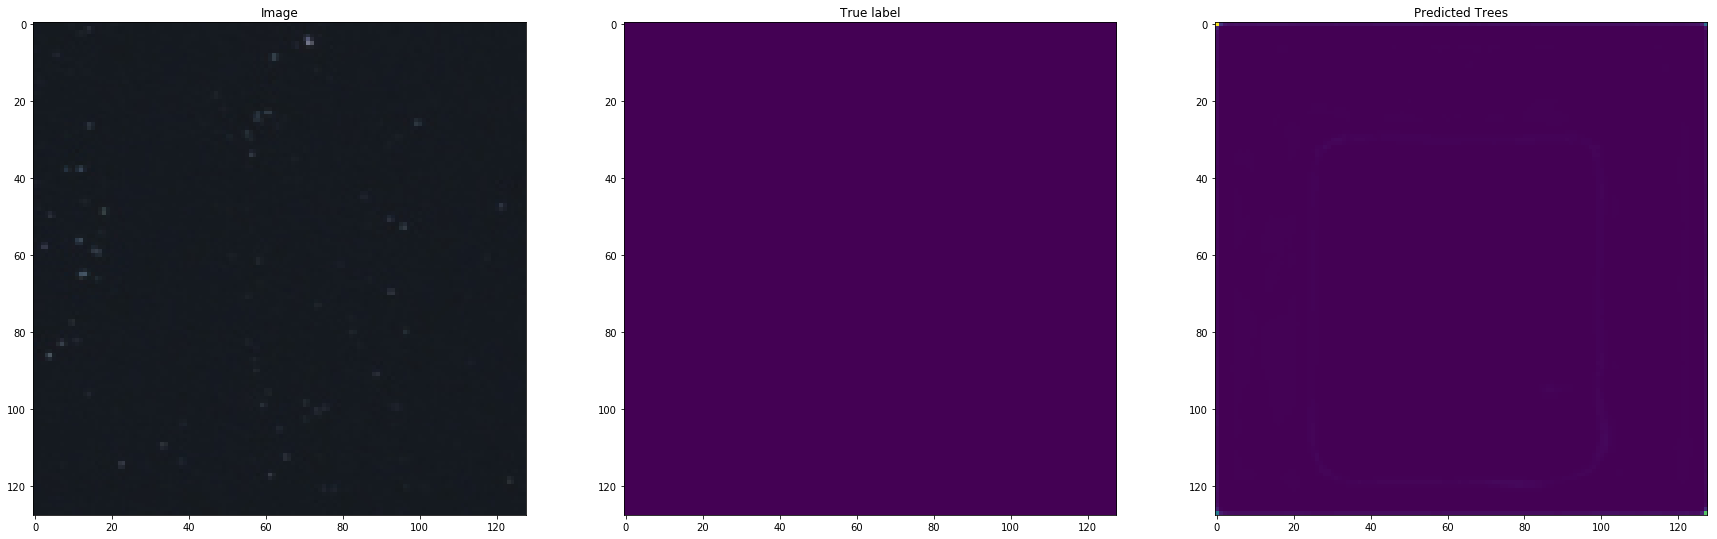

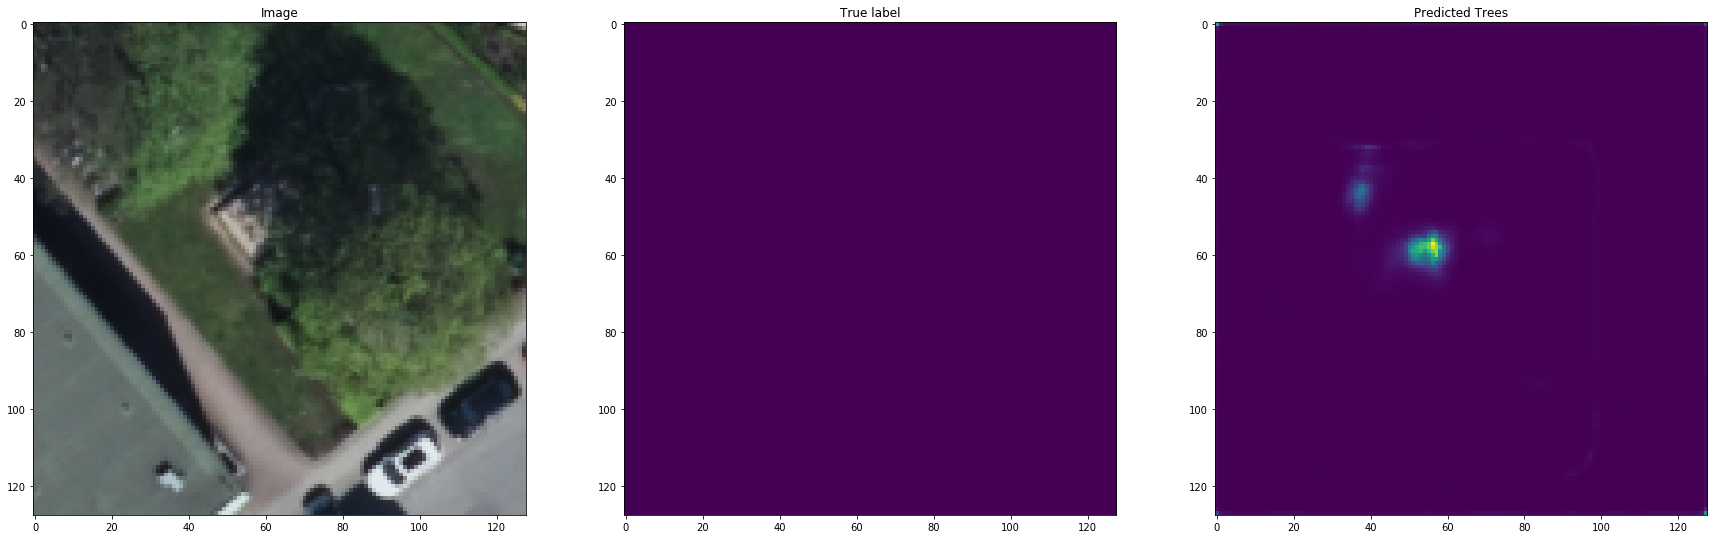

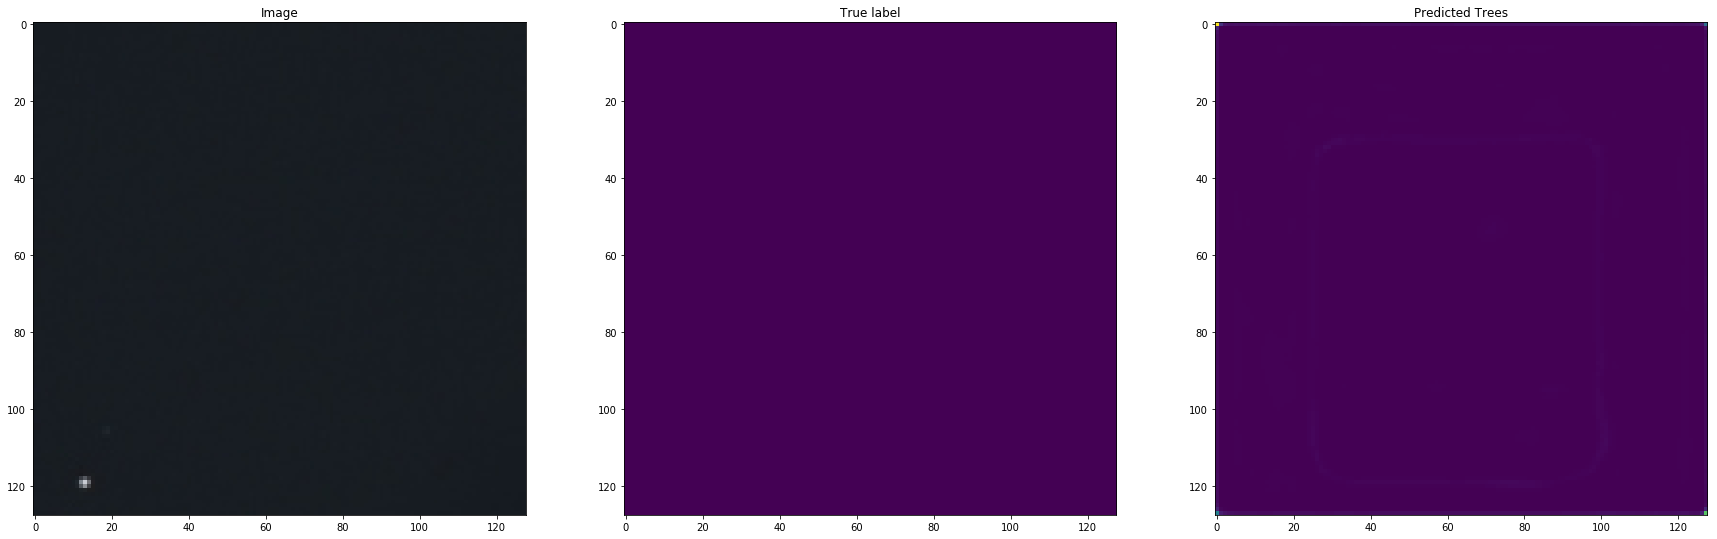

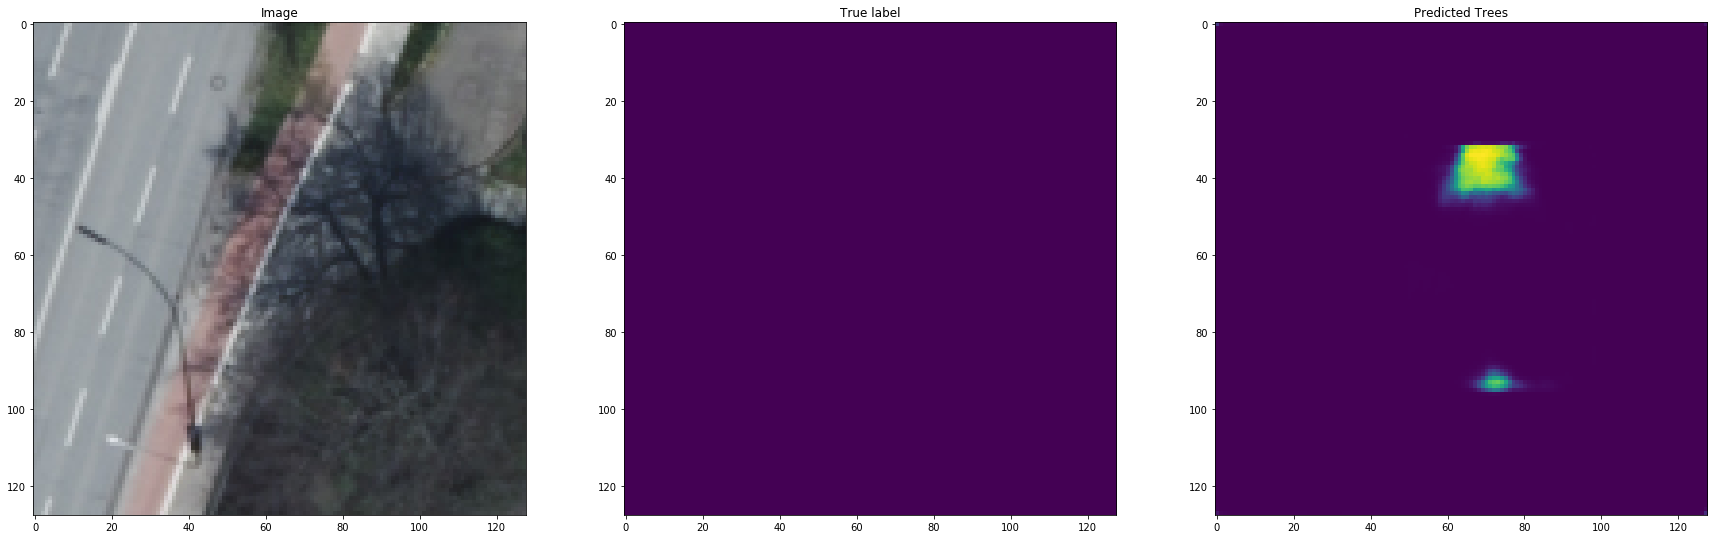

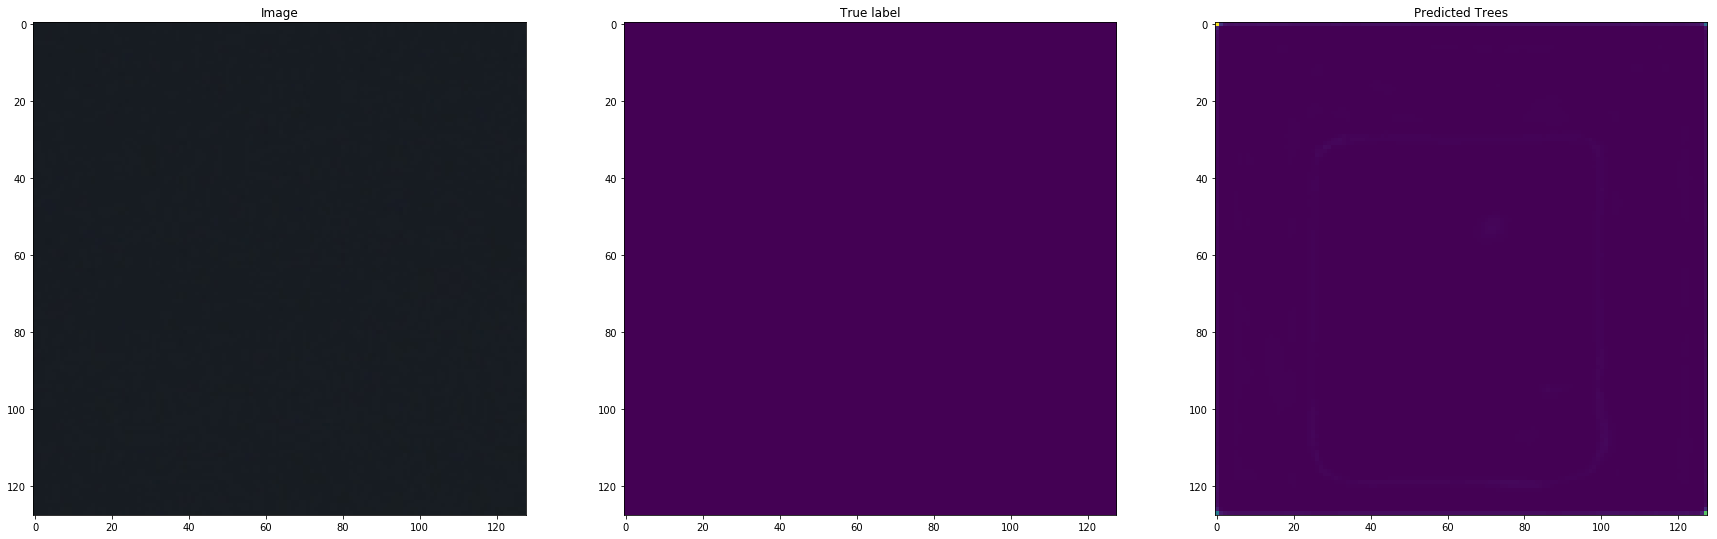

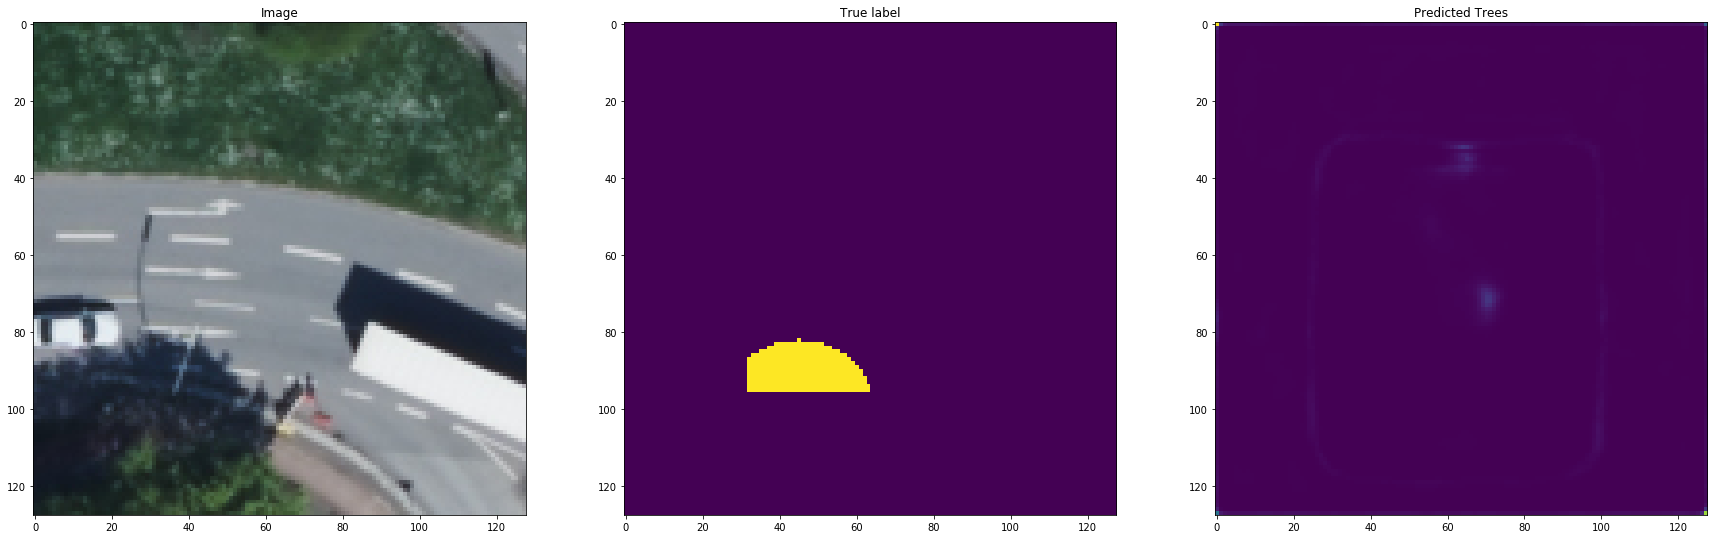

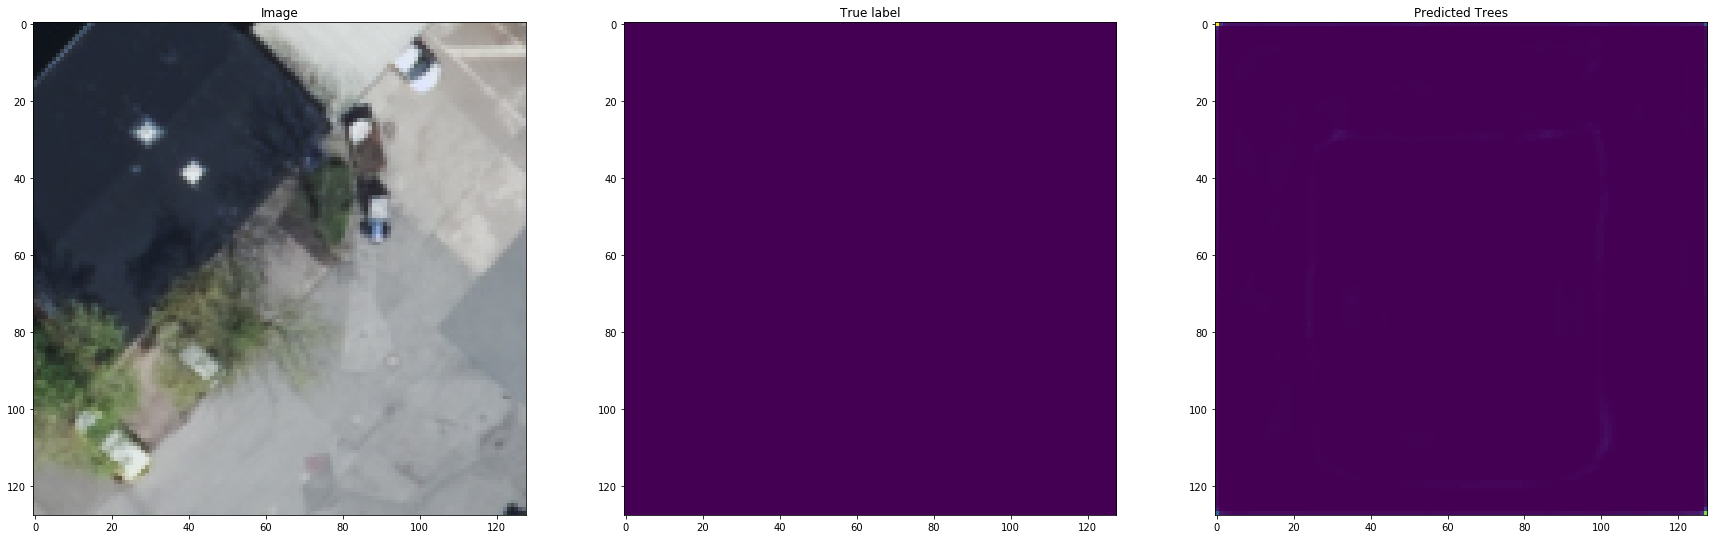

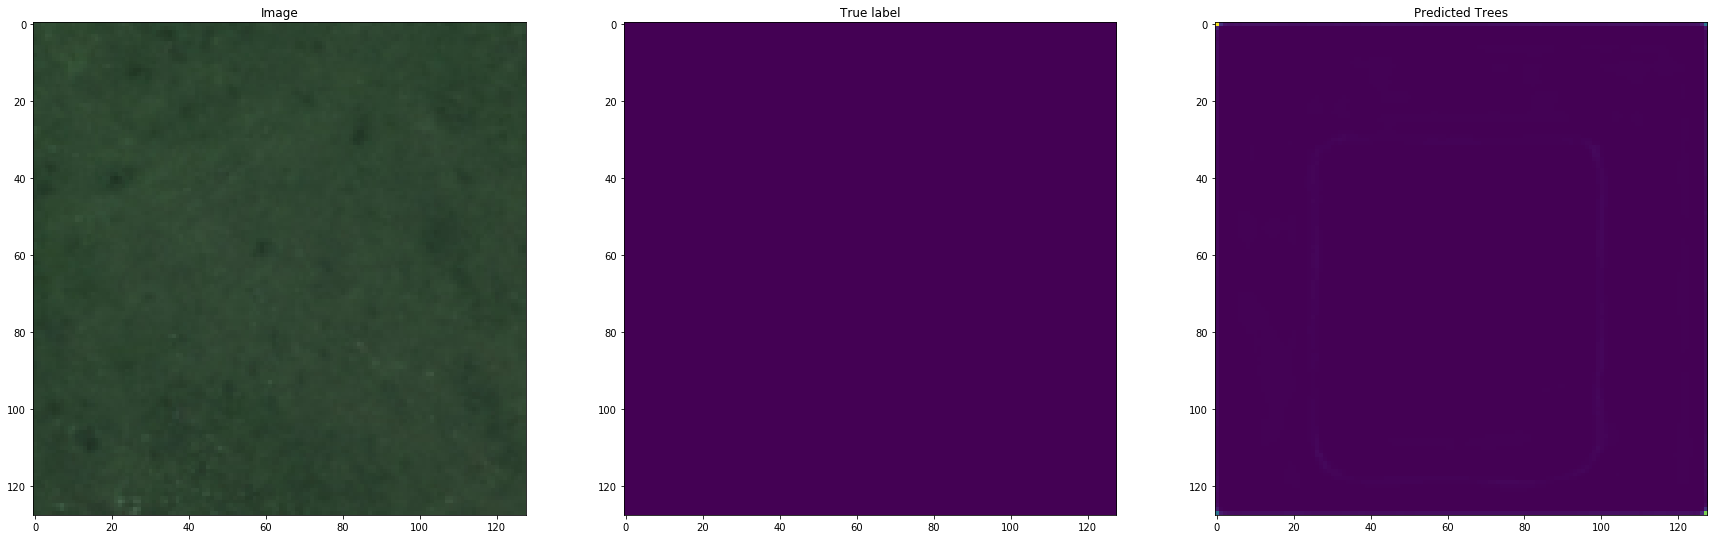

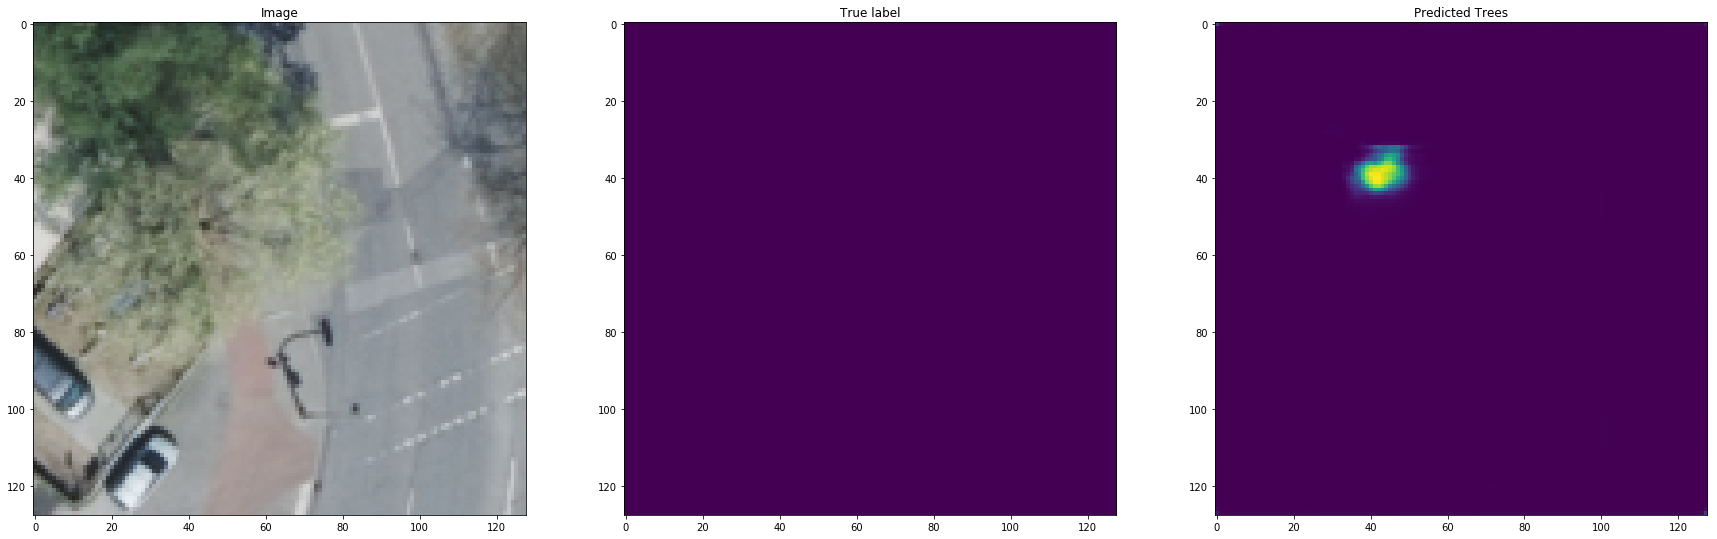

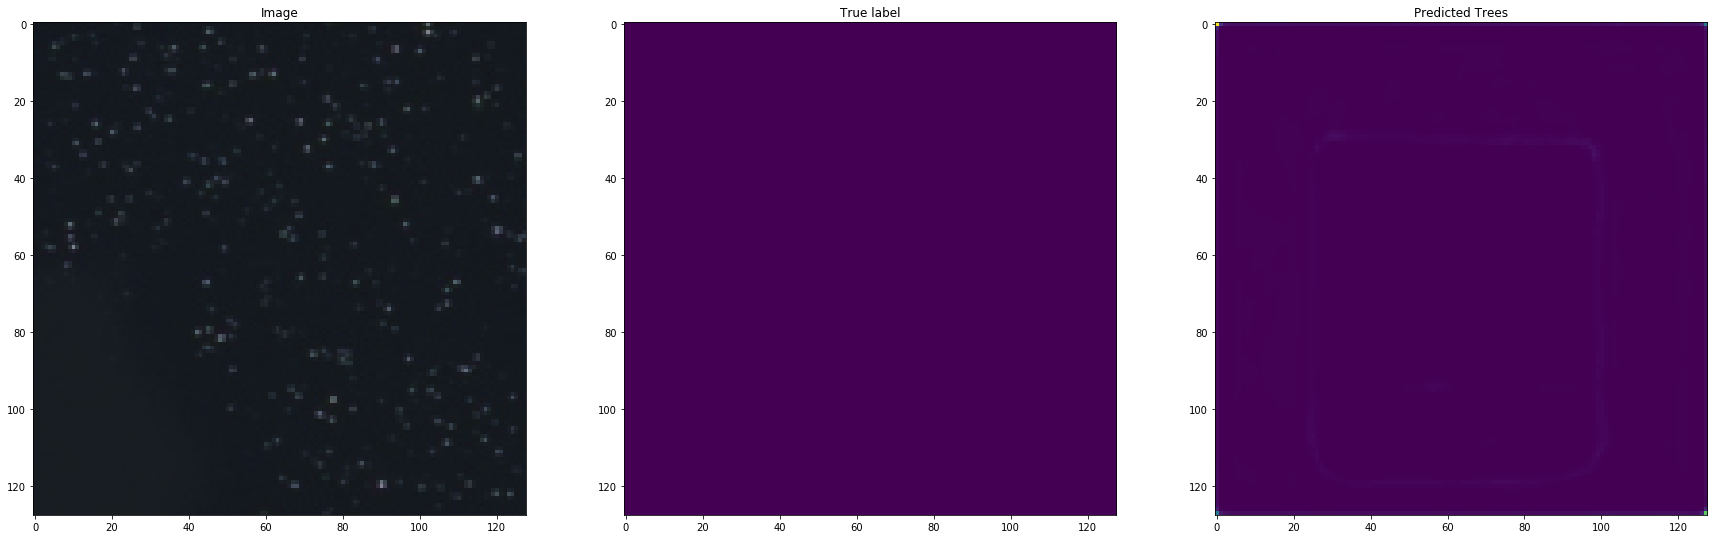

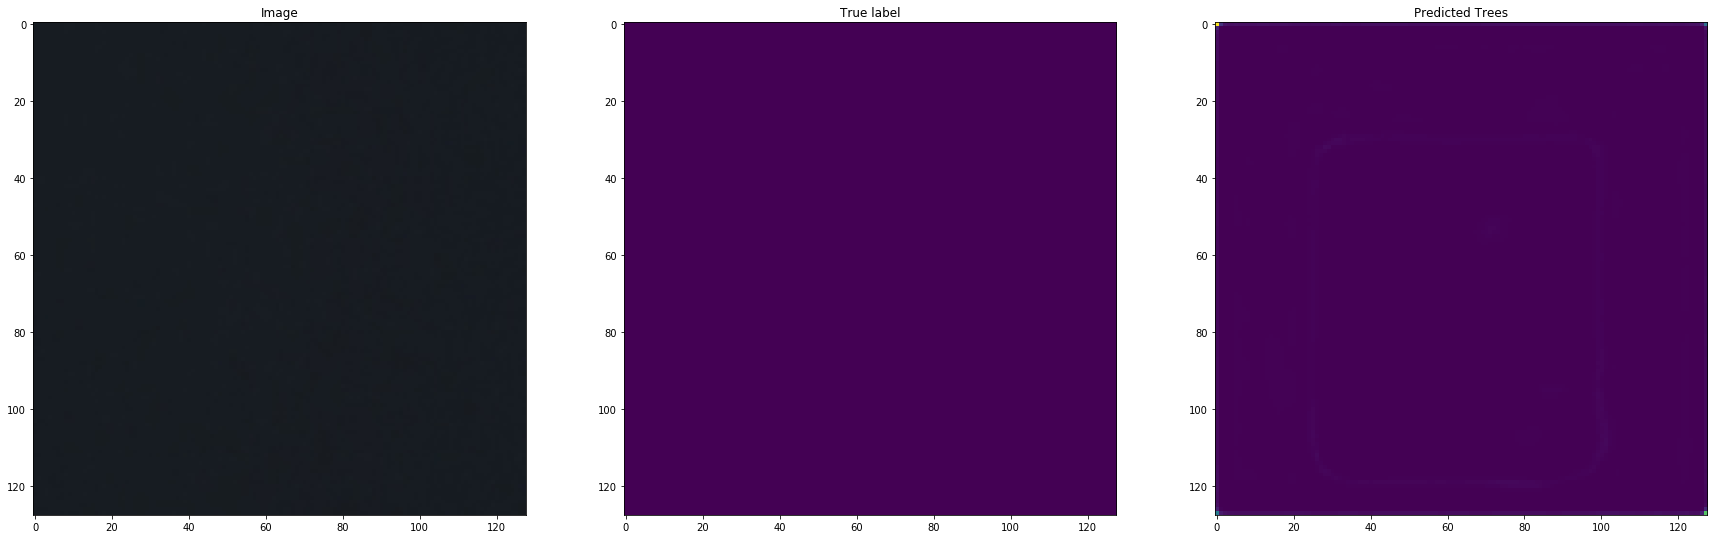

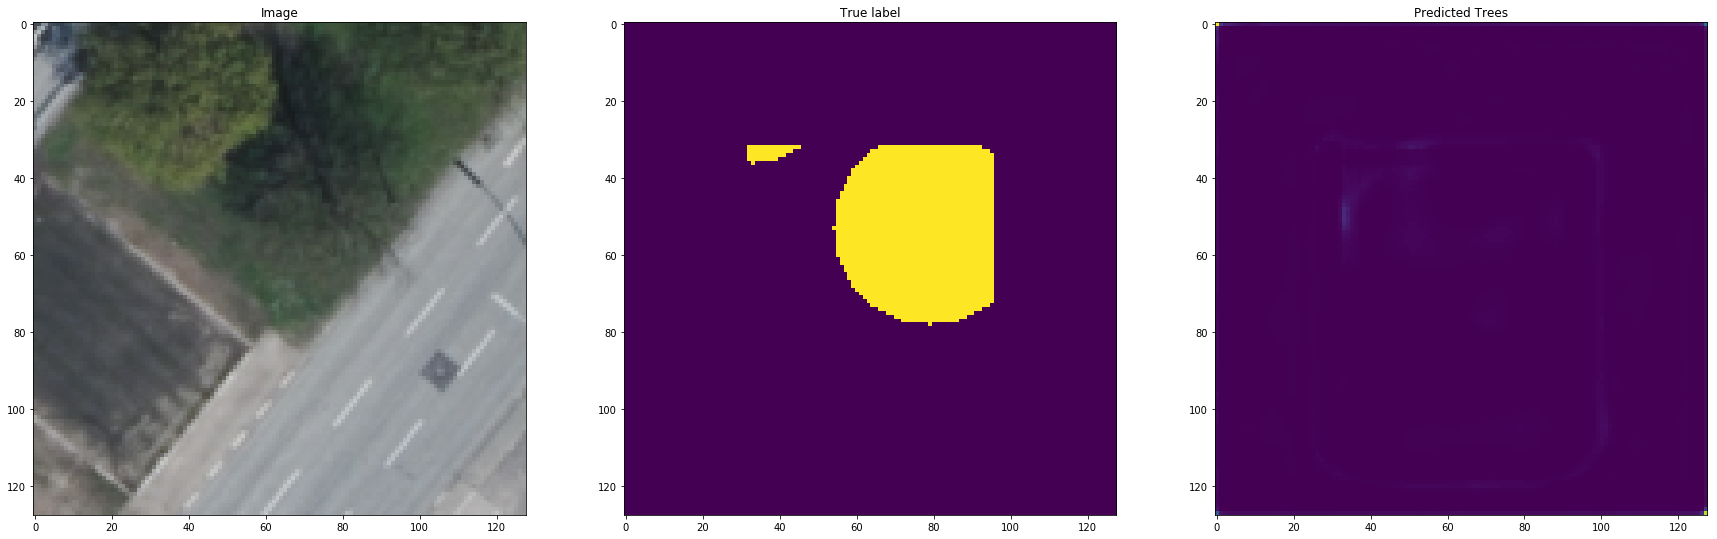

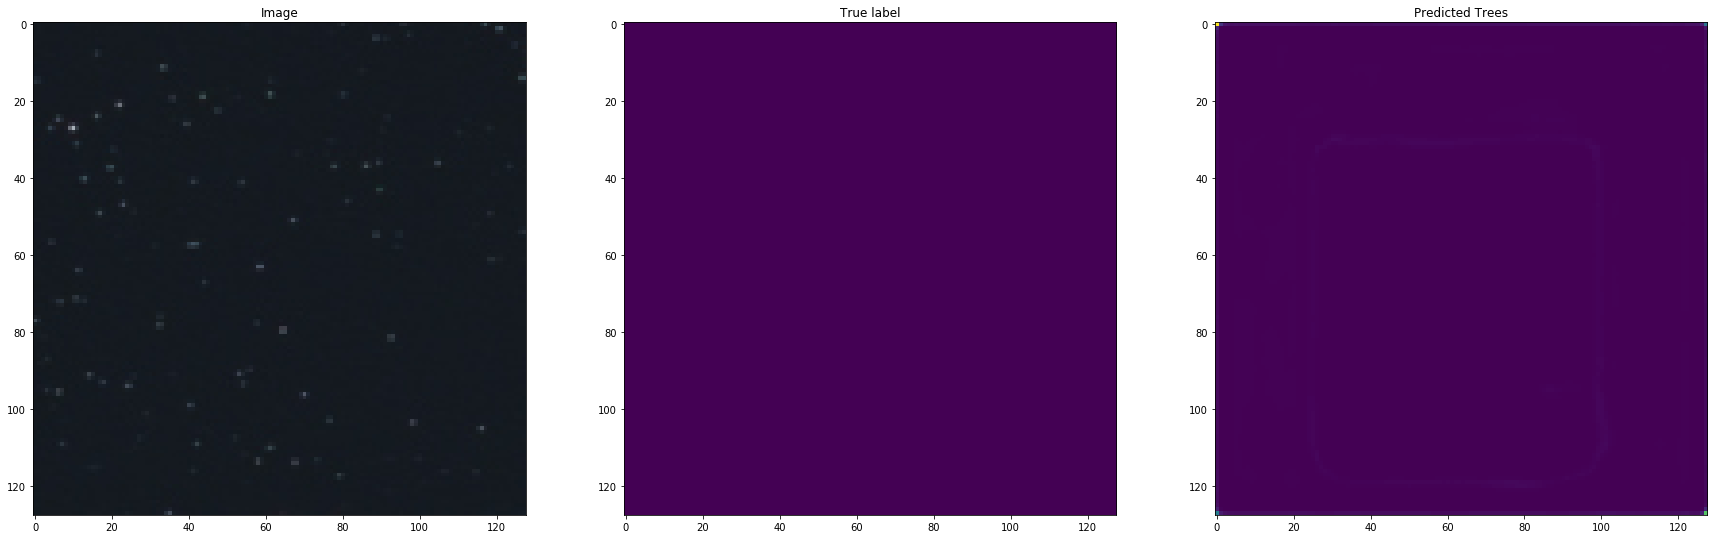

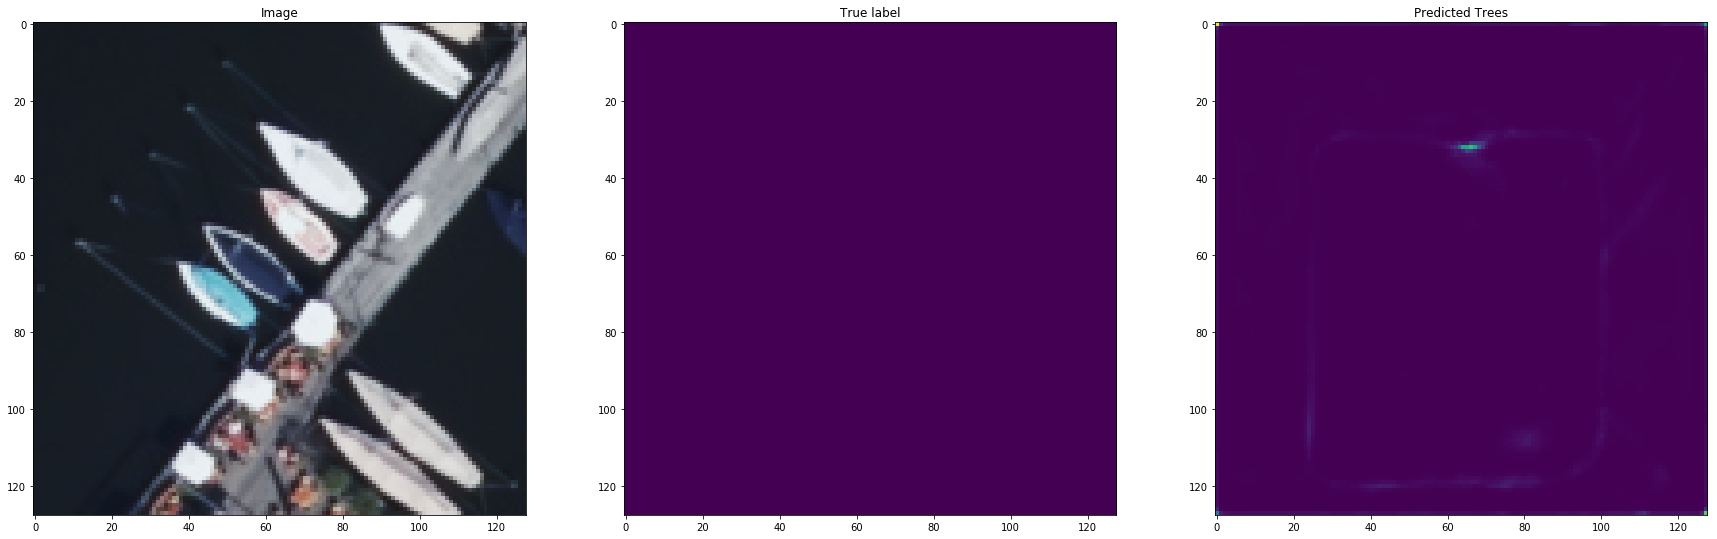

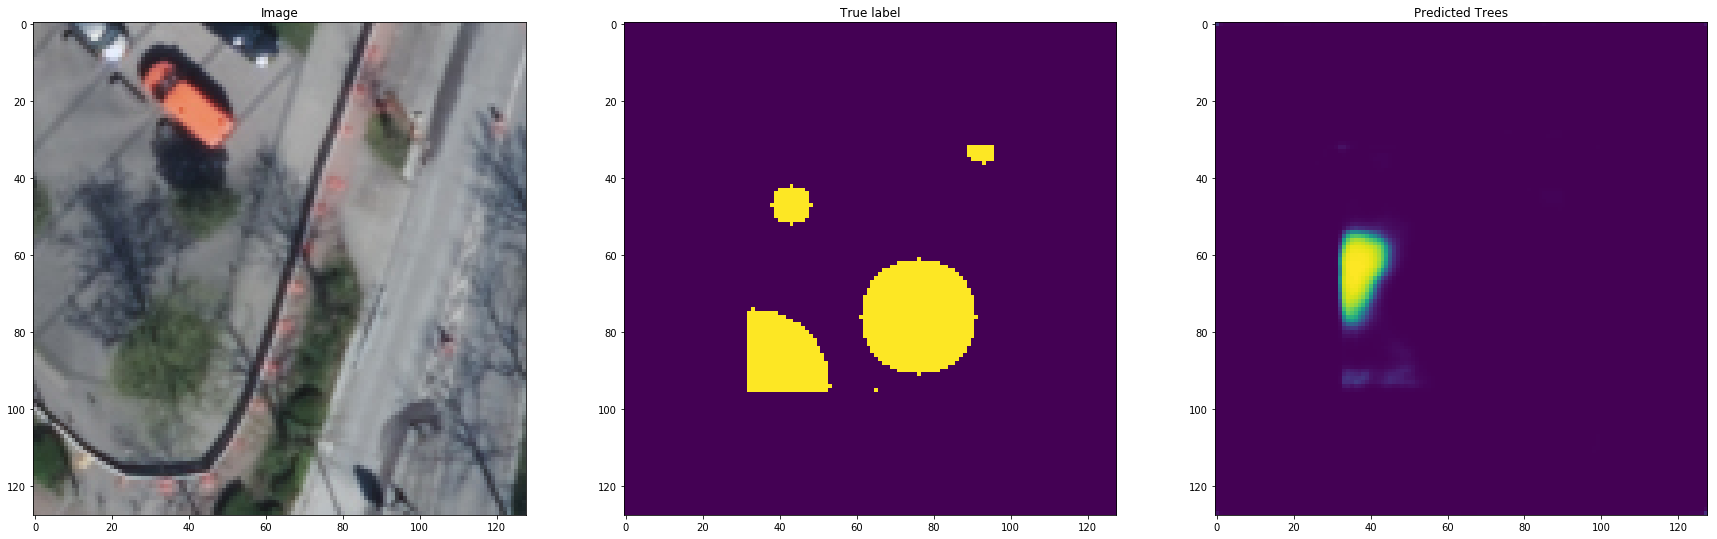

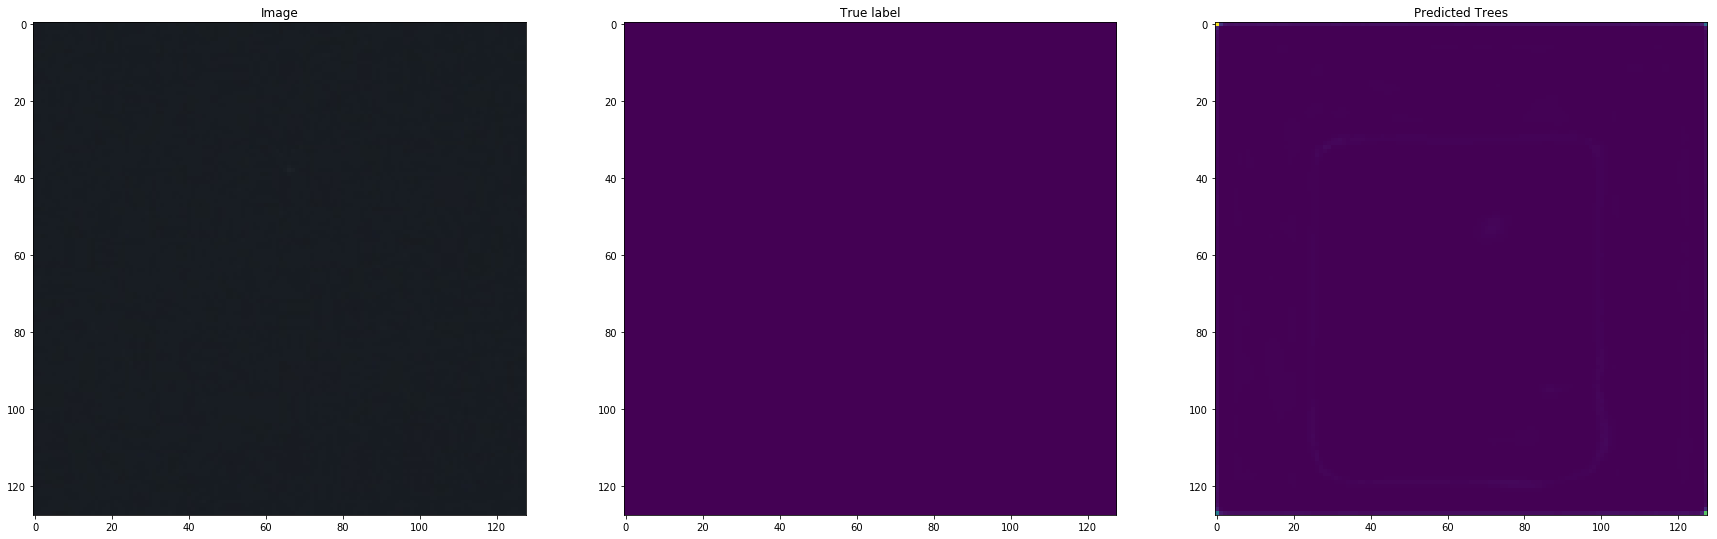

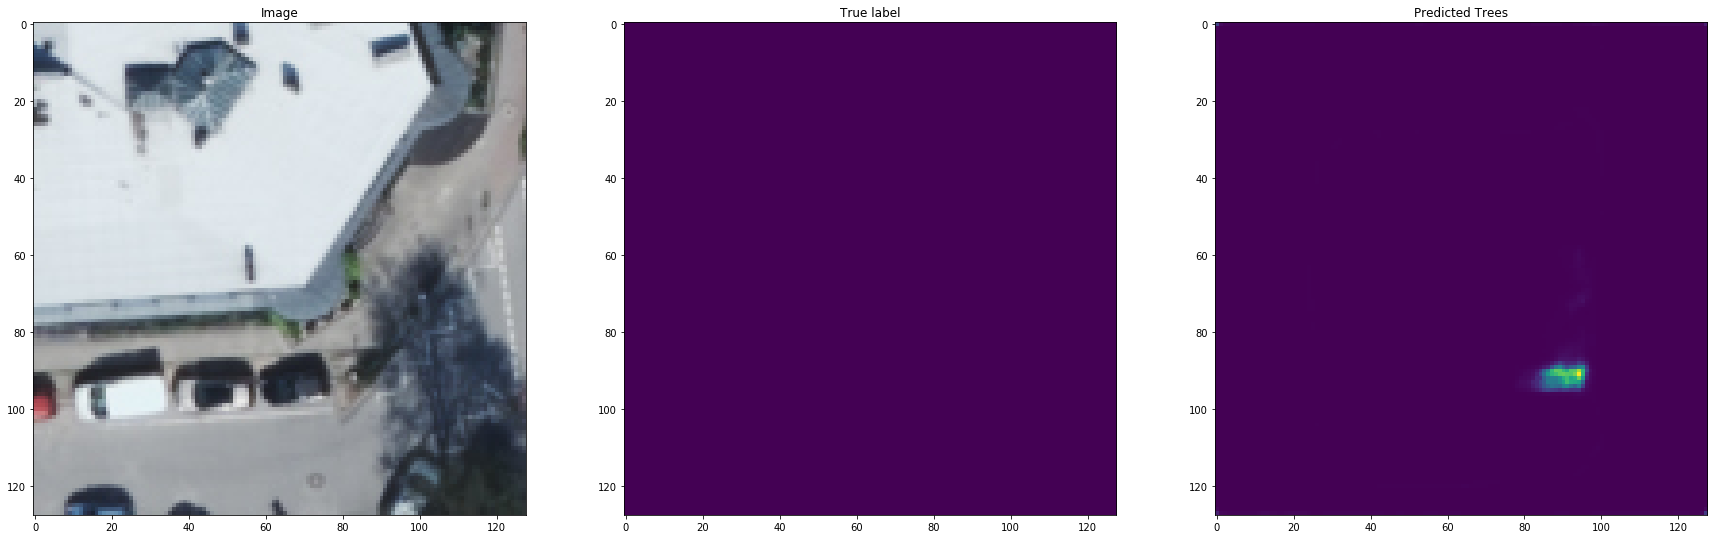

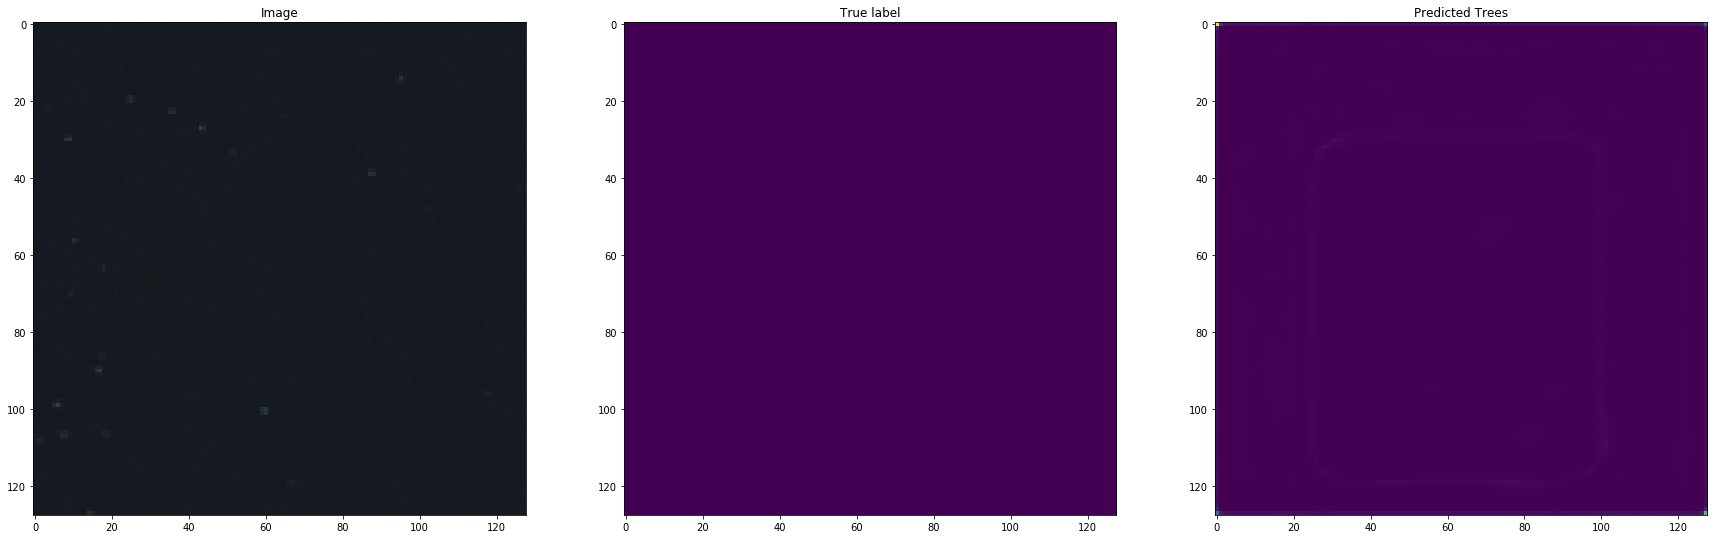

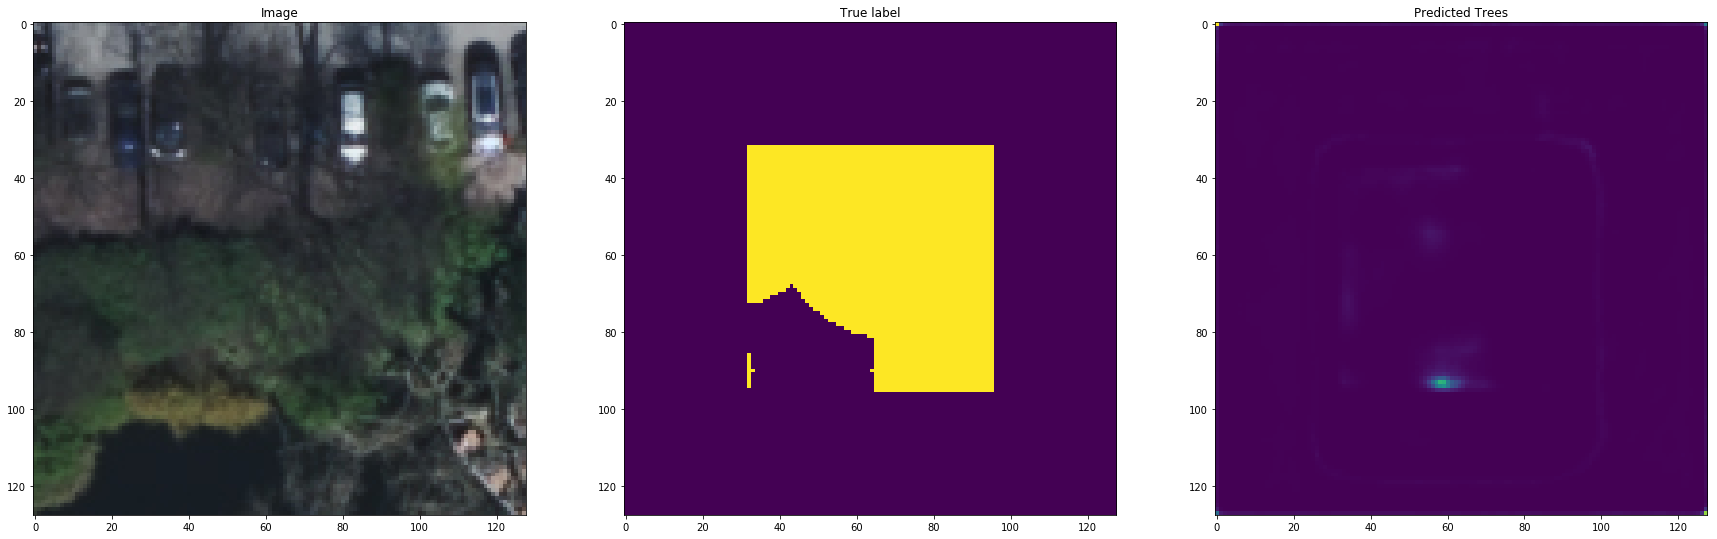

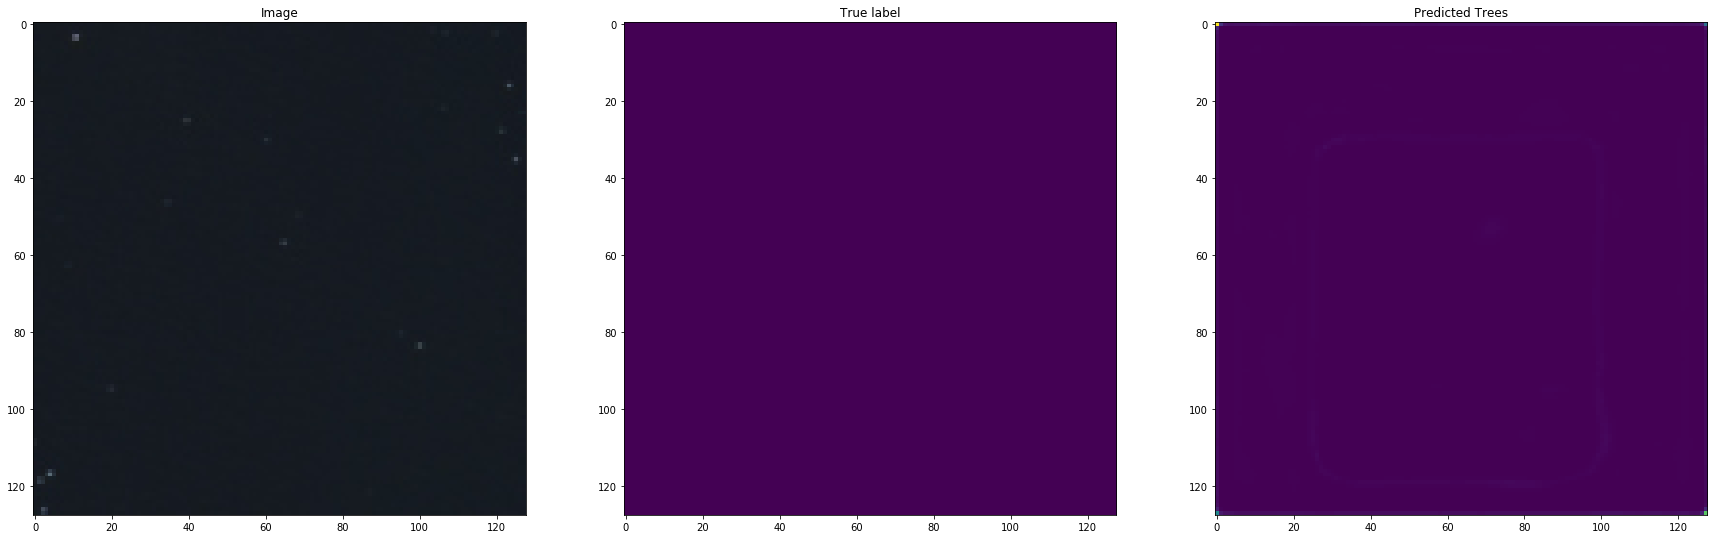

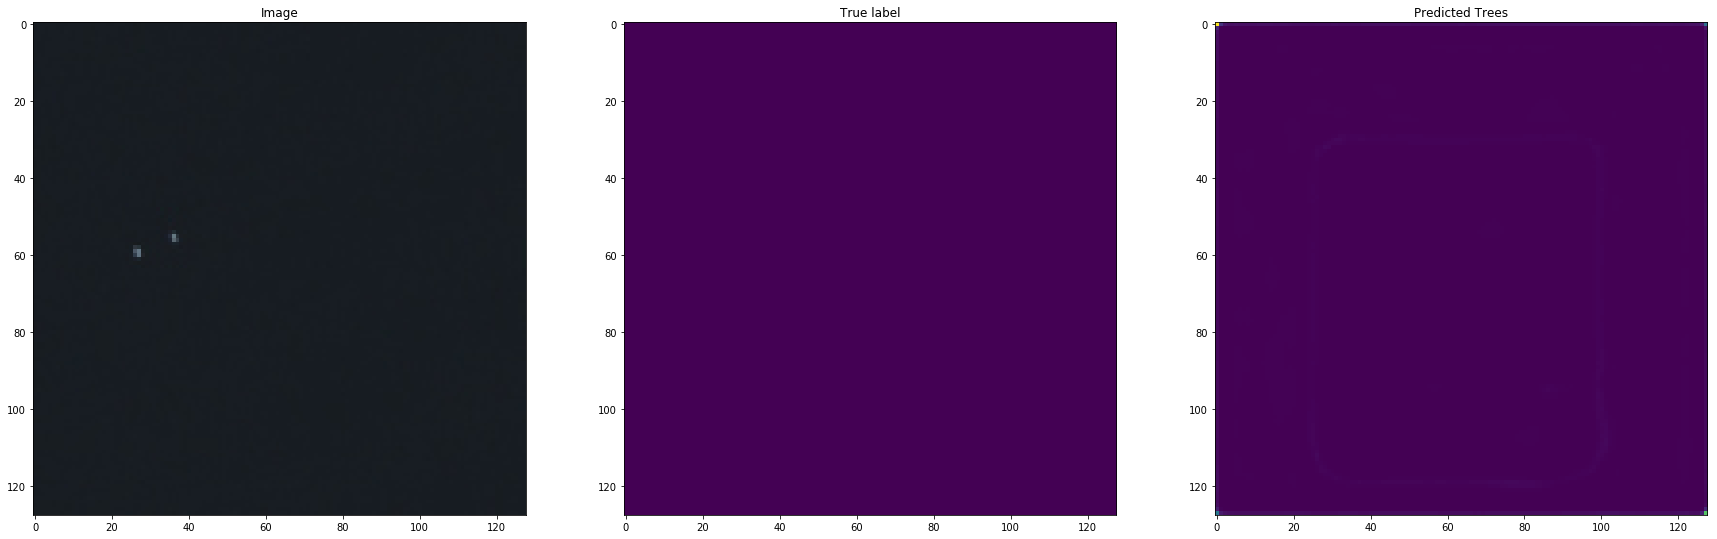

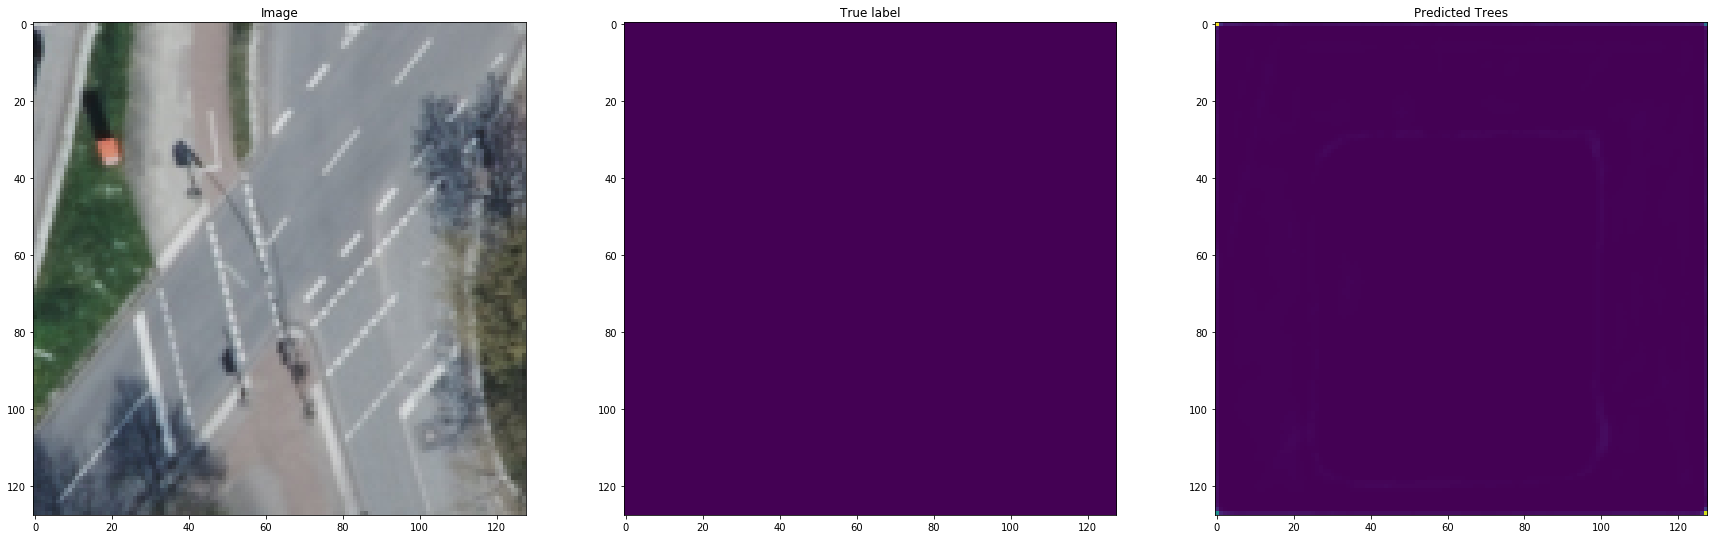

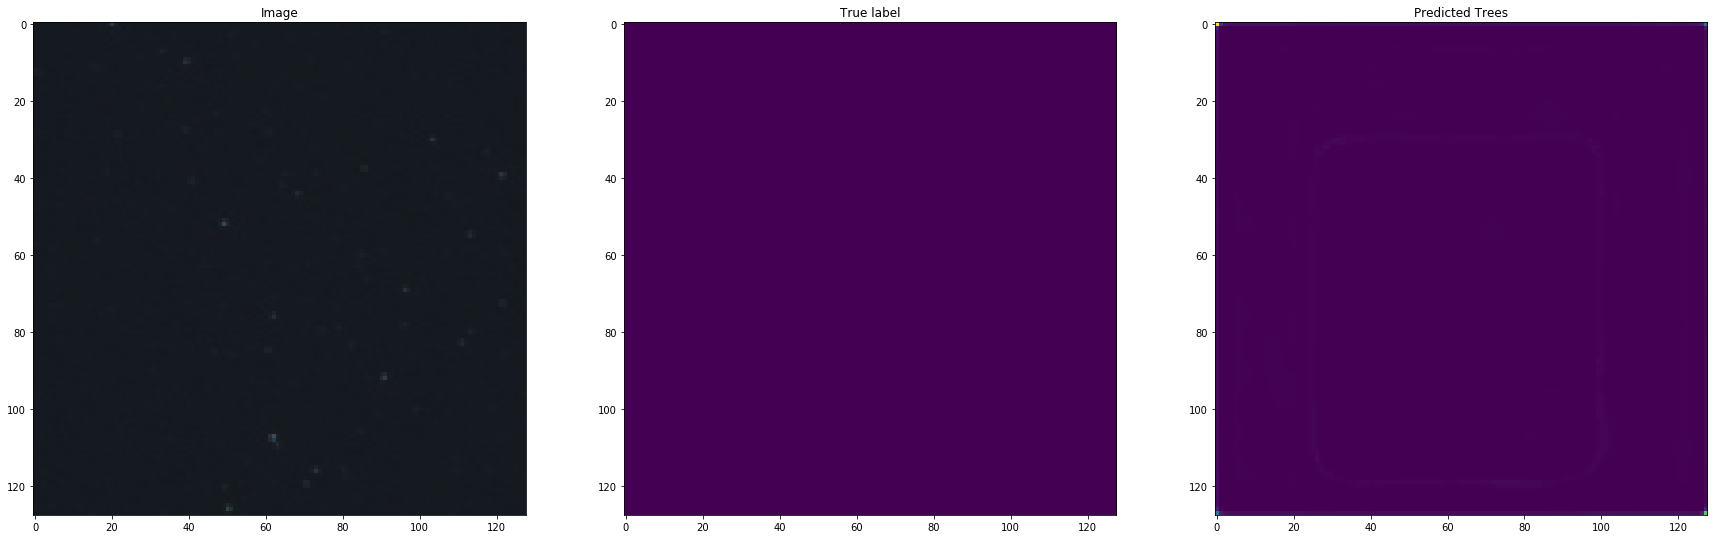

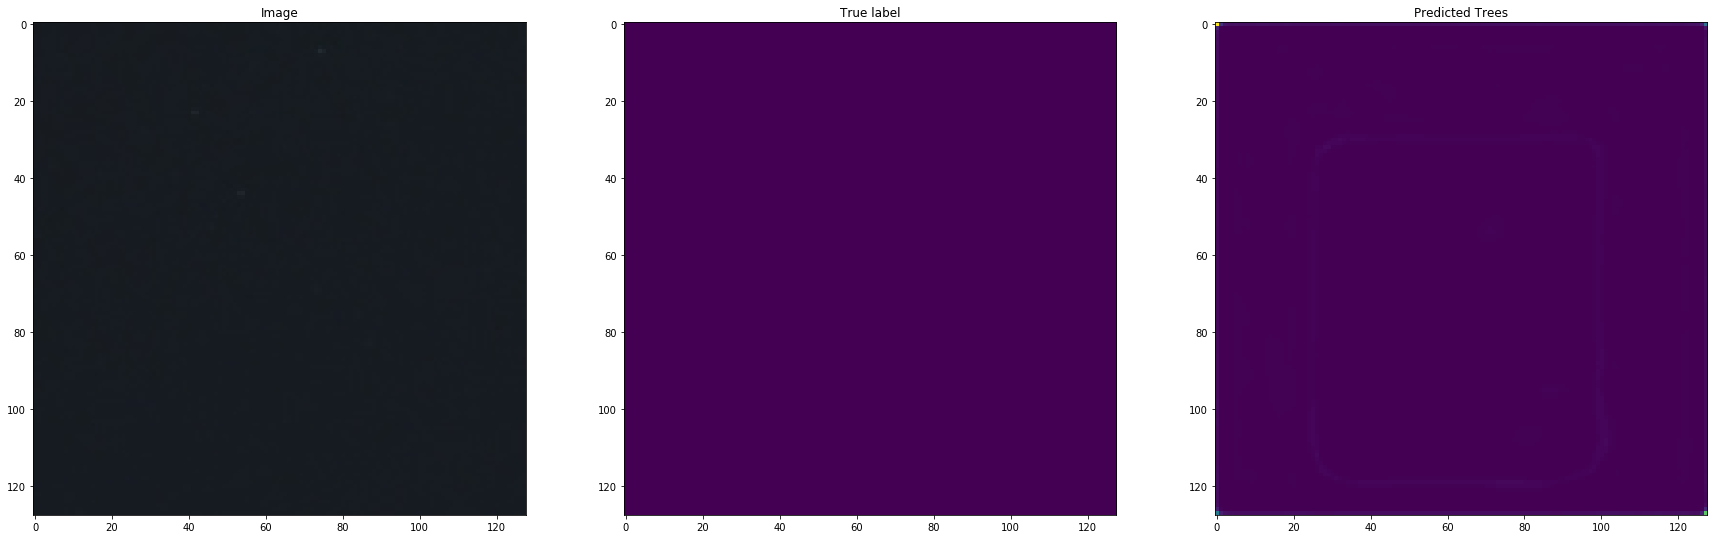

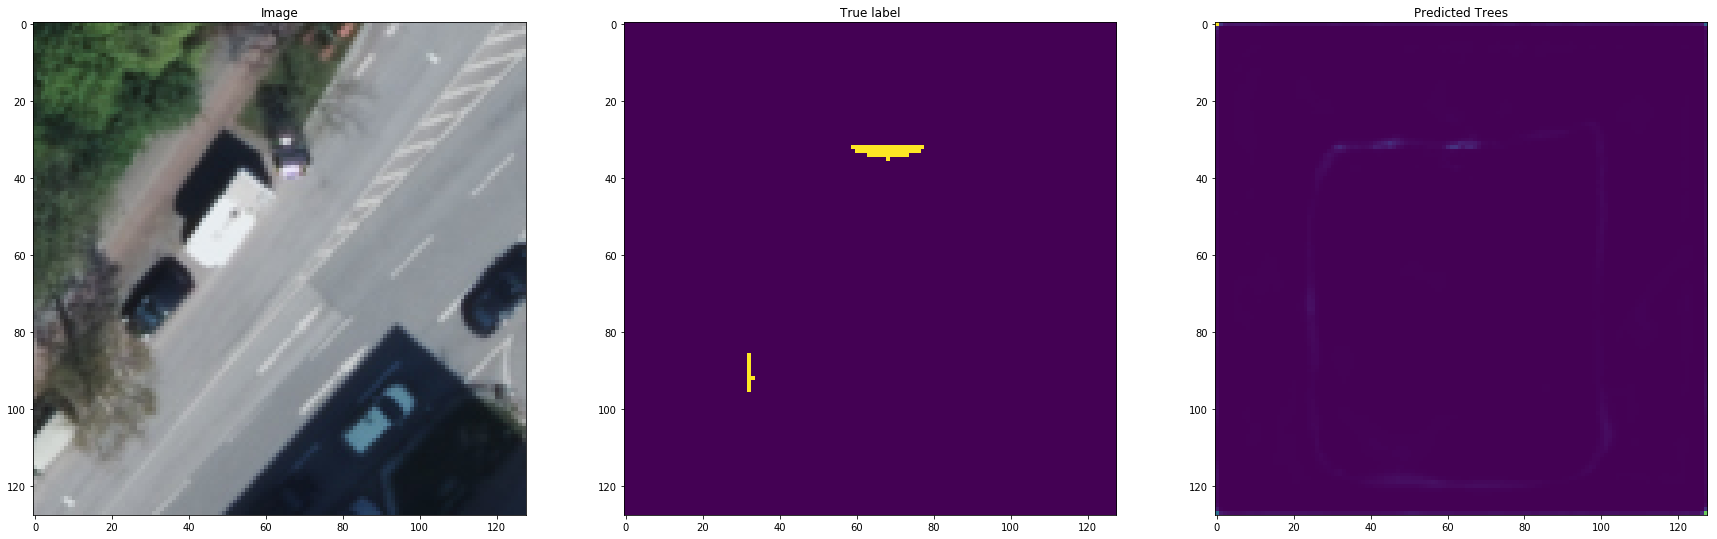

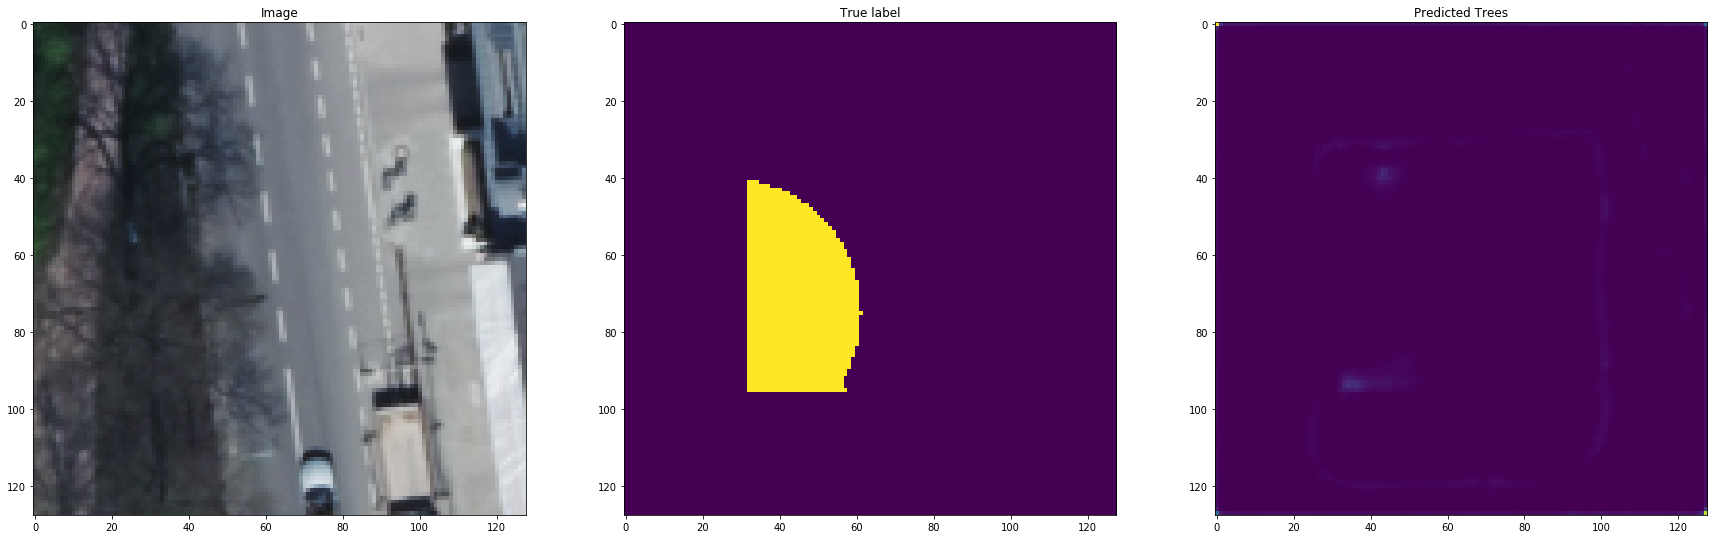

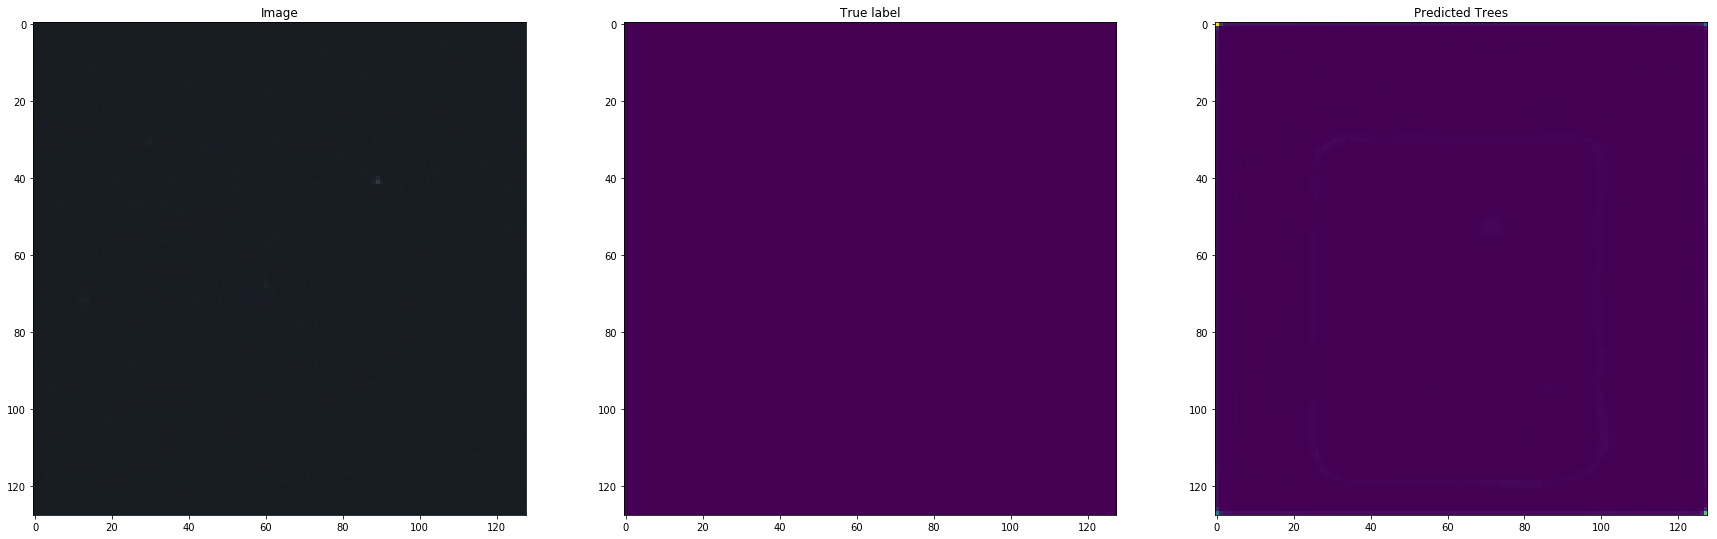

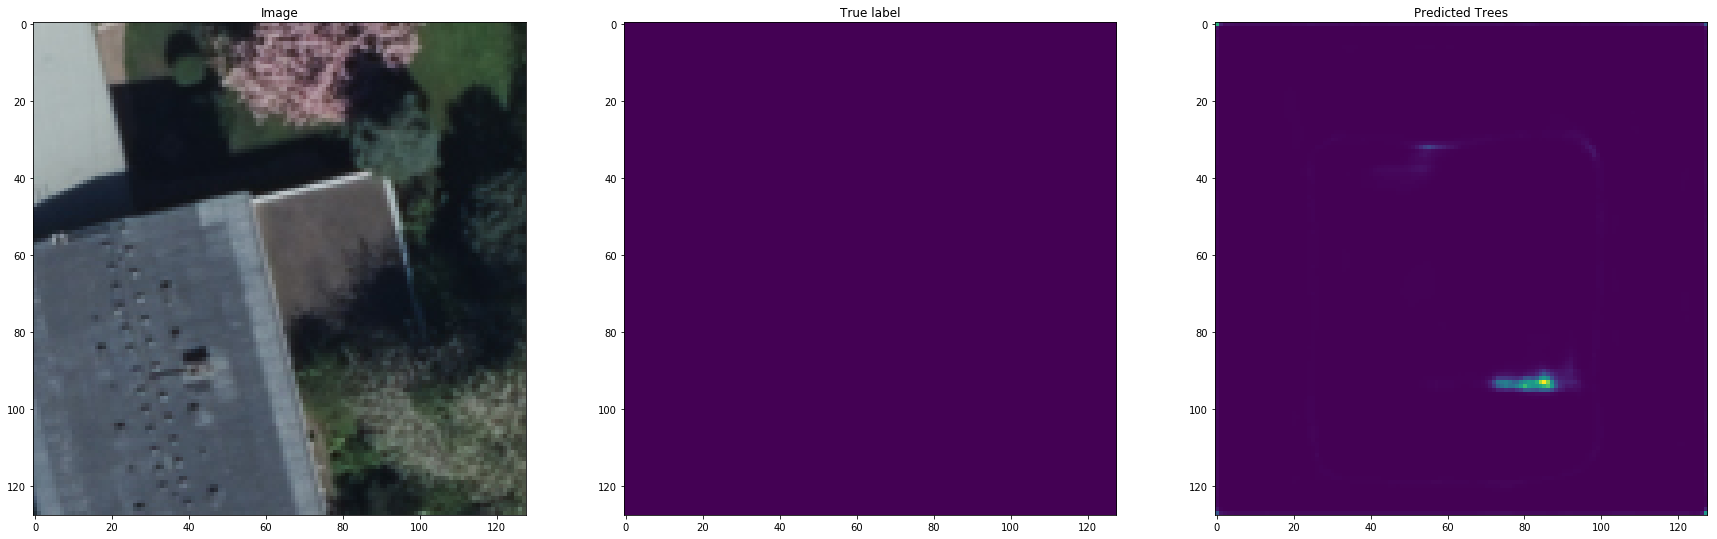

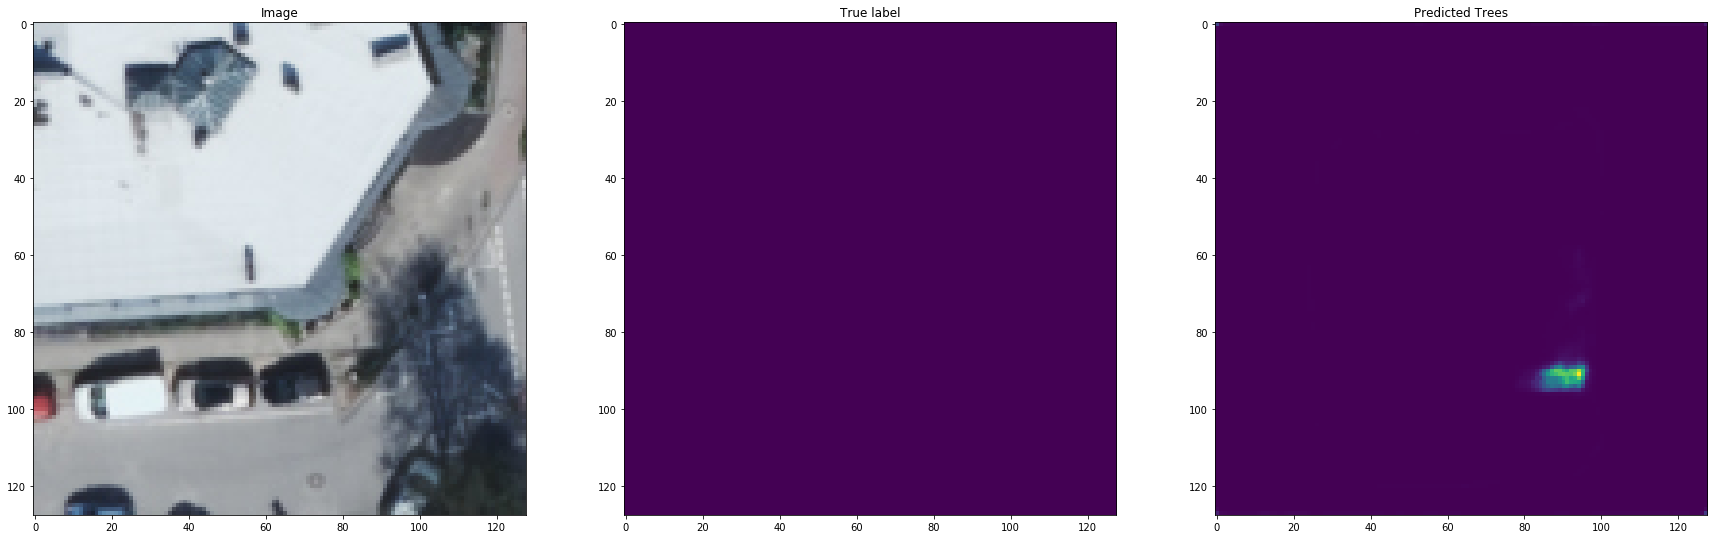

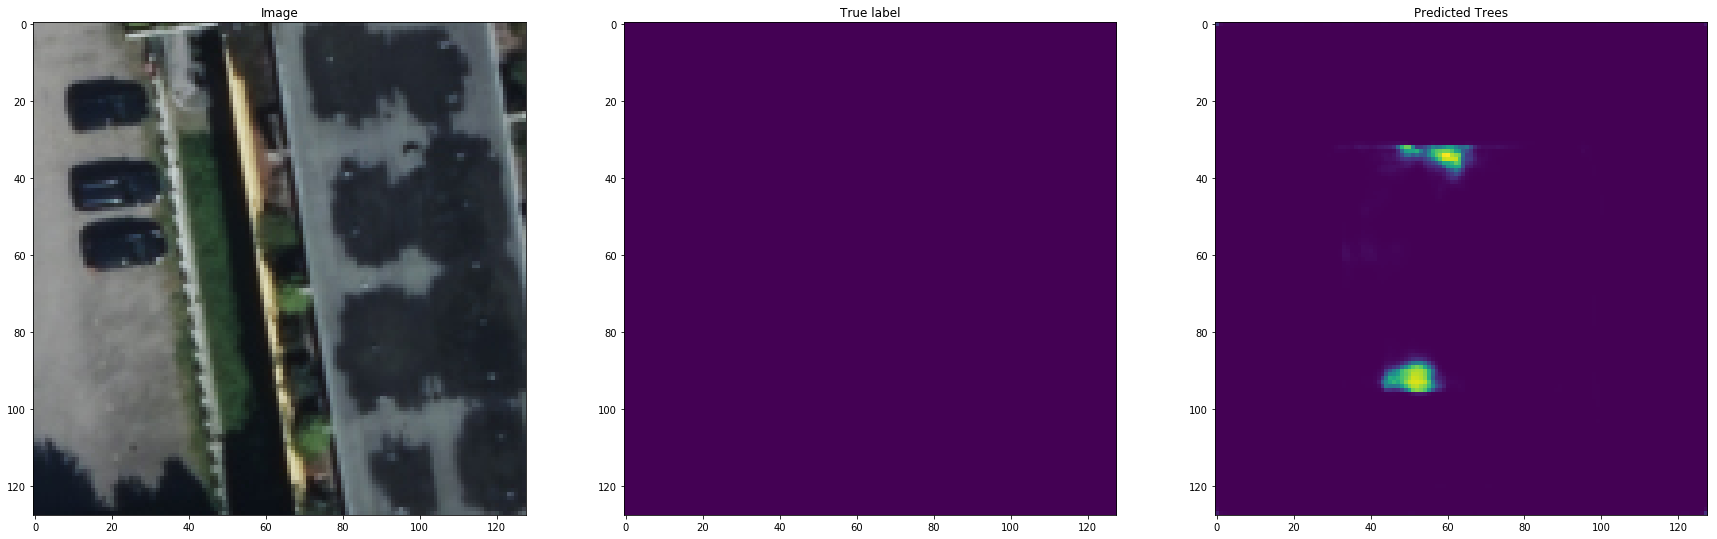

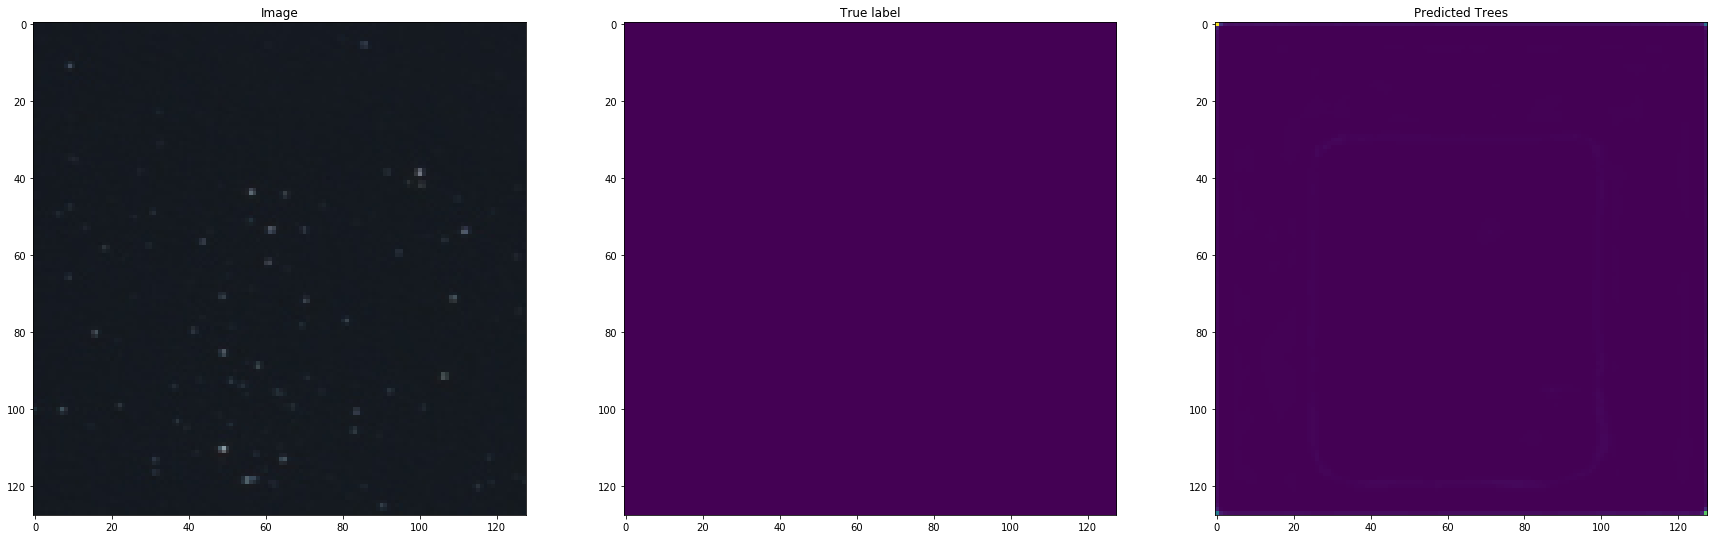

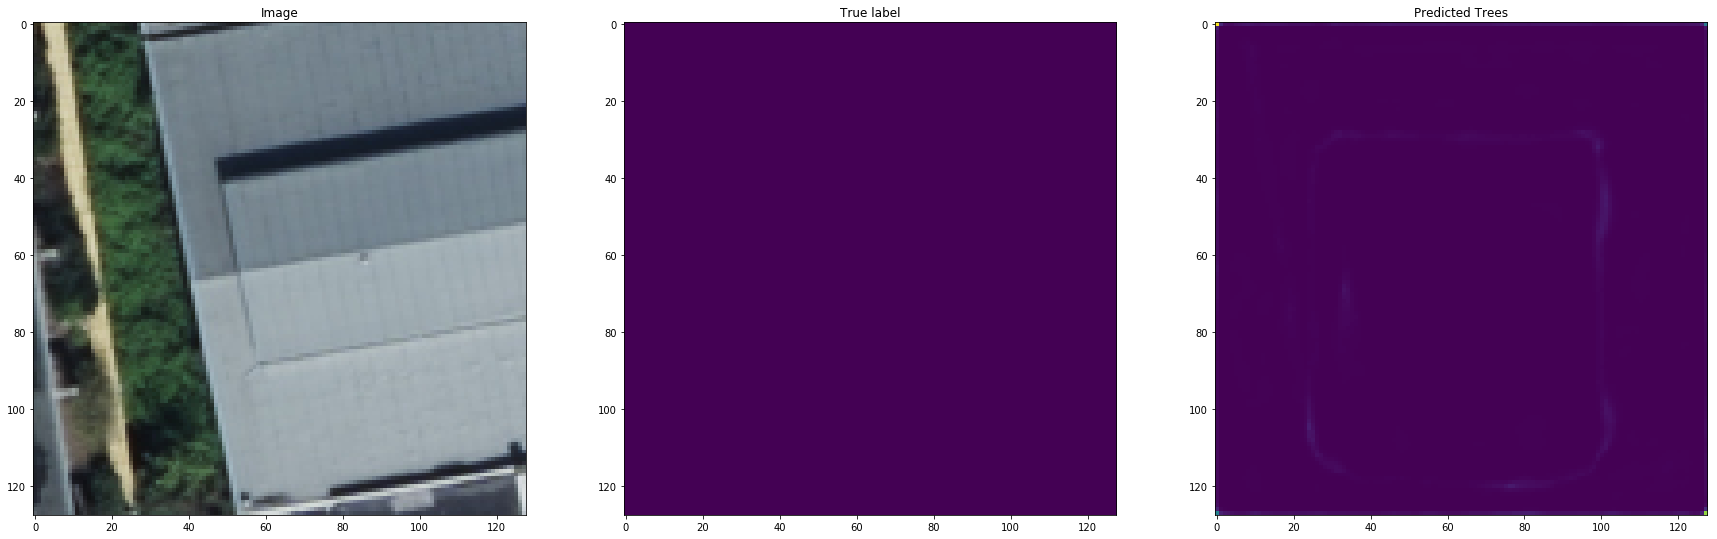

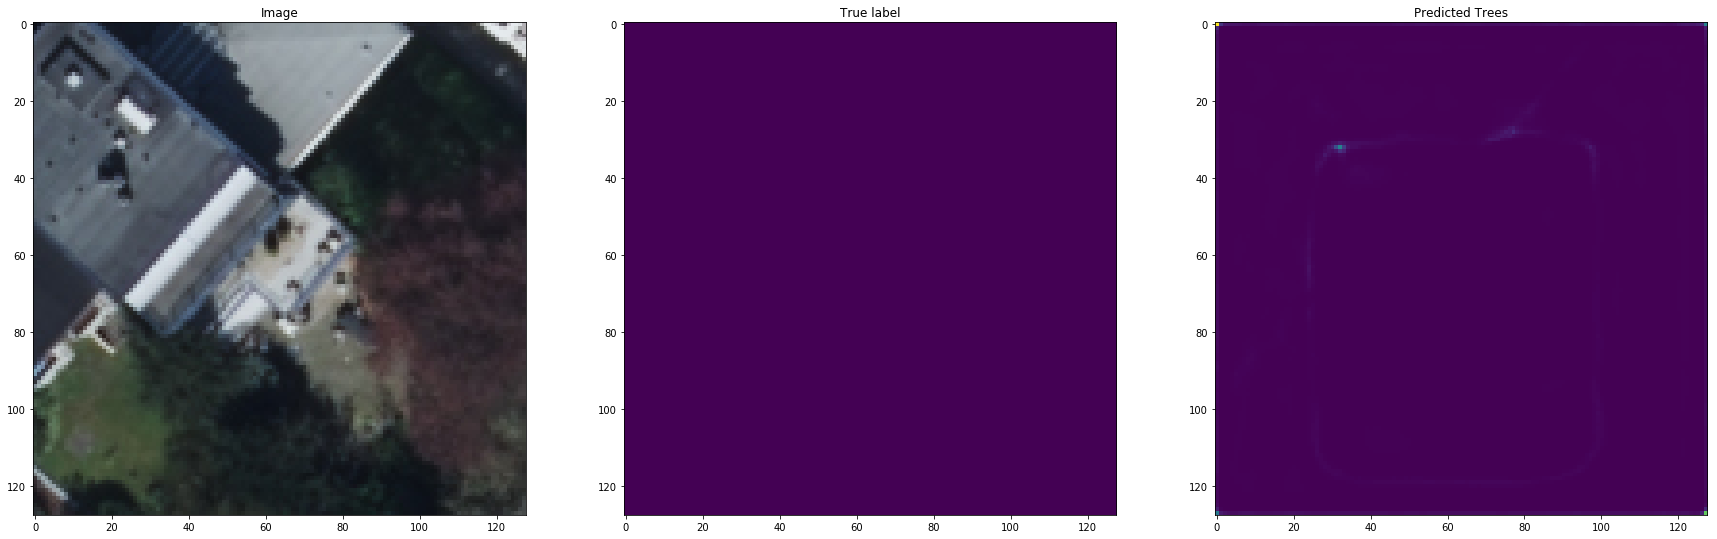

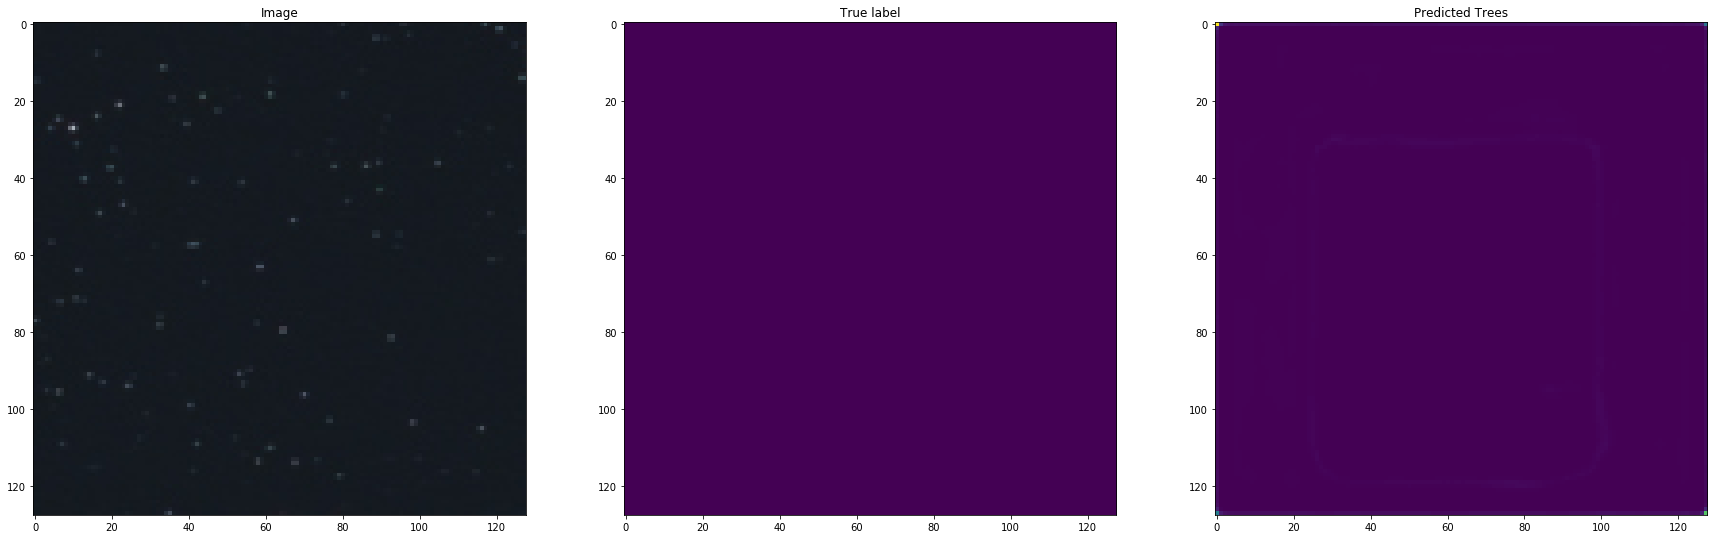

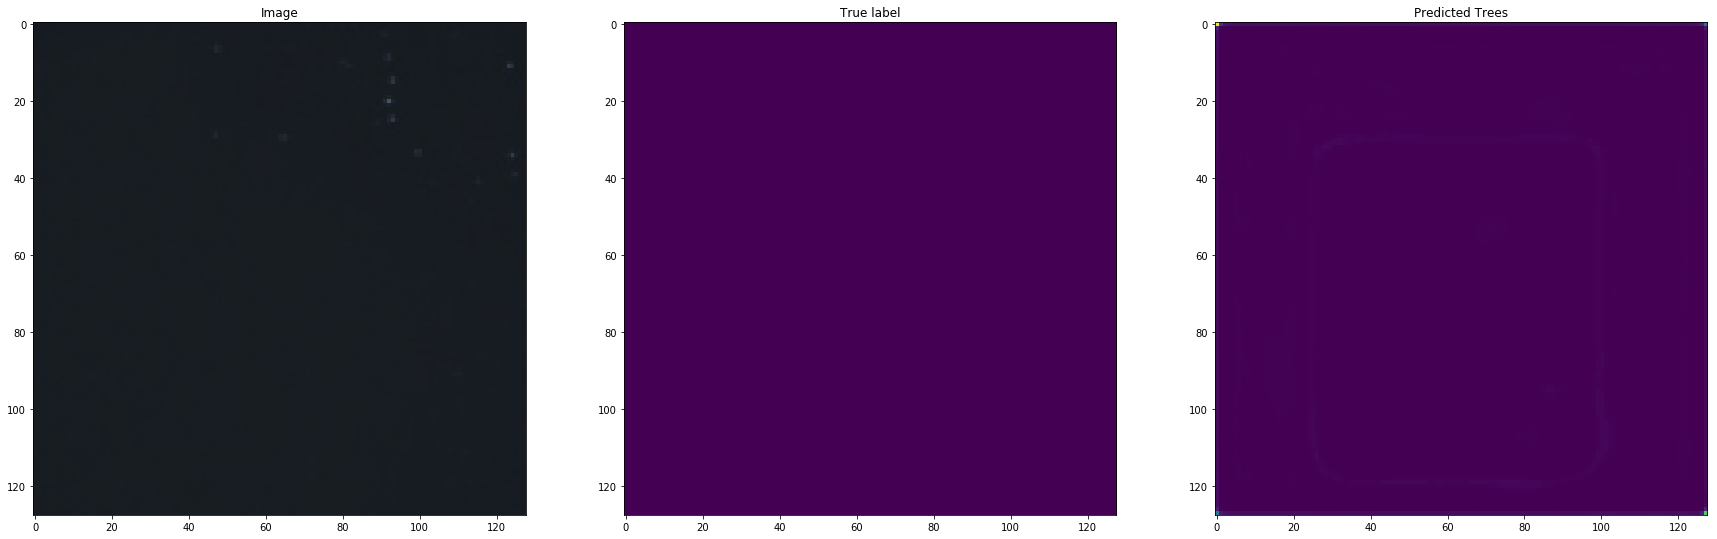

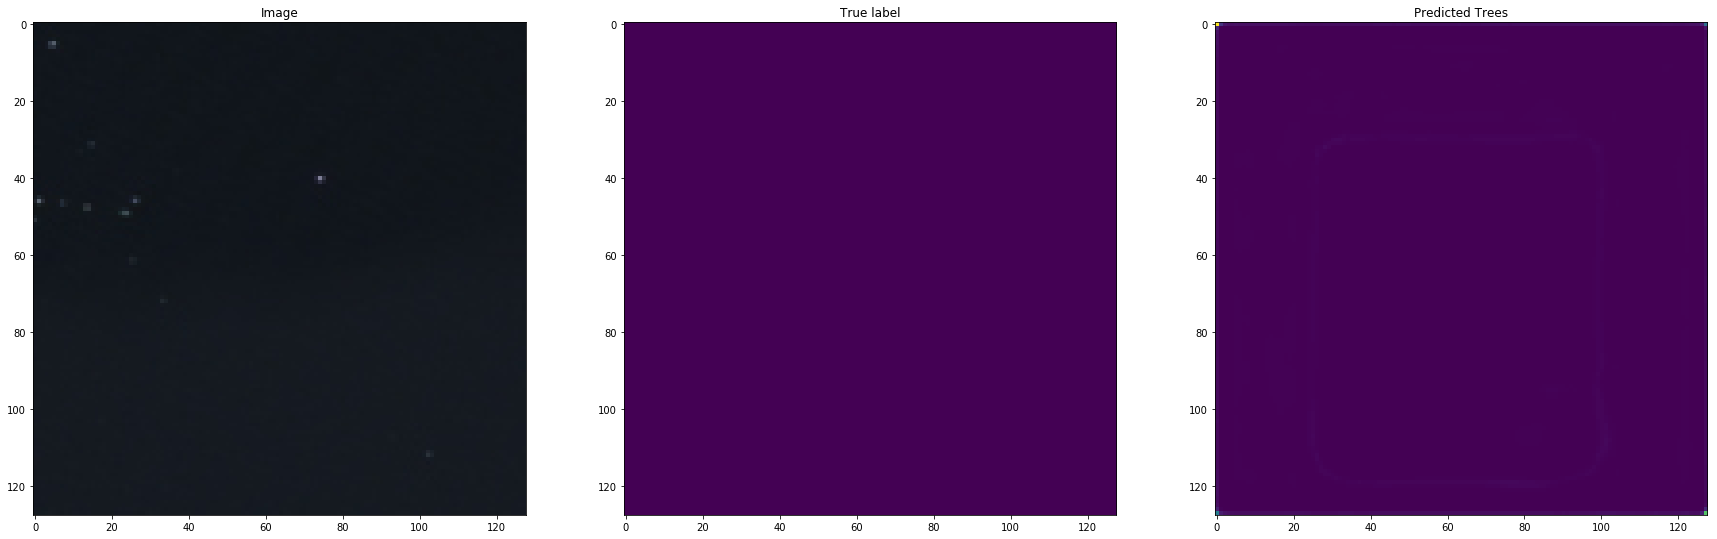

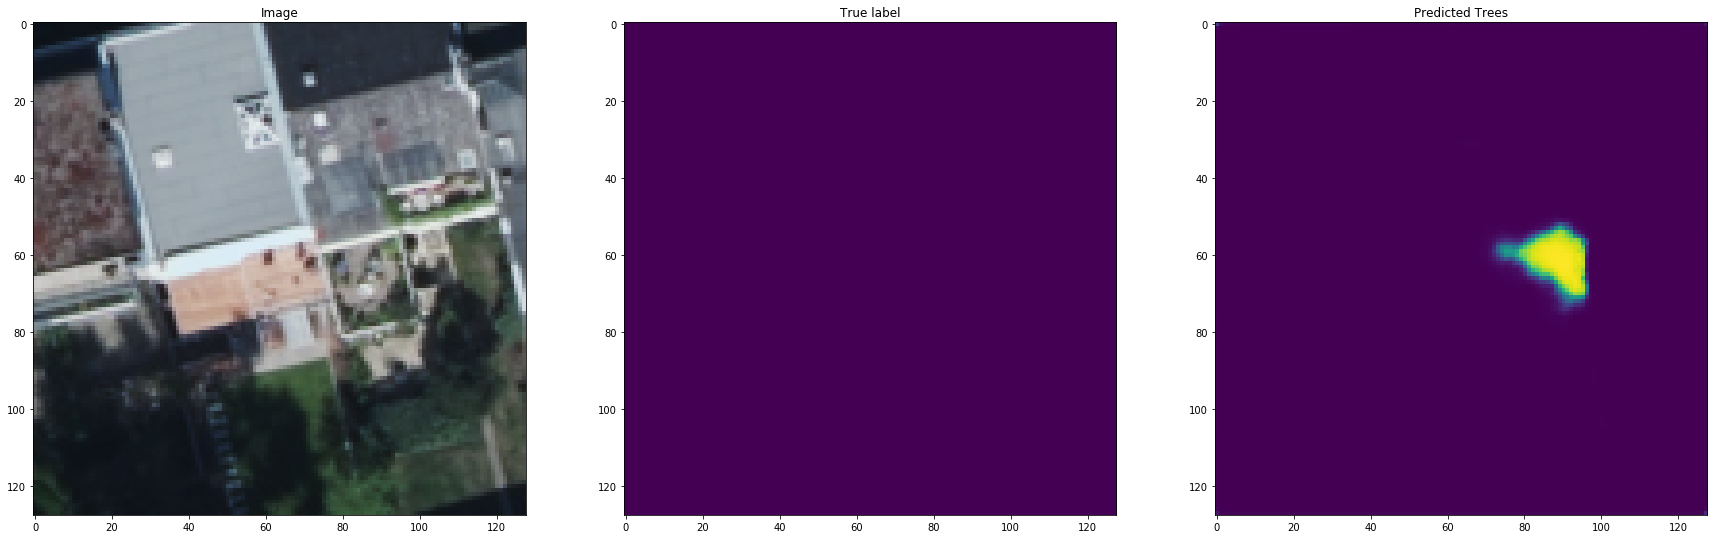

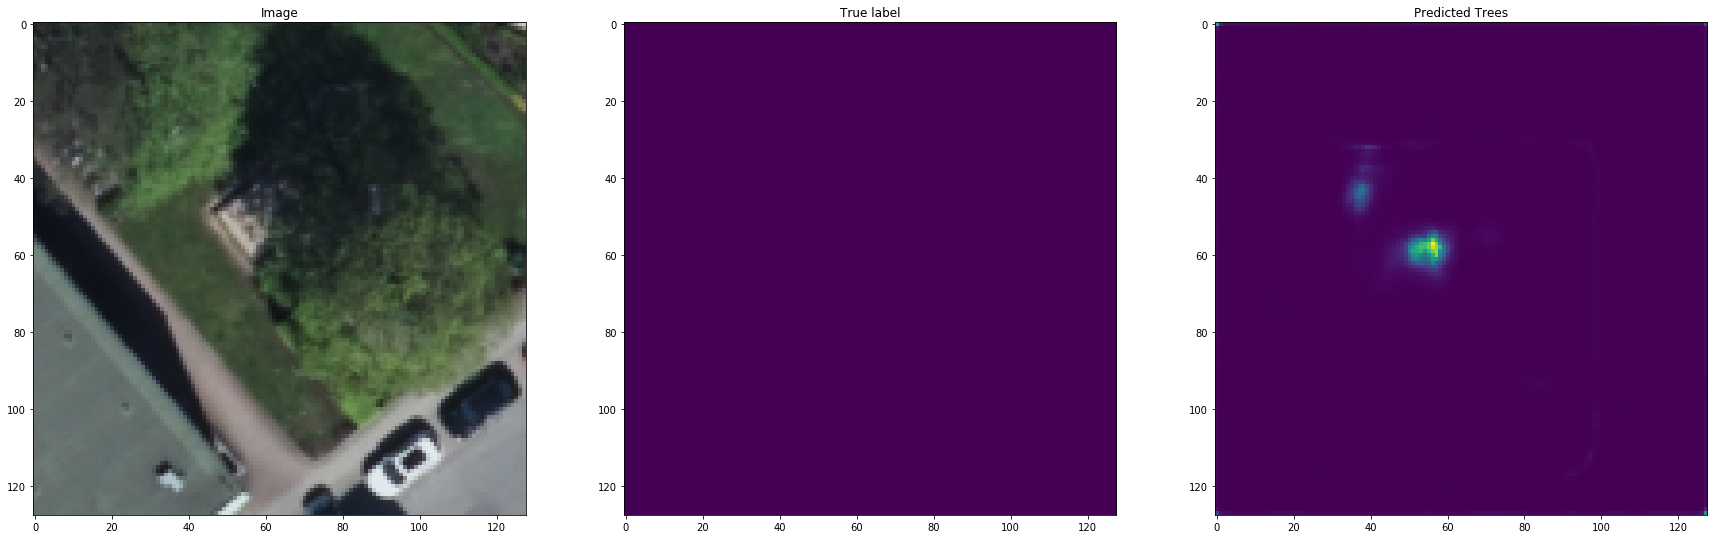

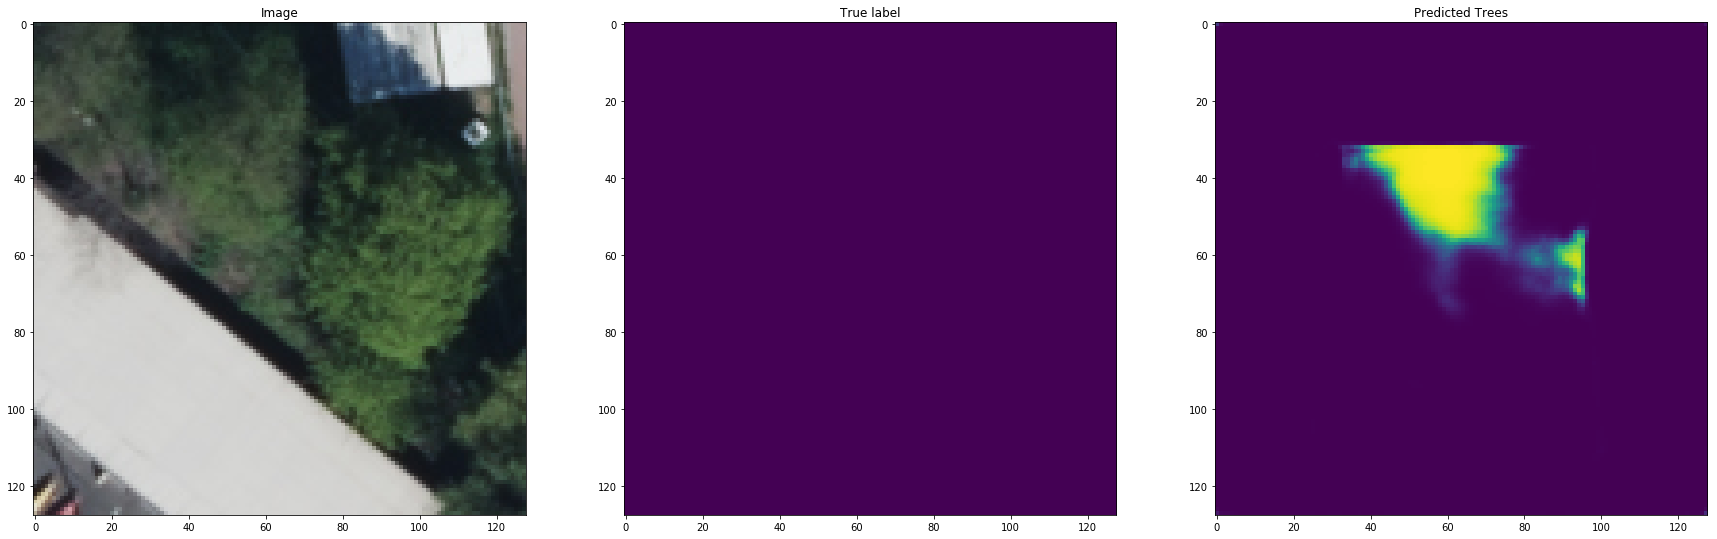

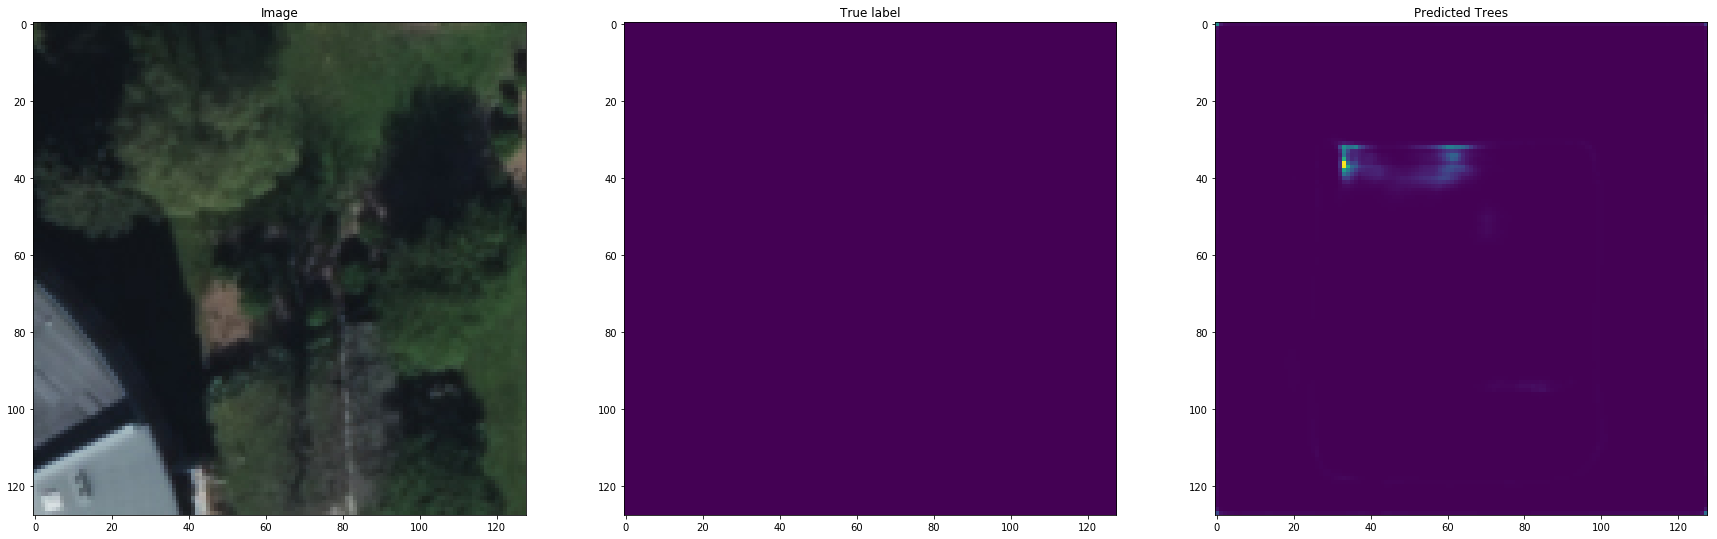

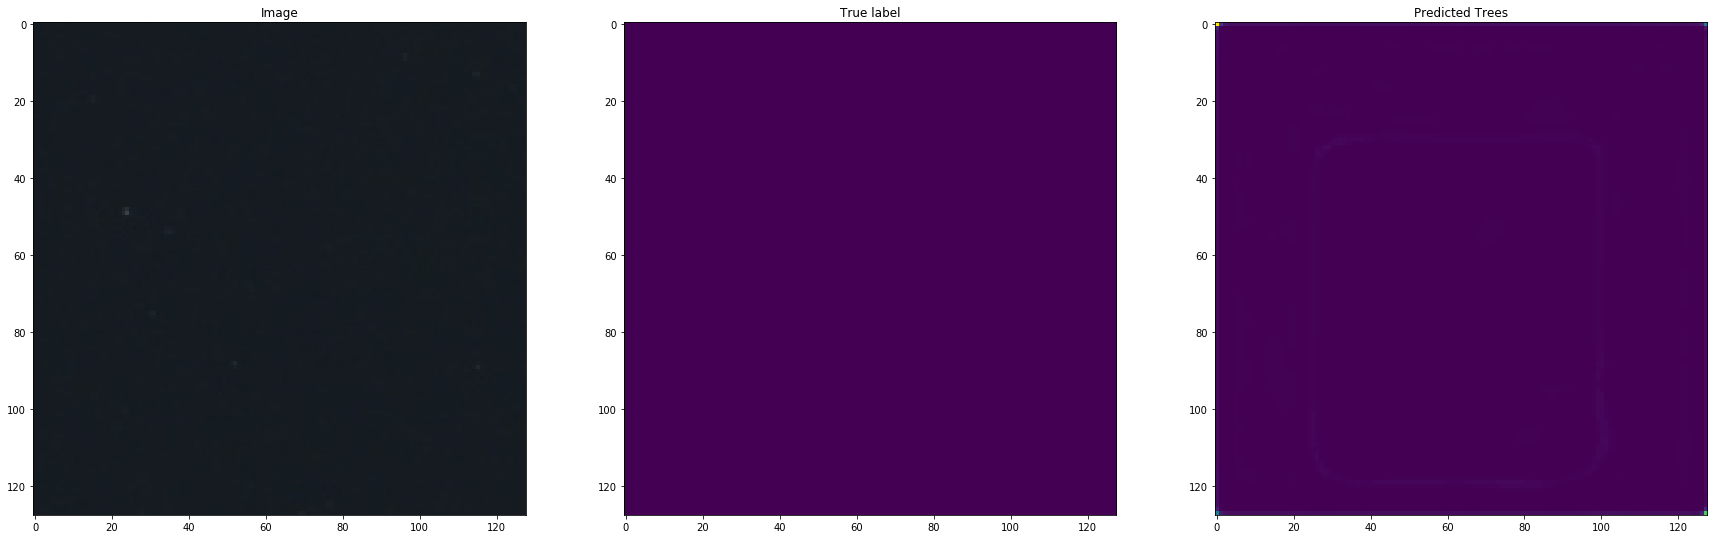

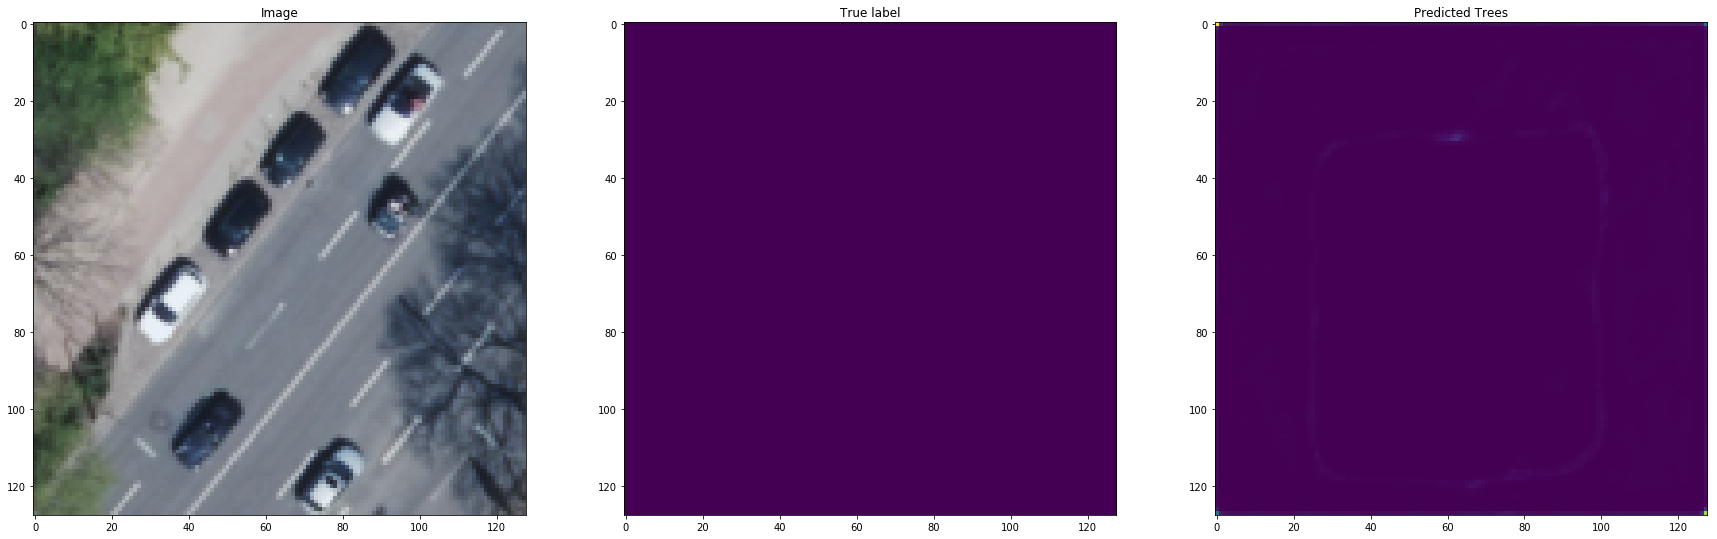

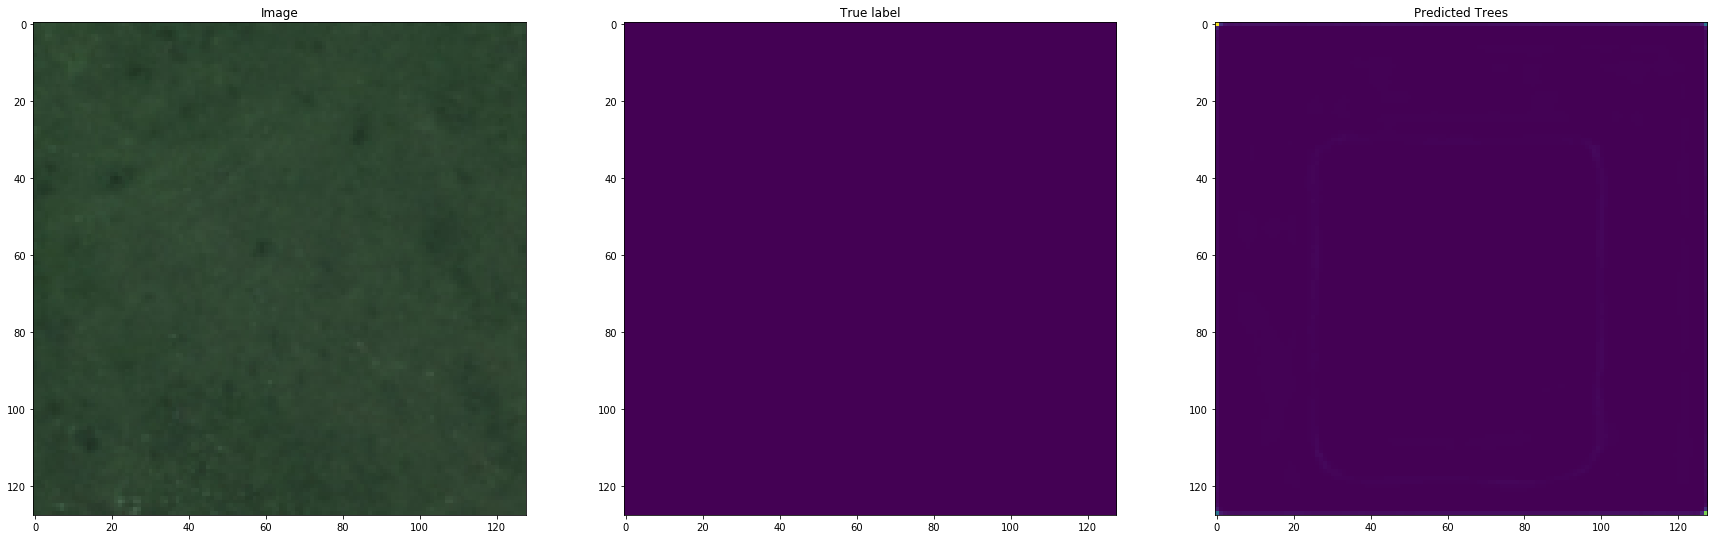

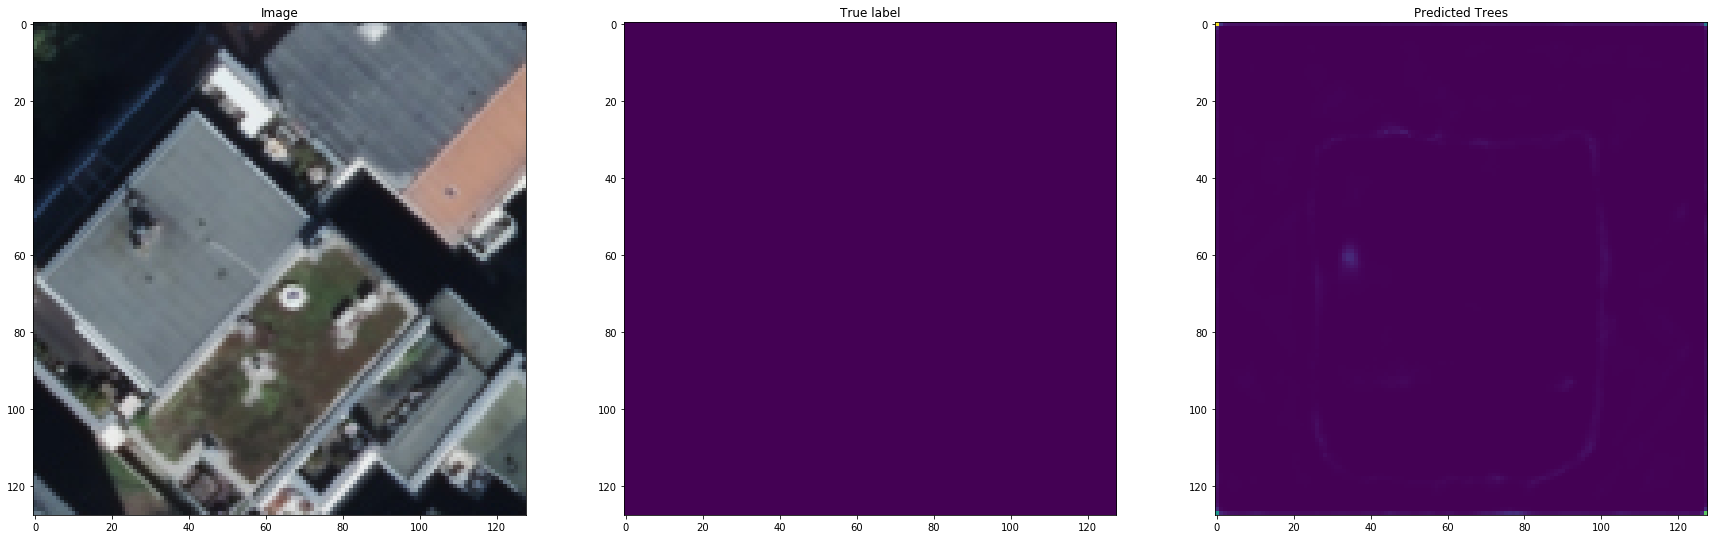

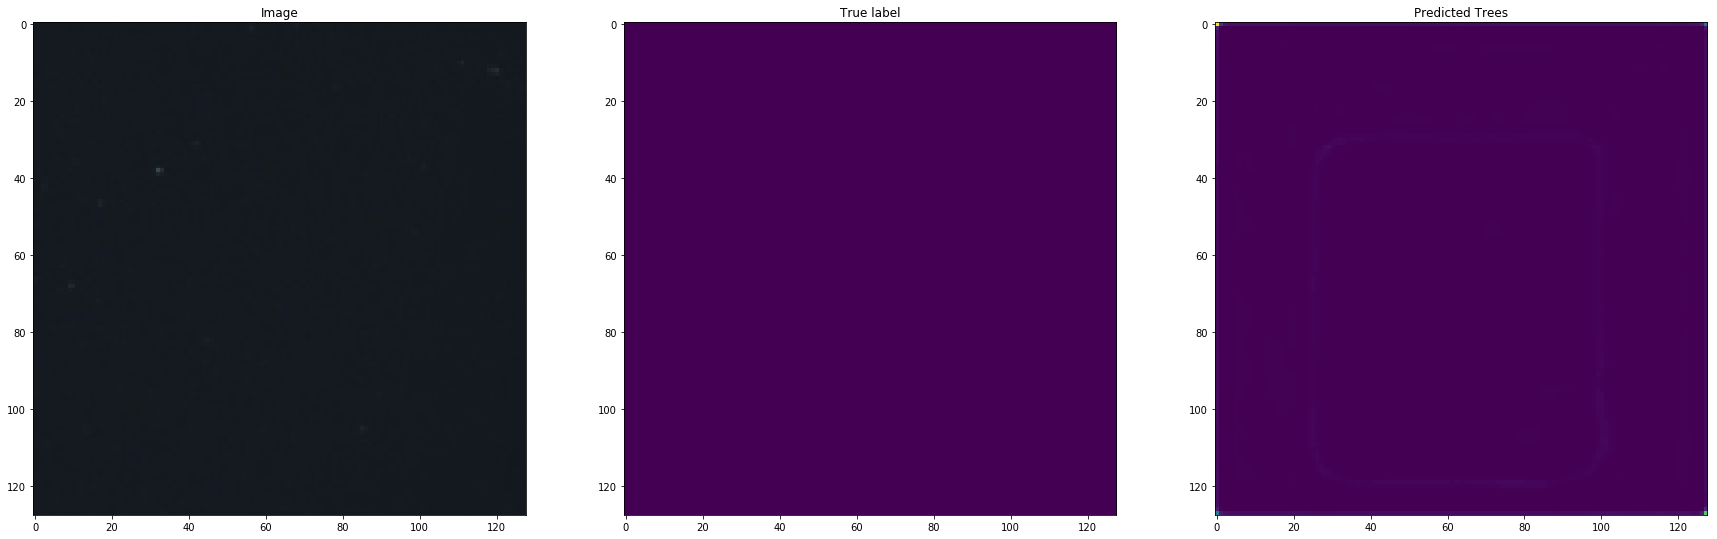

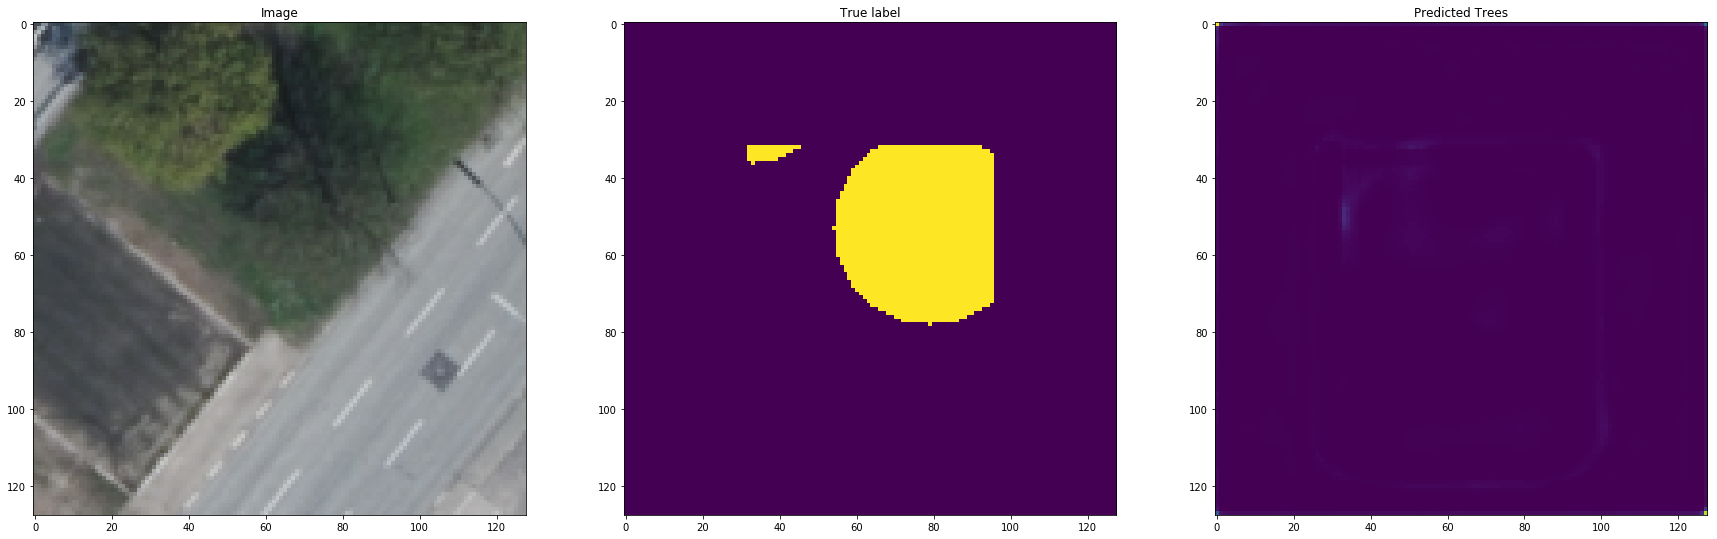

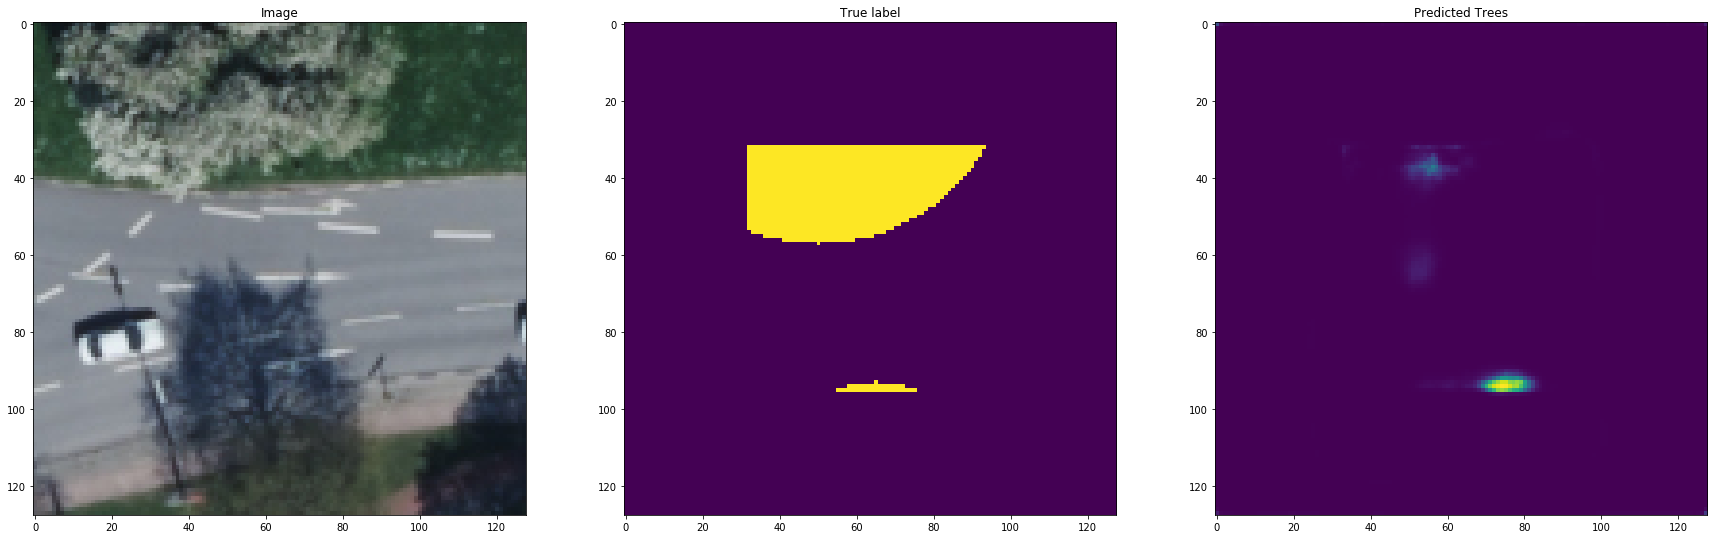

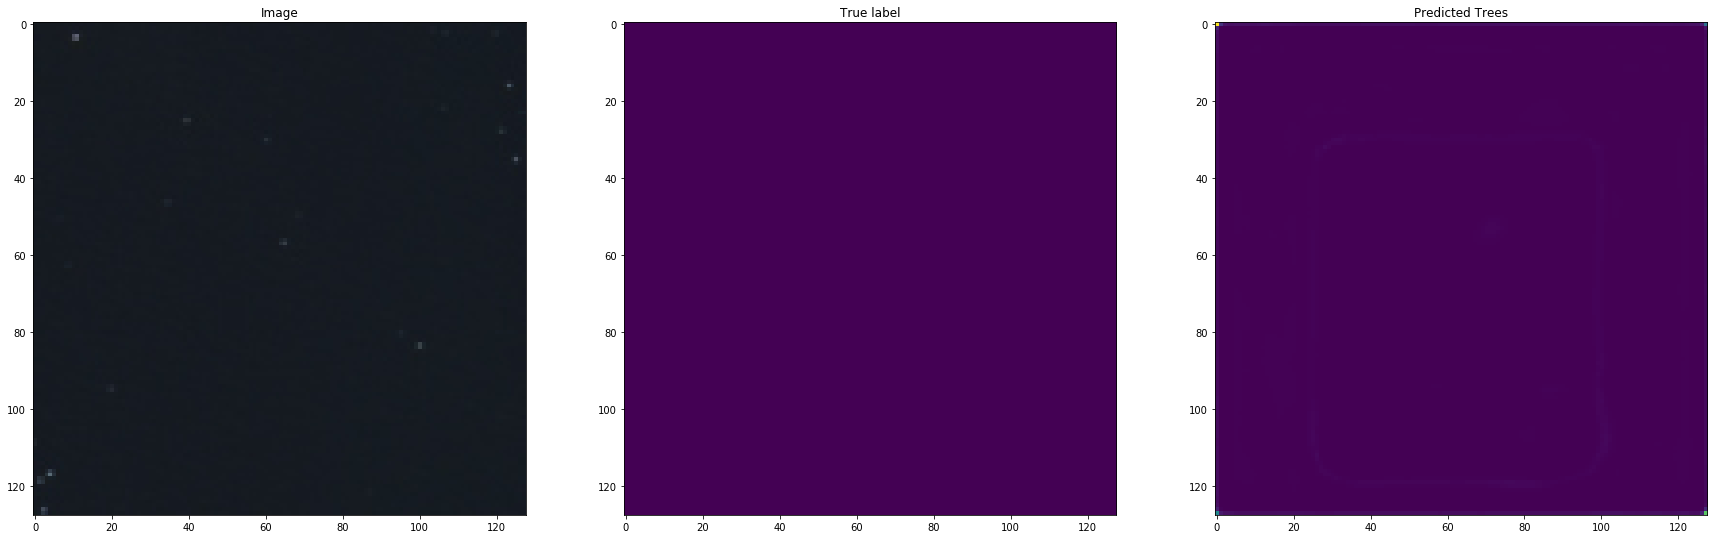

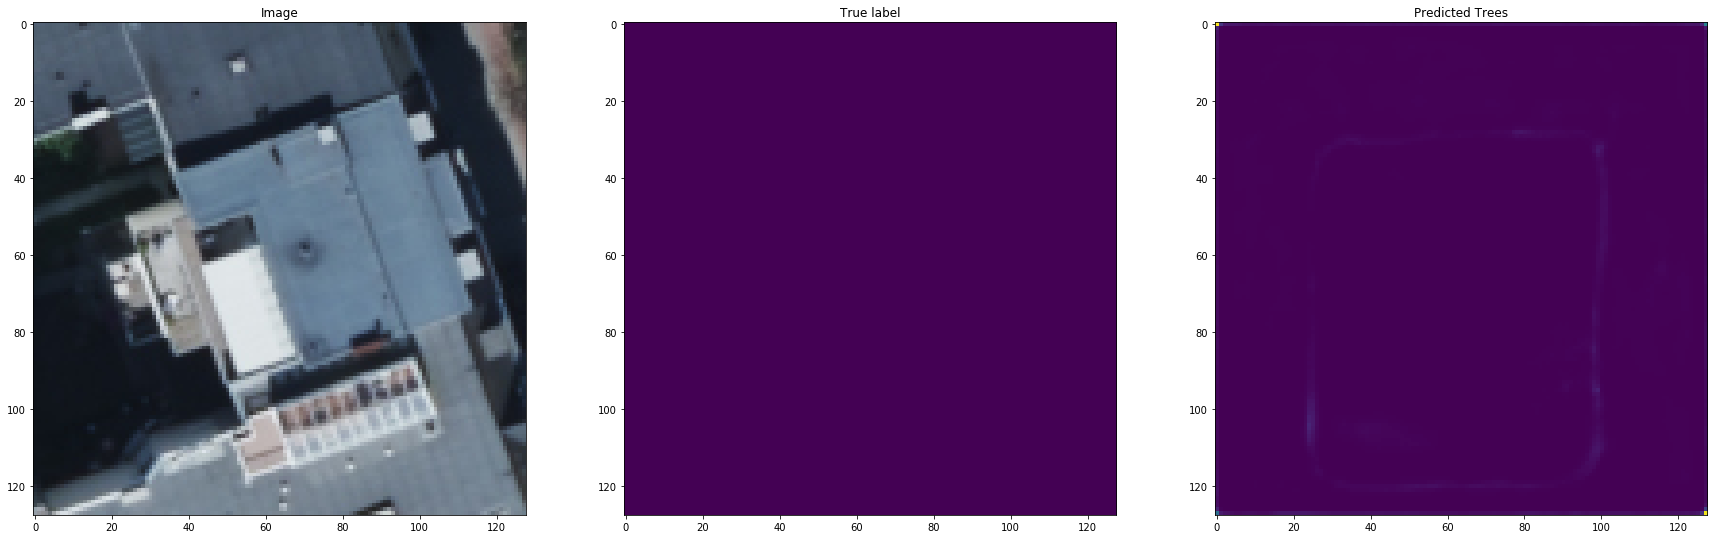

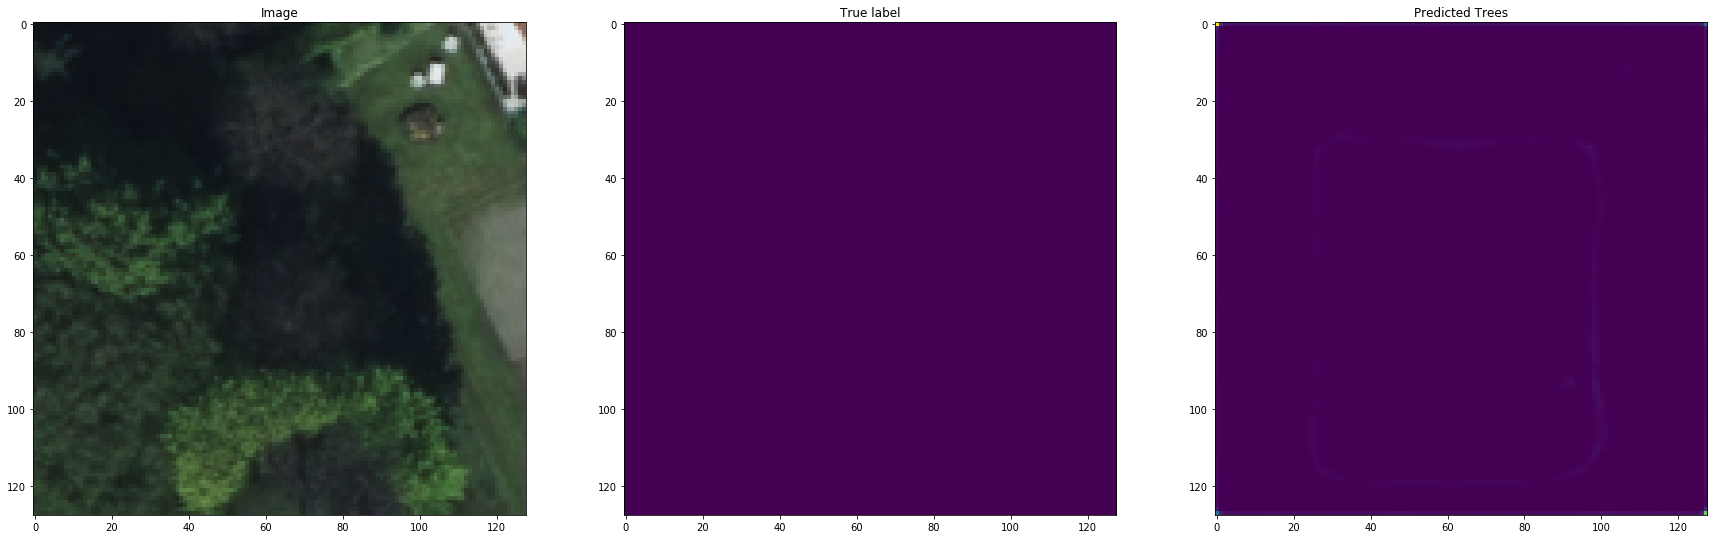

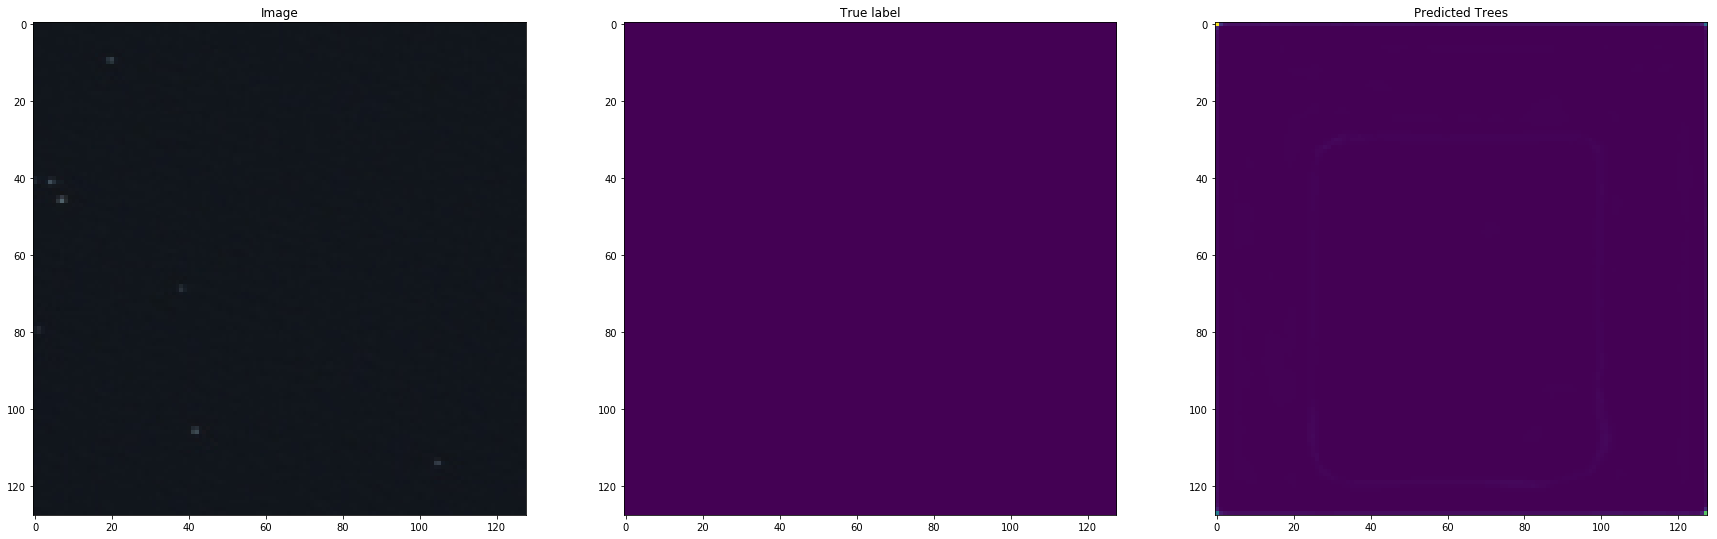

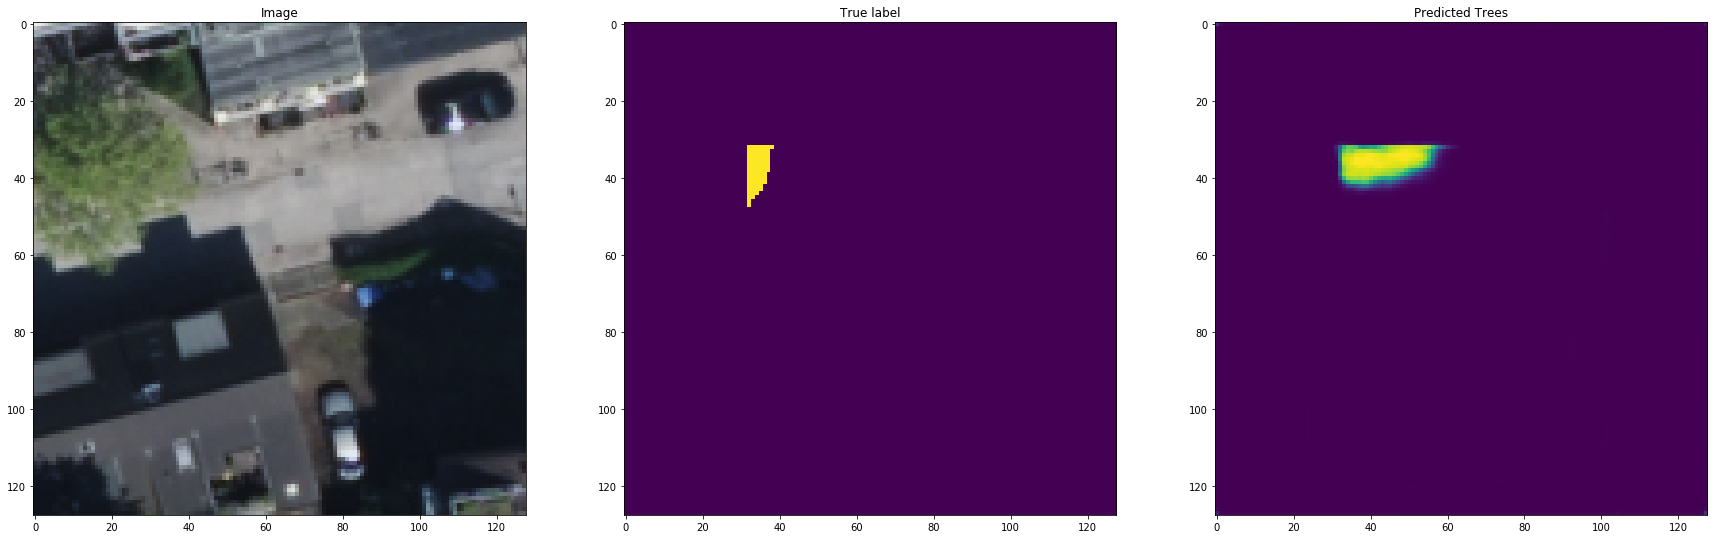

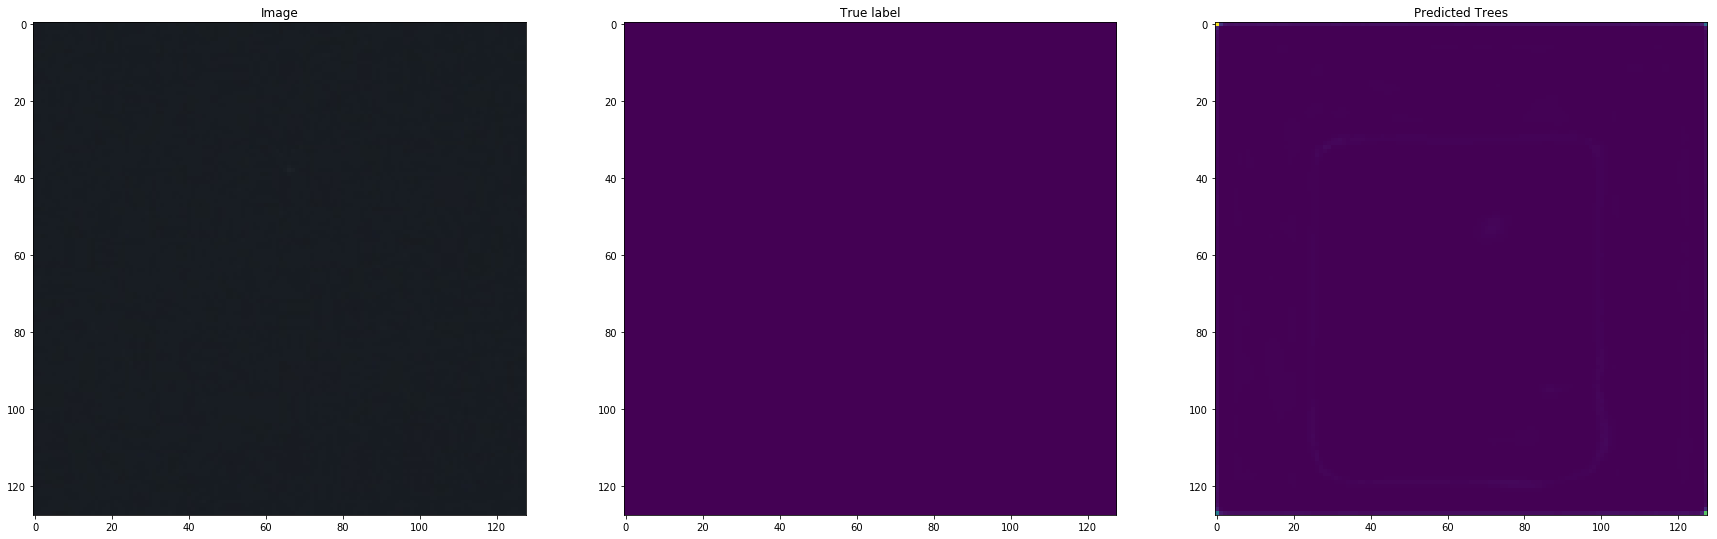

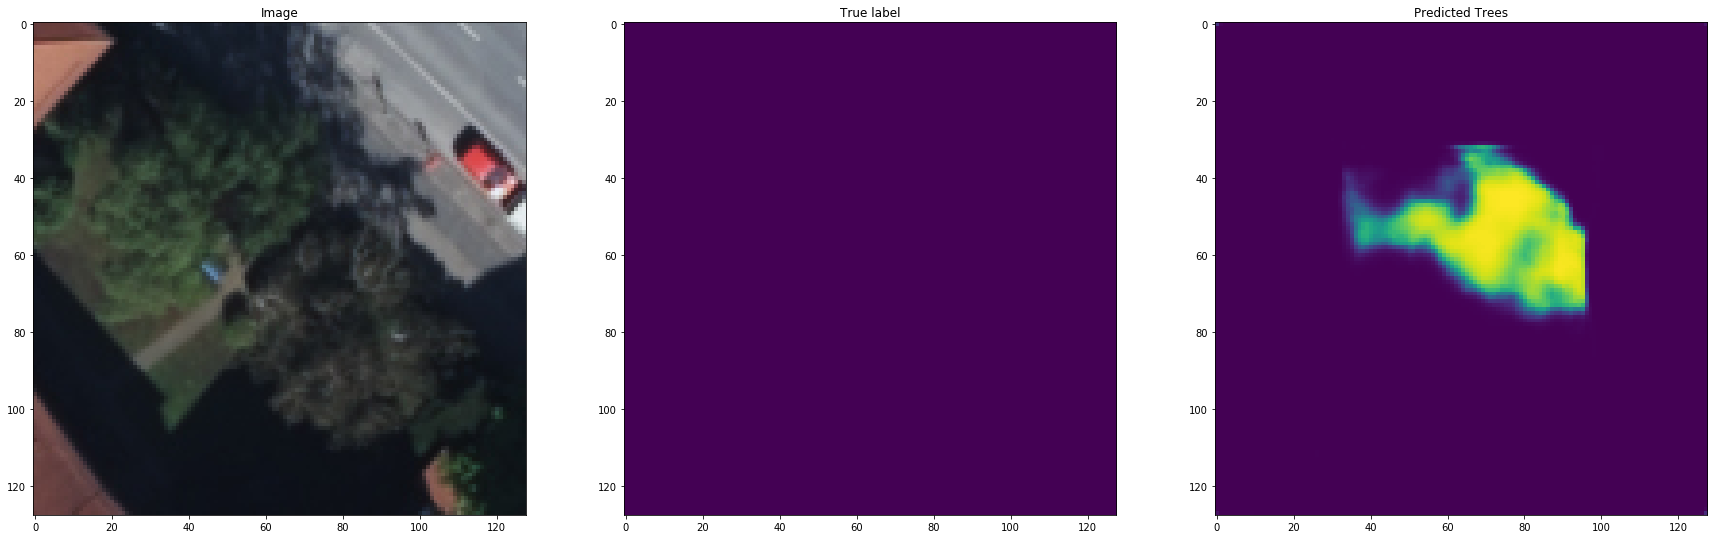

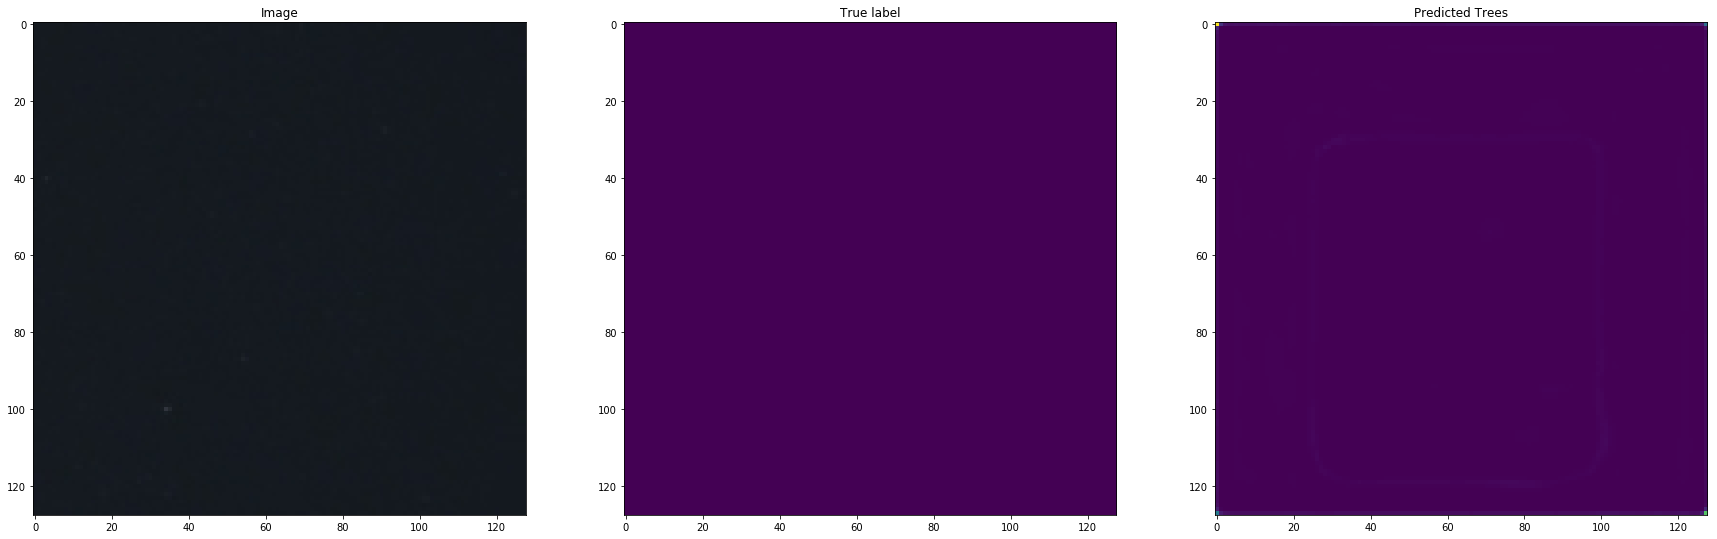

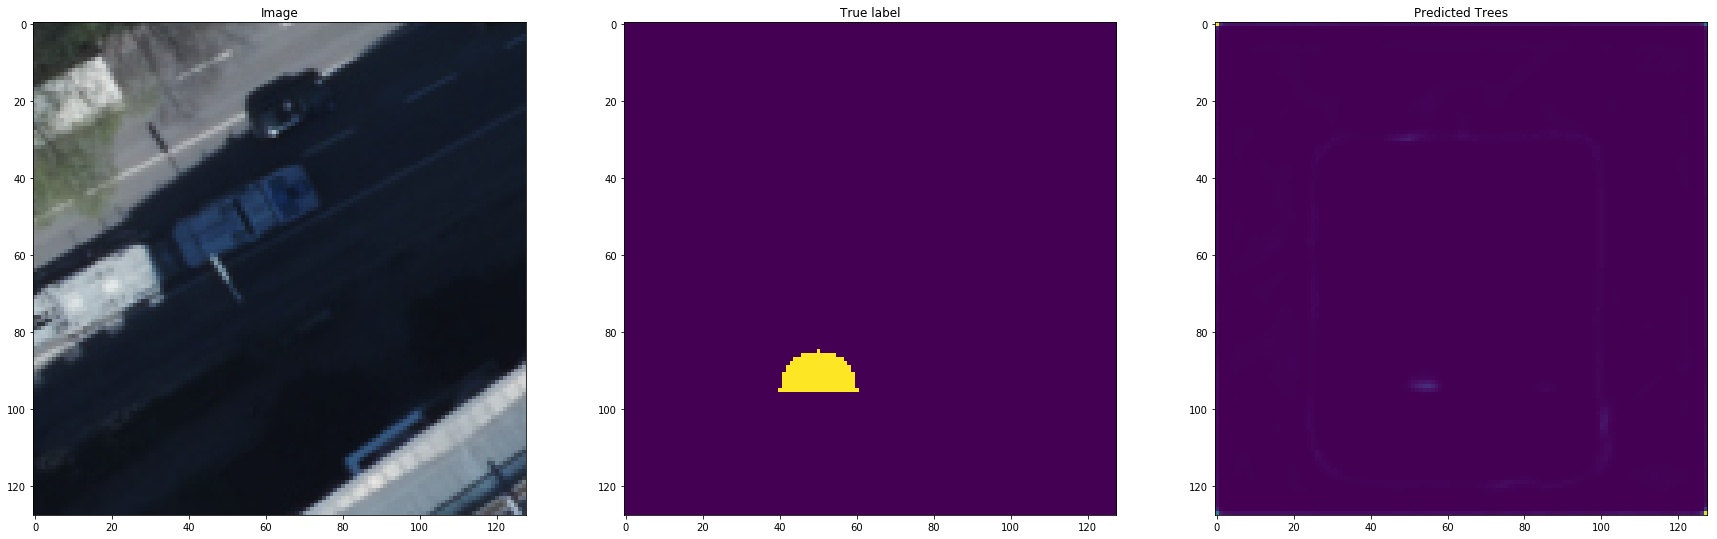

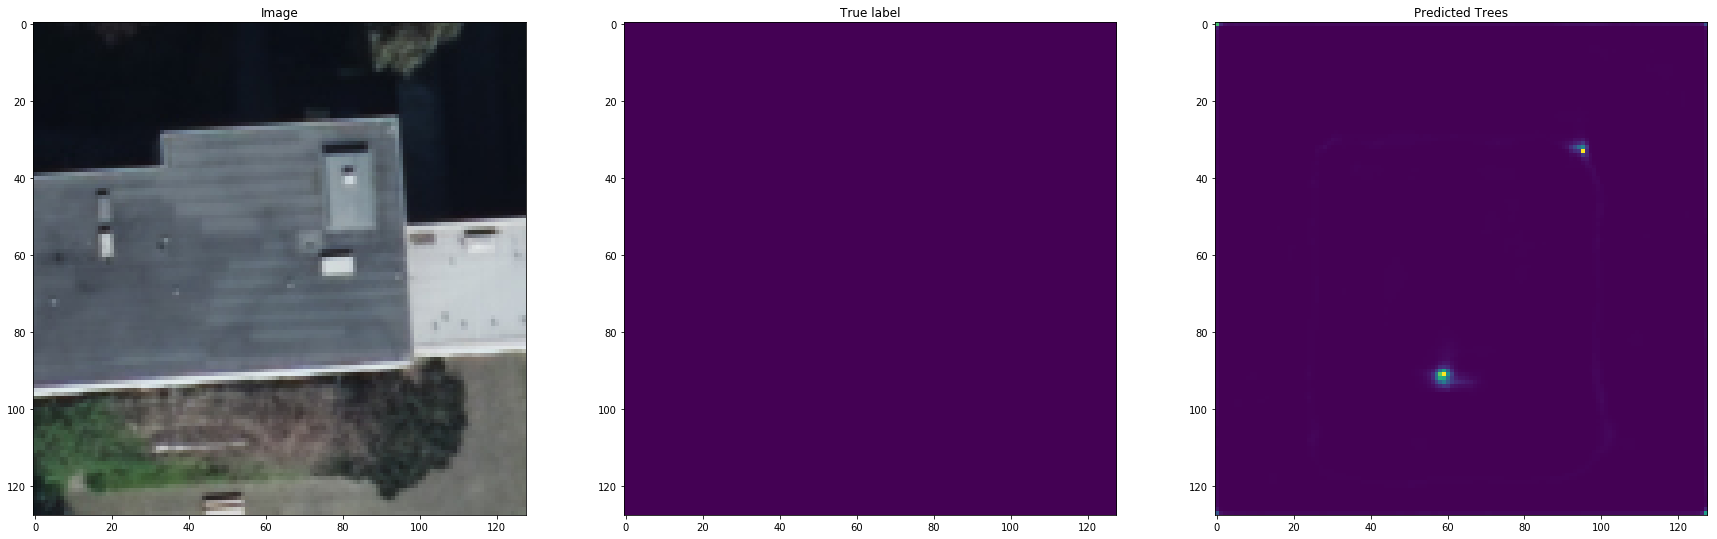

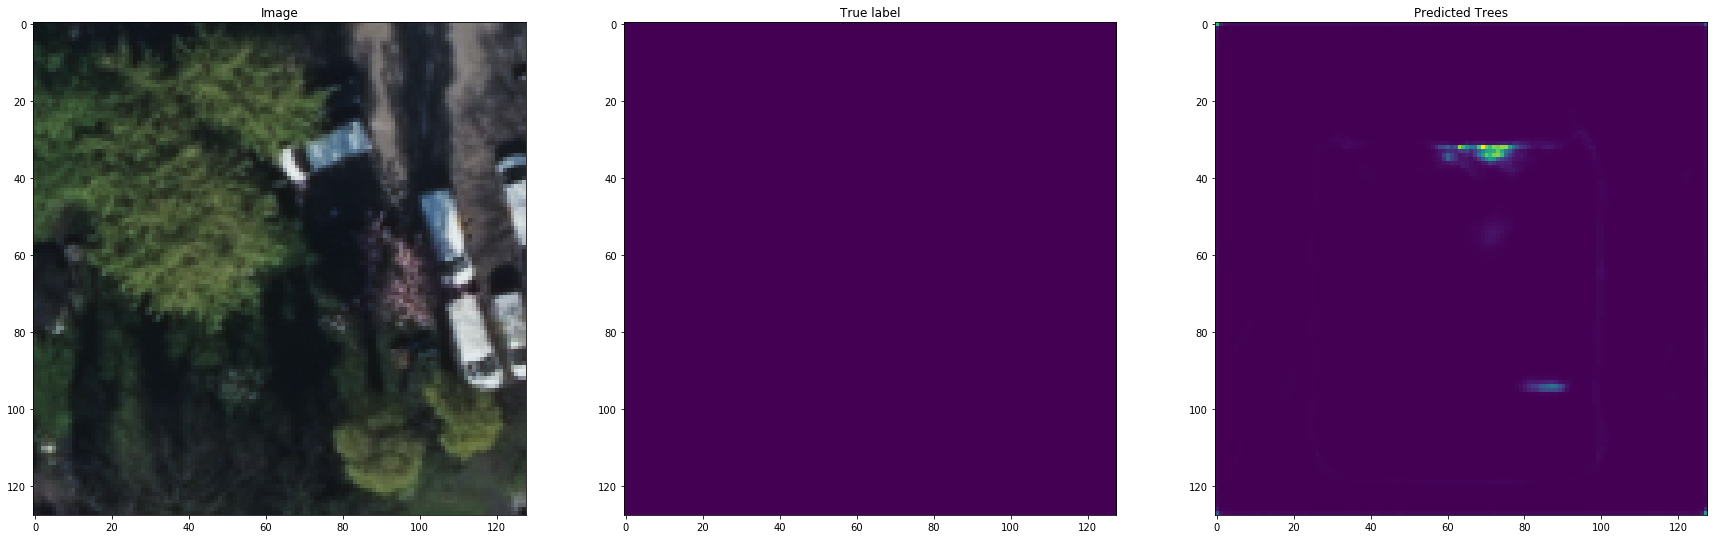

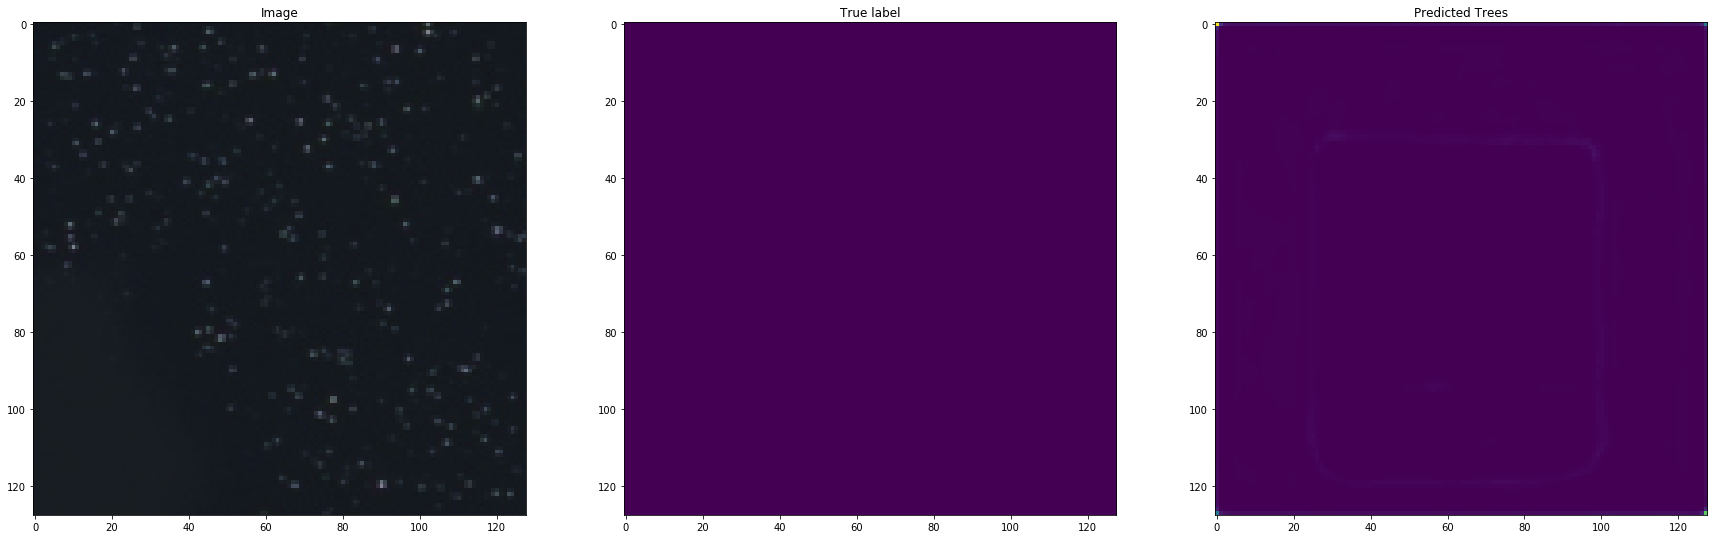

In [16]:
test = sd.static_generator('testing')
# test_images = [next(test)[0] for _ in range(1)]
for _ in range(3):
    test_images, real_label = next(test)
#     print(real_label.shape)
    prediction = model.predict(test_images, steps=1)
#     print(np.min(prediction))
#     print(np.max(prediction))
    for i in range(test_images.shape[0]):
        prediction_img2 = prediction[i]#np.squeeze(prediction, axis=0)#.astype('uint8')
        prediction_img3 = np.squeeze(prediction_img2, axis=-1) 
        prediction_img3 = prediction_img3 / np.max(prediction)
#         print(np.max(prediction_img3))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
        ax1.imshow(test_images[i][:,:,0:3])
        ax1.set_title('Image')
        ax2.imshow(np.squeeze(real_label[i], axis=-1))
        ax2.set_title('True label')
        ax3.imshow(prediction_img3)
        ax3.set_title('Predicted Trees')
        fig.show()
#         plt.rcParams["figure.figsize"] = [8,8]
#         plt.figure(1), plt.imshow(test_images[i])
#         plt.figure(2), plt.imshow(np.squeeze(real_label[i], axis=-1))
#         plt.figure(3), plt.imshow(prediction_img3)
#         plt.show()